In [4]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import pickle
import pandas as pd
from tqdm import tqdm
import torch

In [5]:
def none_reg(x):
    return x

def l2_reg(x):
    return 2 * x

def torch_reg(x):
    return x

In [10]:
! mkdir arch

In [7]:
cat arch/fashion-mnist_test.csv







<!DOCTYPE html>
<html
  lang="en"
  
  data-color-mode="auto" data-light-theme="light" data-dark-theme="dark"
  data-a11y-animated-images="system" data-a11y-link-underlines="true"
  
  >



  <head>
    <meta charset="utf-8">
  <link rel="dns-prefetch" href="https://github.githubassets.com">
  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">
  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">
  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">
  <link rel="preconnect" href="https://github.githubassets.com" crossorigin>
  <link rel="preconnect" href="https://avatars.githubusercontent.com">

  


  <link crossorigin="anonymous" media="all" rel="stylesheet" href="https://github.githubassets.com/assets/light-0cfd1fd8509e.css" /><link crossorigin="anonymous" media="all" rel="stylesheet" href="https://github.githubassets.com/assets/dark-d782f59290e2.css" /><link data-color-theme="dark_dimmed" crossorigin="anonymous" m

In [11]:
! wget https://media.githubusercontent.com/media/fpleoni/fashion_mnist/refs/heads/master/fashion-mnist_test.csv -O arch/fashion-mnist_test.csv
! wget https://media.githubusercontent.com/media/fpleoni/fashion_mnist/refs/heads/master/fashion-mnist_train.csv -O arch/fashion-mnist_train.csv

--2024-12-09 18:26:31--  https://media.githubusercontent.com/media/fpleoni/fashion_mnist/refs/heads/master/fashion-mnist_test.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22176691 (21M) [text/plain]
Saving to: ‘arch/fashion-mnist_test.csv’

arch/fashion-mnist_ 100%[===================>]  21,15M  11,1MB/s    in 1,9s    

2024-12-09 18:26:33 (11,1 MB/s) - ‘arch/fashion-mnist_test.csv’ saved [22176691/22176691]

--2024-12-09 18:26:33--  https://media.githubusercontent.com/media/fpleoni/fashion_mnist/refs/heads/master/fashion-mnist_train.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111

In [12]:
data = pd.read_csv("arch/fashion-mnist_train.csv")

X = torch.from_numpy(data[data.columns[1:]].values).float().cuda()
Y = torch.from_numpy(data[data.columns[0]].values).float().cuda()

In [13]:
test_data = pd.read_csv("archive/fashion-mnist_test.csv")

test_x = torch.from_numpy(test_data[test_data.columns[1:]].values).float().cuda()
test_y = torch.from_numpy(test_data[test_data.columns[0]].values).float().cuda()

test_x = test_x / 255

In [14]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)
X_train_small = X_train_small / 255
X_test_small = X_test_small / 255

In [15]:
def get_batches(x, y, batch_size):
    
    for i in range(0, len(x), batch_size):
        yield x[i:i + batch_size], y[i:i + batch_size]

batch_size = 1024

In [16]:
import torch


class Linear:

    def __init__(self, size: tuple, weight=None, bias=None, init_type='uniform', activation_param=0.001, normalize_forward=True):

        # FIXME
        # actually incorrect init
        if init_type == 'leaky_relu':
            
            if normalize_forward:
                stdv = torch.nn.init.calculate_gain(init_type, activation_param) * size[1]**-0.5
            else:
                stdv = torch.nn.init.calculate_gain(init_type, activation_param) * size[0]**-0.5
                
            self.weight = torch.empty(size).normal_(0, stdv).cuda()
            self.bias = torch.empty(size[1]).normal_(0, stdv).cuda()

        elif init_type == 'uniform':
            # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
            torch.manual_seed(0)
            self.weight = torch.empty(size[0], size[1]).cuda()
            torch.nn.init.kaiming_uniform_(self.weight, a=5**0.5)

            self.bias = torch.empty(size[1]).cuda()
            bound = 1 / size[0]**0.5 if size[0] > 0 else 0
            torch.manual_seed(0)
            torch.nn.init.uniform_(self.bias, -bound, bound)

        if weight is not None:
            
            self.weight = weight
            self.bias = bias
                        
            if weight.shape != size:
                raise Exception("Loaded weight has wrong size!")
        
        self.out = None
        self.inp = None

        
    def update_weights(self, dweights, dbias):

        self.weight -= dweights
        self.bias -= dbias

    def get_weights(self):
        return self.weight, self.bias

    def __call__(self, x, *args, **kwargs):
        
        self.inp = x
        out = x @ self.weight + self.bias
        self.out = out
        
        return out

    def backward(self, dloss, lr, use_old, reg_lambda, regularizer):
                
        d_weights = self.inp.T @ dloss
        d_bias = (torch.ones(self.inp.shape[0]).cuda() @ dloss) / self.inp.shape[0]

        old_w = self.weight.clone()
                
        self.update_weights(lr * (d_weights + reg_lambda * (regularizer(self.weight))),
                            lr * (d_bias + reg_lambda * (regularizer(self.bias))))

        old_loss = torch.mean(dloss).item()
        
        if use_old:
            dloss @= old_w.T 
        
        else:
            dloss @= self.weight.T 

        return dloss
        

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
    
        self.eps = eps
        self.momentum = momentum
    
        self.weight = torch.ones(dim).cuda()
        self.bias = torch.zeros(dim).cuda()
   
        self.running_mean = torch.zeros(dim).cuda()
        self.running_var = torch.ones(dim).cuda()

        self.x = None
        self.xhat = None
        self.out = None

        self.mean = None
        self.var = None
    
    def update_weights(self, dweight, dbias):

        self.weight -= dweight
        self.bias -= dbias


    def __call__(self, x, is_training=True):

        self.x = x
        
        if is_training:
            self.mean = x.mean(0, keepdim=True) # batch mean
            self.var = x.var(0, keepdim=True, unbiased=False) # batch variance

        else:
            self.mean = self.running_mean
            self.var = self.running_var
      
        self.xhat = (x - self.mean) / torch.sqrt(self.var + self.eps) # normalize to unit variance
        
        if is_training:
      
            with torch.no_grad():
                # refer to https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d
                xvar2ema = x.var(0, keepdim=True, unbiased=True)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * self.mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar2ema
        
        self.out = self.weight * self.xhat + self.bias
        
        return self.out
        

    def backward(self, dloss, lr, use_old, reg_lambda, regularizer):
        
        dL_dweight = torch.sum(dloss * self.xhat, axis=0)
        dL_dbias = torch.sum(dloss, axis=0)
        
        N = self.xhat.shape[0]
        
        if not use_old:
            self.update_weights(lr * (dL_dweight + reg_lambda * regularizer(self.weight)),
                                lr * (dL_dbias + reg_lambda * regularizer(self.bias)))  
        
        dL_dx_hat = dloss * self.weight
        dL_dvariance = torch.sum(dL_dx_hat * (self.x - self.mean) * -0.5 * (self.var + self.eps) ** -1.5, axis=0)
        dL_dmean = torch.sum(dL_dx_hat * -1 / torch.sqrt(self.var + self.eps), axis=0) + dL_dvariance * torch.mean(-2 * (self.x - self.mean), axis=0)
        
        dloss = (dL_dx_hat / torch.sqrt(self.var + self.eps)) + (dL_dvariance * 2 / N * (self.x - self.mean)) + (dL_dmean / N)

        if use_old:
             self.update_weights(lr * (dL_dweight + reg_lambda * regularizer(self.weight)),
                                 lr * (dL_dbias + reg_lambda * regularizer(self.bias)))
            
        return dloss


class LReLU:
    def __init__(self, a):
        self.a = a
        
        self.out = None
        self.local_grad = None

    def __call__(self, x, is_training=True, *args, **kwargs):
        
        out = torch.where(x >= 0, x, self.a * x)
        self.out = out
        self.local_grad = torch.where(out >= 0, 1, self.a)
            
        return out

    def backward(self, dloss, *args, **kwargs):
        return dloss * self.local_grad

class CrossEntropy:

    def __init__(self, optimize_exponents=True):
        self.optimize_exponents = optimize_exponents
        self.local_grad = None

    def __call__(self, x, target, is_training=True, *args, **kwargs):
        num_classes = x.shape[-1]
        one_hot_target = torch.nn.functional.one_hot(target.long(), num_classes)
        
        # if is_training:
        self.local_grad = -(one_hot_target - self.get_probabilities(x)) / len(x)
        
        mean_cross_entropy = -((x * one_hot_target).sum(axis=1, keepdim=True) - x.exp().sum(axis=1, keepdim=True).log()).mean()
        return mean_cross_entropy
        
        # equal to torch.nn.CrossEntropyLoss()
        # torch_ce = torch.nn.CrossEntropyLoss()
        # return torch_ce(x, target.long())
        # assert torch.abs(torch_ce(x, target) - mean_cross_entropy).max() < 1e-3

    def get_probabilities(self, x):
        _gamma = torch.amax(x)
        if self.optimize_exponents:
            _exp_outputs = (x - _gamma).exp()
        else:
            _exp_outputs = x.exp()
        return (_exp_outputs.T / _exp_outputs.sum(axis=1)).T

In [17]:
import torch

class Network:

    def __init__(self, reg_func, loss_func, reg_lambda: float, lr: float):
        
        self.layers = []
        self.reg_func = reg_func
        self.reg_lambda = reg_lambda
        self.lr = lr
        self.loss_func = loss_func
        self.loss = None
        
        self.last_added_fan_out = None

    def change_lr(self, lr):
        self.lr = lr
    
    def add_layer(self, layer):
        
        print(f'Adding layer: {layer.__class__.__name__}')
        
        if not self.layers or layer.__class__.__name__ not in ['Linear', 'BatchNorm1d']:
            
            self.layers.append(layer)
            
            if hasattr(layer, 'weight'):
                self.last_added_fan_out = layer.weight.shape[1]
        
        elif self.last_added_fan_out == layer.weight.shape[0]:
            
            if layer.__class__.__name__ == 'BatchNorm1d':
                self.last_added_fan_out = layer.weight.shape[0]
            else:
                self.last_added_fan_out = layer.weight.shape[1]
            
            self.layers.append(layer)

        else:
            raise Exception("Wrong size of the layer!")
            

    def get_loss(self):
        return self.loss.detach().cpu().numpy()

    def predict(self, x):
        
        for layer in self.layers:
            
            x = layer(x, is_training=False)
            
        return x
    

    def eval(self, x, target):
        
        for layer in self.layers:
            
            x = layer(x, is_training=False)
            
        return x, self.loss_func(x, target, is_training=False).detach().cpu().numpy()     

    def my_fit(self, x: torch.Tensor, target, use_old):
        
        for layer in self.layers:
            x = layer(x)
            
        self.loss = self.loss_func(x, target).detach().cpu().numpy()
        
        dloss = self.loss_func.local_grad
        
        layers_reversed = self.layers[::-1]

        for i, layer in enumerate(layers_reversed):
            dloss = layer.backward(dloss, self.lr, use_old, self.reg_lambda, self.reg_func)
            
        return self.loss

In [18]:
import torch
from copy import deepcopy

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()
        self.linear1 = torch.nn.Linear(784, 512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.relu1 = torch.nn.LeakyReLU(0.001)     

        self.linear2 = torch.nn.Linear(512, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.relu2 = torch.nn.LeakyReLU(0.001) 

        self.linear3 = torch.nn.Linear(256, 128)
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.relu3 = torch.nn.LeakyReLU(0.001) 

        self.linear4 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.relu2(x)
 
        x = self.linear3(x)
        x = self.bn3(x)
        x = self.relu3(x)
 
        x = self.linear4(x)
        # print(x.mean().item())
        return x

In [19]:
tinymodel = TinyModel()
tinymodel.cuda()

tinymodel_my = deepcopy(tinymodel)
init_weight1 = deepcopy(tinymodel.linear1.weight.detach().T)
init_bias1 = deepcopy(tinymodel.linear1.bias.detach())

init_weight2 = deepcopy(tinymodel.linear2.weight.detach().T)
init_bias2 = deepcopy(tinymodel.linear2.bias.detach())

init_weight3 = deepcopy(tinymodel.linear3.weight.detach().T)
init_bias3 = deepcopy(tinymodel.linear3.bias.detach())

init_weight4 = deepcopy(tinymodel.linear4.weight.detach().T)
init_bias4 = deepcopy(tinymodel.linear4.bias.detach())

ce = CrossEntropy(optimize_exponents=True)

nn3_old_bn = Network(reg_func=torch_reg, loss_func=ce, reg_lambda=0.001, lr=0.01)

nn3_old_bn.add_layer(Linear((784, 512), weight=init_weight1, bias=init_bias1))
nn3_old_bn.add_layer(BatchNorm1d(512))
nn3_old_bn.add_layer(LReLU(0.001))

nn3_old_bn.add_layer(Linear((512, 256), weight=init_weight2, bias=init_bias2))
nn3_old_bn.add_layer(BatchNorm1d(256))
nn3_old_bn.add_layer(LReLU(0.001))

nn3_old_bn.add_layer(Linear((256, 128), weight=init_weight3, bias=init_bias3))
nn3_old_bn.add_layer(BatchNorm1d(128))
nn3_old_bn.add_layer(LReLU(0.001))

nn3_old_bn.add_layer(Linear((128, 10), weight=init_weight4, bias=init_bias4))


optimizer = torch.optim.SGD(tinymodel.parameters(), weight_decay=0.001, lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

batch_size = 128

lt = []
lm = []

bn_grads = []
dw_grads = []

def train():
    for ep in range(50):
        #print(f'{ep} ---------------------')
        loss_ = []
        loss_my_ = []
        for i, batch in enumerate(get_batches(X_test_small, y_test_small, batch_size)):
            
            x_batch, y_batch = batch
            optimizer.zero_grad()

            outputs = tinymodel(x_batch)
            loss = loss_fn(outputs, y_batch.long())
            loss_.append(loss.detach().cpu())
            
            loss.backward()
            optimizer.step()

            loss_my_.append(nn3_old_bn.my_fit(x_batch, y_batch, use_old=True))
            
        lt.append(sum(loss_) / len(loss_))
        lm.append(sum(loss_my_) / len(loss_my_))
        
train()
%clear

Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear


In [21]:
torch.__version__

'2.4.1+cu118'

In [14]:
ce = CrossEntropy(optimize_exponents=True)

nn8_old_bn = Network(reg_func=torch_reg, loss_func=ce, reg_lambda=0.001, lr=0.001)

nn8_old_bn.add_layer(Linear((784, 784)))
nn8_old_bn.add_layer(BatchNorm1d(784))
nn8_old_bn.add_layer(LReLU(0.001))

nn8_old_bn.add_layer(Linear((784, 512)))
nn8_old_bn.add_layer(BatchNorm1d(512))
nn8_old_bn.add_layer(LReLU(0.001))

nn8_old_bn.add_layer(Linear((512, 512)))
nn8_old_bn.add_layer(BatchNorm1d(512))
nn8_old_bn.add_layer(LReLU(0.001))

nn8_old_bn.add_layer(Linear((512, 256)))
nn8_old_bn.add_layer(BatchNorm1d(256))
nn8_old_bn.add_layer(LReLU(0.001))

nn8_old_bn.add_layer(Linear((256, 256)))
nn8_old_bn.add_layer(BatchNorm1d(256))
nn8_old_bn.add_layer(LReLU(0.001))

nn8_old_bn.add_layer(Linear((256, 128)))
nn8_old_bn.add_layer(BatchNorm1d(128))
nn8_old_bn.add_layer(LReLU(0.001))

nn8_old_bn.add_layer(Linear((128, 10)))
nn8_old_bn.add_layer(BatchNorm1d(10))
nn8_old_bn.add_layer(LReLU(0.001))

nn8_old_bn.add_layer(Linear((10, 10)))

nn8_new_bn = deepcopy(nn8_old_bn)

Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear


In [15]:
ce = CrossEntropy(optimize_exponents=True)

nn6_old_bn = Network(reg_func=torch_reg, loss_func=ce, reg_lambda=0.001, lr=0.001)

nn6_old_bn.add_layer(Linear((784, 512)))
nn6_old_bn.add_layer(BatchNorm1d(512))
nn6_old_bn.add_layer(LReLU(0.001))

nn6_old_bn.add_layer(Linear((512, 256)))
nn6_old_bn.add_layer(BatchNorm1d(256))
nn6_old_bn.add_layer(LReLU(0.001))

nn6_old_bn.add_layer(Linear((256, 128)))
nn6_old_bn.add_layer(BatchNorm1d(128))
nn6_old_bn.add_layer(LReLU(0.001))

nn6_old_bn.add_layer(Linear((128, 64)))
nn6_old_bn.add_layer(BatchNorm1d(64))
nn6_old_bn.add_layer(LReLU(0.001))

nn6_old_bn.add_layer(Linear((64, 32)))
nn6_old_bn.add_layer(BatchNorm1d(32))
nn6_old_bn.add_layer(LReLU(0.001))

nn6_old_bn.add_layer(Linear((32, 10)))

nn6_new_bn = deepcopy(nn6_old_bn)

Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear


In [16]:
ce = CrossEntropy(optimize_exponents=True)

nn2_old_bn = Network(reg_func=torch_reg, loss_func=ce, reg_lambda=0.001, lr=0.001)

nn2_old_bn.add_layer(Linear((784, 256)))
nn2_old_bn.add_layer(BatchNorm1d(256))
nn2_old_bn.add_layer(LReLU(0.001))

nn2_old_bn.add_layer(Linear((256, 10)))

nn2_new_bn = deepcopy(nn2_old_bn)

Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear


In [17]:
ce = CrossEntropy(optimize_exponents=True)

nn3_old_bn = Network(reg_func=torch_reg, loss_func=ce, reg_lambda=0.001, lr=0.001)

nn3_old_bn.add_layer(Linear((784, 512)))
nn3_old_bn.add_layer(BatchNorm1d(512))
nn3_old_bn.add_layer(LReLU(0.001))

nn3_old_bn.add_layer(Linear((512, 256)))
nn3_old_bn.add_layer(BatchNorm1d(256))
nn3_old_bn.add_layer(LReLU(0.001))

nn3_old_bn.add_layer(Linear((256, 128)))
nn3_old_bn.add_layer(BatchNorm1d(128))
nn3_old_bn.add_layer(LReLU(0.001))

nn3_old_bn.add_layer(Linear((128, 10)))

nn3_new_bn = deepcopy(nn3_old_bn)


nn3_old_nobn = Network(reg_func=torch_reg, loss_func=ce, reg_lambda=0.001, lr=0.001)

nn3_old_nobn.add_layer(Linear((784, 512)))
nn3_old_nobn.add_layer(LReLU(0.001))

nn3_old_nobn.add_layer(Linear((512, 256)))
nn3_old_nobn.add_layer(LReLU(0.001))

nn3_old_nobn.add_layer(Linear((256, 128)))
nn3_old_nobn.add_layer(LReLU(0.001))

nn3_old_nobn.add_layer(Linear((128, 10)))

nn3_new_nobn = deepcopy(nn3_old_nobn)

Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: BatchNorm1d
Adding layer: LReLU
Adding layer: Linear
Adding layer: Linear
Adding layer: LReLU
Adding layer: Linear
Adding layer: LReLU
Adding layer: Linear
Adding layer: LReLU
Adding layer: Linear


In [18]:
def train_two_models(model_one, model_two, epoch, batch_size, lr_schedule=None):
    
    loss_tr_old = []
    loss_val_old = []
    loss_tr_new = []
    loss_val_new = []
    
    acc_tr_old = []
    acc_val_old = []
    acc_tr_new = []
    acc_val_new = []
    
    for ep in range(epoch):
        
        loss_tr_old_ = []
        loss_val_old_ = []
        loss_tr_new_ = []
        loss_val_new_ = []
    
        acc_tr_old_ = []
        acc_val_old_ = []
        acc_tr_new_ = []
        acc_val_new_ = []

        if (lr_schedule is not None) and ep in lr_schedule:
            model_one.change_lr(lr_schedule[ep])
            model_two.change_lr(lr_schedule[ep])
        
        for i, batch in tqdm(enumerate(get_batches(X_train_small, y_train_small, batch_size))):
            
            x_batch, y_batch = batch
    
            loss_tr_old_.append(model_one.my_fit(x_batch, y_batch, True))
            loss_tr_new_.append(model_two.my_fit(x_batch, y_batch, False))
    
            old_pred = model_one.predict(x_batch).argmax(dim=1)
            new_pred = model_two.predict(x_batch).argmax(dim=1)
    
            acc_tr_old_.append((old_pred == y_batch).sum() / len(old_pred))
            acc_tr_new_.append((new_pred == y_batch).sum() / len(new_pred))
    
        loss_tr_old.append(sum(loss_tr_old_) / len(loss_tr_old_))
        loss_tr_new.append(sum(loss_tr_new_) / len(loss_tr_new_))
    
        acc_tr_old.append((sum(acc_tr_old_) / len(acc_tr_old_)).item())
        acc_tr_new.append((sum(acc_tr_new_) / len(acc_tr_new_)).item())
        
        
        for i, batch in enumerate(get_batches(X_test_small, y_test_small, batch_size)):
            
            x_batch, y_batch = batch
    
            old_pred, loss_old = model_one.eval(x_batch, y_batch)
            new_pred, loss_new = model_two.eval(x_batch, y_batch)
    
            old_pred = old_pred.argmax(dim=1)
            new_pred = new_pred.argmax(dim=1)
            
            loss_val_old_.append(loss_old)
            loss_val_new_.append(loss_new)
    
            acc_val_old_.append((old_pred == y_batch).sum() / len(old_pred))
            acc_val_new_.append((new_pred == y_batch).sum() / len(new_pred))
        
        loss_val_old.append(sum(loss_val_old_) / len(loss_val_old_))
        loss_val_new.append(sum(loss_val_new_) / len(loss_val_new_))
    
        acc_val_old.append((sum(acc_val_old_) / len(acc_val_old_)).item())
        acc_val_new.append((sum(acc_val_new_) / len(acc_val_new_)).item())
    
            
        print(f'epoch: {ep} loss_tr_old: {loss_tr_old[-1]}, loss_tr_new: {loss_tr_new[-1]}, acc_tr_old: {acc_tr_old[-1]}, acc_tr_new: {acc_tr_new[-1]}')
        print(f'         loss_val_old: {loss_val_old[-1]}, loss_val_new: {loss_val_new[-1]}, acc_val_old: {acc_val_old[-1]}, acc_val_new: {acc_val_new[-1]}')
        print("-" * 100)
    
    num_of_layers = sum(1 for layer in model_one.layers if isinstance(layer, Linear))
    is_bn = bool(sum(1 for layer in model_one.layers if isinstance(layer, BatchNorm1d)))
    
    output = open(f'results/bs-{batch_size};layers-{num_of_layers};-BN={is_bn}.pkl', 'wb')
    pickle.dump([loss_tr_old, loss_tr_new, acc_tr_old, acc_tr_new, loss_val_old, loss_val_new, acc_val_old, acc_val_new], output)
    output.close()

In [19]:
def train_batches(model_one, model_two, epoch, init_lr_list: list, batch_sizes_list: list):

    
    for lr, bs in zip(init_lr_list, batch_sizes_list):

        model_one_ = deepcopy(model_one)
        model_two_ = deepcopy(model_two)
        
        model_one_.change_lr(lr)
        model_two_.change_lr(lr)
        
        lr_schedule = {10: init_lr * 0.05, 30: init_lr * 0.001}
                
        train_two_models(model_one_, model_two_, epoch, bs, lr_schedule)

        del model_one_
        del model_two_

In [25]:
! ls results/

'bs-16;layers-2;-BN=True.pkl'  'bs-4;layers-6;-BN=True.pkl'
'bs-16;layers-4;-BN=True.pkl'  'bs-4;layers-8;-BN=True.pkl'
'bs-16;layers-6;-BN=True.pkl'  'bs-64;layers-2;-BN=True.pkl'
'bs-16;layers-8;-BN=True.pkl'  'bs-64;layers-4;-BN=True.pkl'
'bs-2;layers-2;-BN=True.pkl'   'bs-64;layers-6;-BN=True.pkl'
'bs-2;layers-4;-BN=True.pkl'   'bs-64;layers-8;-BN=True.pkl'
'bs-2;layers-6;-BN=True.pkl'   'bs-6;layers-2;-BN=True.pkl'
'bs-2;layers-8;-BN=True.pkl'   'bs-6;layers-4;-BN=True.pkl'
'bs-32;layers-2;-BN=True.pkl'  'bs-6;layers-6;-BN=True.pkl'
'bs-32;layers-4;-BN=True.pkl'  'bs-6;layers-8;-BN=True.pkl'
'bs-32;layers-6;-BN=True.pkl'  'bs-8;layers-2;-BN=True.pkl'
'bs-32;layers-8;-BN=True.pkl'  'bs-8;layers-4;-BN=True.pkl'
'bs-4;layers-2;-BN=True.pkl'   'bs-8;layers-6;-BN=True.pkl'
'bs-4;layers-4;-BN=True.pkl'   'bs-8;layers-8;-BN=True.pkl'


In [20]:
init_lr = 0.00075
lrs_list = [init_lr, init_lr * np.sqrt(2), init_lr * 2, init_lr * np.sqrt(8), init_lr * 4]
batch_sizes = [8, 16, 32, 64]

In [21]:
train_batches(nn2_old_bn, nn2_new_bn,  epoch=50, init_lr_list=lrs_list, batch_sizes_list=batch_sizes)
train_batches(nn6_old_bn, nn6_new_bn,  epoch=50, init_lr_list=lrs_list, batch_sizes_list=batch_sizes)

6000it [00:08, 734.96it/s]


epoch: 0 loss_tr_old: 0.7565021150981387, loss_tr_new: 0.7565093396430215, acc_tr_old: 0.8086458444595337, acc_tr_new: 0.8086875081062317
         loss_val_old: 0.47212075398365655, loss_val_new: 0.4714726575613022, acc_val_old: 0.8330833315849304, acc_val_new: 0.8339166641235352
----------------------------------------------------------------------------------------------------


6000it [00:08, 735.59it/s]


epoch: 1 loss_tr_old: 0.5526345493445793, loss_tr_new: 0.5525447344556451, acc_tr_old: 0.8587708473205566, acc_tr_new: 0.859208345413208
         loss_val_old: 0.4309946253200372, loss_val_new: 0.4304742322166761, acc_val_old: 0.8467499613761902, acc_val_new: 0.847083330154419
----------------------------------------------------------------------------------------------------


6000it [00:08, 745.78it/s]


epoch: 2 loss_tr_old: 0.4975903655290604, loss_tr_new: 0.4977332507396738, acc_tr_old: 0.8713958263397217, acc_tr_new: 0.8712291717529297
         loss_val_old: 0.4118419198890527, loss_val_new: 0.4120174690783024, acc_val_old: 0.8547499775886536, acc_val_new: 0.8544166684150696
----------------------------------------------------------------------------------------------------


6000it [00:08, 736.15it/s]


epoch: 3 loss_tr_old: 0.4632341057683031, loss_tr_new: 0.4633065860718489, acc_tr_old: 0.8776458501815796, acc_tr_new: 0.8778749704360962
         loss_val_old: 0.3991387882232666, loss_val_new: 0.3993362135688464, acc_val_old: 0.8605833053588867, acc_val_new: 0.8602499961853027
----------------------------------------------------------------------------------------------------


6000it [00:08, 745.45it/s]


epoch: 4 loss_tr_old: 0.4377819442351659, loss_tr_new: 0.4378242117886742, acc_tr_old: 0.8833333253860474, acc_tr_new: 0.883104145526886
         loss_val_old: 0.39026513110597927, loss_val_new: 0.39072337303558985, acc_val_old: 0.8634999990463257, acc_val_new: 0.8637499809265137
----------------------------------------------------------------------------------------------------


6000it [00:08, 713.12it/s]


epoch: 5 loss_tr_old: 0.4176035275881489, loss_tr_new: 0.41761548226575057, acc_tr_old: 0.8868541717529297, acc_tr_new: 0.8870416283607483
         loss_val_old: 0.3835583446721236, loss_val_new: 0.38346452749768895, acc_val_old: 0.8665833473205566, acc_val_new: 0.8664166331291199
----------------------------------------------------------------------------------------------------


6000it [00:08, 702.96it/s]


epoch: 6 loss_tr_old: 0.40056673947473365, loss_tr_new: 0.4008529115319252, acc_tr_old: 0.890999972820282, acc_tr_new: 0.890708327293396
         loss_val_old: 0.3780023657282193, loss_val_new: 0.3779237852692604, acc_val_old: 0.8678333163261414, acc_val_new: 0.8677499890327454
----------------------------------------------------------------------------------------------------


6000it [00:08, 727.47it/s]


epoch: 7 loss_tr_old: 0.3858481708864371, loss_tr_new: 0.3862285315195719, acc_tr_old: 0.893833339214325, acc_tr_new: 0.8935832977294922
         loss_val_old: 0.3734655924638112, loss_val_new: 0.37306648670633635, acc_val_old: 0.8684999942779541, acc_val_new: 0.8690833449363708
----------------------------------------------------------------------------------------------------


6000it [00:08, 686.46it/s]


epoch: 8 loss_tr_old: 0.37280244164417187, loss_tr_new: 0.3732096883778771, acc_tr_old: 0.8971041440963745, acc_tr_new: 0.8965416550636292
         loss_val_old: 0.369078177322944, loss_val_new: 0.3685320800046126, acc_val_old: 0.8691666722297668, acc_val_new: 0.8690833449363708
----------------------------------------------------------------------------------------------------


6000it [00:08, 693.54it/s]


epoch: 9 loss_tr_old: 0.36091357207794983, loss_tr_new: 0.3614283486753702, acc_tr_old: 0.8996666669845581, acc_tr_new: 0.8999166488647461
         loss_val_old: 0.36557352778315544, loss_val_new: 0.36515313629309337, acc_val_old: 0.8700833320617676, acc_val_new: 0.8705832958221436
----------------------------------------------------------------------------------------------------


6000it [00:08, 698.38it/s]


epoch: 10 loss_tr_old: 0.3434660205269853, loss_tr_new: 0.3435352992390593, acc_tr_old: 0.8924999833106995, acc_tr_new: 0.8924791812896729
         loss_val_old: 0.3599367198050022, loss_val_new: 0.359444484213988, acc_val_old: 0.8726666569709778, acc_val_new: 0.8724166750907898
----------------------------------------------------------------------------------------------------


6000it [00:08, 714.35it/s]


epoch: 11 loss_tr_old: 0.3402861058861017, loss_tr_new: 0.3404570663695534, acc_tr_old: 0.8931874632835388, acc_tr_new: 0.8926041722297668
         loss_val_old: 0.35888536768158275, loss_val_new: 0.35848996684948603, acc_val_old: 0.871999979019165, acc_val_new: 0.8724166750907898
----------------------------------------------------------------------------------------------------


6000it [00:08, 707.89it/s]


epoch: 12 loss_tr_old: 0.3388557483330369, loss_tr_new: 0.3390988469844063, acc_tr_old: 0.8938541412353516, acc_tr_new: 0.8931874632835388
         loss_val_old: 0.35846924941738445, loss_val_new: 0.35808994781970976, acc_val_old: 0.871749997138977, acc_val_new: 0.872166633605957
----------------------------------------------------------------------------------------------------


6000it [00:08, 700.88it/s]


epoch: 13 loss_tr_old: 0.33782412989685934, loss_tr_new: 0.3381042329693834, acc_tr_old: 0.8941458463668823, acc_tr_new: 0.8933333158493042
         loss_val_old: 0.35818821090459824, loss_val_new: 0.357850936015447, acc_val_old: 0.871916651725769, acc_val_new: 0.872083306312561
----------------------------------------------------------------------------------------------------


6000it [00:08, 691.96it/s]


epoch: 14 loss_tr_old: 0.3369654474531611, loss_tr_new: 0.3372718774204453, acc_tr_old: 0.8941041827201843, acc_tr_new: 0.8934791684150696
         loss_val_old: 0.3579810942908128, loss_val_new: 0.35764131385087966, acc_val_old: 0.871666669845581, acc_val_new: 0.872166633605957
----------------------------------------------------------------------------------------------------


6000it [00:08, 694.19it/s]


epoch: 15 loss_tr_old: 0.33621347520748773, loss_tr_new: 0.3365236423139771, acc_tr_old: 0.8942291736602783, acc_tr_new: 0.8935208320617676
         loss_val_old: 0.3577997588813305, loss_val_new: 0.35745883992314337, acc_val_old: 0.8715000152587891, acc_val_new: 0.872249960899353
----------------------------------------------------------------------------------------------------


6000it [00:08, 670.55it/s]


epoch: 16 loss_tr_old: 0.33552283530682325, loss_tr_new: 0.33582776877780757, acc_tr_old: 0.8942083120346069, acc_tr_new: 0.8937708139419556
         loss_val_old: 0.3576111243168513, loss_val_new: 0.3573000135521094, acc_val_old: 0.8714166283607483, acc_val_new: 0.8723333477973938
----------------------------------------------------------------------------------------------------


6000it [00:08, 687.22it/s]


epoch: 17 loss_tr_old: 0.3348585206816594, loss_tr_new: 0.3351685966948668, acc_tr_old: 0.8943749666213989, acc_tr_new: 0.8938124775886536
         loss_val_old: 0.3574133266508579, loss_val_new: 0.3571395411292712, acc_val_old: 0.8713333010673523, acc_val_new: 0.8724166750907898
----------------------------------------------------------------------------------------------------


6000it [00:08, 670.86it/s]


epoch: 18 loss_tr_old: 0.33422211060672996, loss_tr_new: 0.33453347061822813, acc_tr_old: 0.8944166302680969, acc_tr_new: 0.8940833210945129
         loss_val_old: 0.35724300382534663, loss_val_new: 0.35698859265446664, acc_val_old: 0.8713333010673523, acc_val_new: 0.8725000023841858
----------------------------------------------------------------------------------------------------


6000it [00:08, 695.88it/s]


epoch: 19 loss_tr_old: 0.3335971487313509, loss_tr_new: 0.3339190025776625, acc_tr_old: 0.8945208191871643, acc_tr_new: 0.8942916393280029
         loss_val_old: 0.3570723517239094, loss_val_new: 0.35682571737964947, acc_val_old: 0.8714166283607483, acc_val_new: 0.8727499842643738
----------------------------------------------------------------------------------------------------


6000it [00:08, 689.29it/s]


epoch: 20 loss_tr_old: 0.33298879335572323, loss_tr_new: 0.3333156645695368, acc_tr_old: 0.8945624828338623, acc_tr_new: 0.8945208191871643
         loss_val_old: 0.35691566680868464, loss_val_new: 0.35667346519231796, acc_val_old: 0.8715000152587891, acc_val_new: 0.8726666569709778
----------------------------------------------------------------------------------------------------


6000it [00:08, 715.09it/s]


epoch: 21 loss_tr_old: 0.33239036848644415, loss_tr_new: 0.3327245213712255, acc_tr_old: 0.8946874737739563, acc_tr_new: 0.8946666717529297
         loss_val_old: 0.3567667807439963, loss_val_new: 0.3565283733904362, acc_val_old: 0.8715833425521851, acc_val_new: 0.8726666569709778
----------------------------------------------------------------------------------------------------


6000it [00:08, 709.24it/s]


epoch: 22 loss_tr_old: 0.33180084995925424, loss_tr_new: 0.3321365273396174, acc_tr_old: 0.8947708010673523, acc_tr_new: 0.8946874737739563
         loss_val_old: 0.35661801664034526, loss_val_new: 0.3563819183210532, acc_val_old: 0.8714166283607483, acc_val_new: 0.8728333115577698
----------------------------------------------------------------------------------------------------


6000it [00:08, 690.24it/s]


epoch: 23 loss_tr_old: 0.3312238248934348, loss_tr_new: 0.3315623152280847, acc_tr_old: 0.8949583172798157, acc_tr_new: 0.8947916626930237
         loss_val_old: 0.35648001631100973, loss_val_new: 0.35623840282360714, acc_val_old: 0.8715000152587891, acc_val_new: 0.8728333115577698
----------------------------------------------------------------------------------------------------


6000it [00:08, 681.66it/s]


epoch: 24 loss_tr_old: 0.33065538631379604, loss_tr_new: 0.3309924738307794, acc_tr_old: 0.895187497138977, acc_tr_new: 0.8948541283607483
         loss_val_old: 0.3563376508851846, loss_val_new: 0.3560960973997911, acc_val_old: 0.871749997138977, acc_val_new: 0.8728333115577698
----------------------------------------------------------------------------------------------------


6000it [00:08, 709.47it/s]


epoch: 25 loss_tr_old: 0.3300907198637724, loss_tr_new: 0.33043054781109094, acc_tr_old: 0.8952916860580444, acc_tr_new: 0.8949583172798157
         loss_val_old: 0.3561930827001731, loss_val_new: 0.35595647056897484, acc_val_old: 0.871833324432373, acc_val_new: 0.8727499842643738
----------------------------------------------------------------------------------------------------


6000it [00:08, 700.85it/s]


epoch: 26 loss_tr_old: 0.329532366702954, loss_tr_new: 0.32986864329129456, acc_tr_old: 0.895354151725769, acc_tr_new: 0.8950625061988831
         loss_val_old: 0.3560618655780951, loss_val_new: 0.3558216808239619, acc_val_old: 0.871999979019165, acc_val_new: 0.8729166388511658
----------------------------------------------------------------------------------------------------


6000it [00:08, 699.64it/s]


epoch: 27 loss_tr_old: 0.3289750585258007, loss_tr_new: 0.32931529471526544, acc_tr_old: 0.8954166769981384, acc_tr_new: 0.895187497138977
         loss_val_old: 0.35592610973119737, loss_val_new: 0.35569145692388215, acc_val_old: 0.871833324432373, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


6000it [00:08, 719.58it/s]


epoch: 28 loss_tr_old: 0.3284271177574992, loss_tr_new: 0.3287636837139726, acc_tr_old: 0.895479142665863, acc_tr_new: 0.8953333497047424
         loss_val_old: 0.35578988819320995, loss_val_new: 0.35555776923894883, acc_val_old: 0.871749997138977, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


6000it [00:08, 713.44it/s]


epoch: 29 loss_tr_old: 0.32788374276459215, loss_tr_new: 0.32821667013814054, acc_tr_old: 0.8954583406448364, acc_tr_new: 0.895479142665863
         loss_val_old: 0.355656508932511, loss_val_new: 0.35542611157894133, acc_val_old: 0.871916651725769, acc_val_new: 0.8732500076293945
----------------------------------------------------------------------------------------------------


6000it [00:08, 708.47it/s]


epoch: 30 loss_tr_old: 0.32666487848758696, loss_tr_new: 0.3269775905708472, acc_tr_old: 0.8953750133514404, acc_tr_new: 0.895145833492279
         loss_val_old: 0.35551908125480014, loss_val_new: 0.35530281110604606, acc_val_old: 0.872166633605957, acc_val_new: 0.8732500076293945
----------------------------------------------------------------------------------------------------


6000it [00:08, 718.23it/s]


epoch: 31 loss_tr_old: 0.32662471469988424, loss_tr_new: 0.3269421705082059, acc_tr_old: 0.8954166769981384, acc_tr_new: 0.8950833082199097
         loss_val_old: 0.3554749385317167, loss_val_new: 0.355266865581274, acc_val_old: 0.872166633605957, acc_val_new: 0.8733333349227905
----------------------------------------------------------------------------------------------------


6000it [00:08, 721.92it/s]


epoch: 32 loss_tr_old: 0.3265904367491603, loss_tr_new: 0.32691182248294354, acc_tr_old: 0.8952916860580444, acc_tr_new: 0.8949999809265137
         loss_val_old: 0.35543830756346384, loss_val_new: 0.3552377309203148, acc_val_old: 0.872166633605957, acc_val_new: 0.8732500076293945
----------------------------------------------------------------------------------------------------


6000it [00:08, 718.84it/s]


epoch: 33 loss_tr_old: 0.3265609909867247, loss_tr_new: 0.32688534539937975, acc_tr_old: 0.895187497138977, acc_tr_new: 0.8951666355133057
         loss_val_old: 0.3554076769351959, loss_val_new: 0.35521374993522964, acc_val_old: 0.8723333477973938, acc_val_new: 0.8735833168029785
----------------------------------------------------------------------------------------------------


6000it [00:08, 702.59it/s]


epoch: 34 loss_tr_old: 0.32653521223862964, loss_tr_new: 0.3268616067295273, acc_tr_old: 0.895187497138977, acc_tr_new: 0.8950833082199097
         loss_val_old: 0.3553820472260316, loss_val_new: 0.35519366783897083, acc_val_old: 0.8723333477973938, acc_val_new: 0.8735833168029785
----------------------------------------------------------------------------------------------------


6000it [00:08, 710.58it/s]


epoch: 35 loss_tr_old: 0.3265120687261224, loss_tr_new: 0.32684013547499974, acc_tr_old: 0.895187497138977, acc_tr_new: 0.895104169845581
         loss_val_old: 0.35536064197619754, loss_val_new: 0.3551772151986758, acc_val_old: 0.8724166750907898, acc_val_new: 0.8735833168029785
----------------------------------------------------------------------------------------------------


6000it [00:08, 713.79it/s]


epoch: 36 loss_tr_old: 0.3264910857230425, loss_tr_new: 0.326820514716208, acc_tr_old: 0.8951249718666077, acc_tr_new: 0.8951666355133057
         loss_val_old: 0.35534280382593475, loss_val_new: 0.35516344783703485, acc_val_old: 0.872249960899353, acc_val_new: 0.8736666440963745
----------------------------------------------------------------------------------------------------


6000it [00:08, 712.36it/s]


epoch: 37 loss_tr_old: 0.32647182112683854, loss_tr_new: 0.326802338950336, acc_tr_old: 0.895104169845581, acc_tr_new: 0.895145833492279
         loss_val_old: 0.35532760467131935, loss_val_new: 0.3551519382794698, acc_val_old: 0.8725000023841858, acc_val_new: 0.8737499713897705
----------------------------------------------------------------------------------------------------


6000it [00:08, 713.35it/s]


epoch: 38 loss_tr_old: 0.32645388760914407, loss_tr_new: 0.32678528464585543, acc_tr_old: 0.8950833082199097, acc_tr_new: 0.895104169845581
         loss_val_old: 0.35531463322043416, loss_val_new: 0.3551421642402808, acc_val_old: 0.8725000023841858, acc_val_new: 0.8735833168029785
----------------------------------------------------------------------------------------------------


6000it [00:08, 704.15it/s]


epoch: 39 loss_tr_old: 0.32643705218533675, loss_tr_new: 0.3267691770692666, acc_tr_old: 0.8951666355133057, acc_tr_new: 0.8951249718666077
         loss_val_old: 0.355303576340278, loss_val_new: 0.3551338043808937, acc_val_old: 0.8725833296775818, acc_val_new: 0.8734999895095825
----------------------------------------------------------------------------------------------------


6000it [00:08, 712.54it/s]


epoch: 40 loss_tr_old: 0.3264210567995906, loss_tr_new: 0.32675384495407345, acc_tr_old: 0.895104169845581, acc_tr_new: 0.895187497138977
         loss_val_old: 0.35529424012700717, loss_val_new: 0.35512665791312853, acc_val_old: 0.8727499842643738, acc_val_new: 0.8736666440963745
----------------------------------------------------------------------------------------------------


6000it [00:08, 706.41it/s]


epoch: 41 loss_tr_old: 0.3264058290446798, loss_tr_new: 0.3267391420528293, acc_tr_old: 0.895104169845581, acc_tr_new: 0.8951666355133057
         loss_val_old: 0.35528613526622455, loss_val_new: 0.35512038534879686, acc_val_old: 0.8727499842643738, acc_val_new: 0.8736666440963745
----------------------------------------------------------------------------------------------------


6000it [00:08, 701.37it/s]


epoch: 42 loss_tr_old: 0.3263911114136378, loss_tr_new: 0.3267249169225494, acc_tr_old: 0.8951249718666077, acc_tr_new: 0.8951666355133057
         loss_val_old: 0.35527891126275063, loss_val_new: 0.35511504899462065, acc_val_old: 0.8728333115577698, acc_val_new: 0.8736666440963745
----------------------------------------------------------------------------------------------------


6000it [00:08, 717.01it/s]


epoch: 43 loss_tr_old: 0.3263768851409356, loss_tr_new: 0.32671108840157587, acc_tr_old: 0.895229160785675, acc_tr_new: 0.895187497138977
         loss_val_old: 0.3552723991274834, loss_val_new: 0.3551103691657384, acc_val_old: 0.8728333115577698, acc_val_new: 0.8737499713897705
----------------------------------------------------------------------------------------------------


6000it [00:08, 701.18it/s]


epoch: 44 loss_tr_old: 0.32636304196467003, loss_tr_new: 0.32669765268762907, acc_tr_old: 0.895229160785675, acc_tr_new: 0.895145833492279
         loss_val_old: 0.355266766756773, loss_val_new: 0.35510622181495033, acc_val_old: 0.8726666569709778, acc_val_new: 0.8737499713897705
----------------------------------------------------------------------------------------------------


6000it [00:08, 705.94it/s]


epoch: 45 loss_tr_old: 0.32634957338124515, loss_tr_new: 0.32668446410944063, acc_tr_old: 0.8952916860580444, acc_tr_new: 0.895145833492279
         loss_val_old: 0.3552617746392886, loss_val_new: 0.35510263553261756, acc_val_old: 0.8726666569709778, acc_val_new: 0.8737499713897705
----------------------------------------------------------------------------------------------------


6000it [00:08, 701.95it/s]


epoch: 46 loss_tr_old: 0.32633638008932275, loss_tr_new: 0.32667149025946857, acc_tr_old: 0.895229160785675, acc_tr_new: 0.895145833492279
         loss_val_old: 0.3552572610477606, loss_val_new: 0.35509929711620014, acc_val_old: 0.8726666569709778, acc_val_new: 0.8737499713897705
----------------------------------------------------------------------------------------------------


6000it [00:08, 706.61it/s]


epoch: 47 loss_tr_old: 0.3263234308535854, loss_tr_new: 0.32665869790067276, acc_tr_old: 0.8952916860580444, acc_tr_new: 0.895145833492279
         loss_val_old: 0.35525331435600915, loss_val_new: 0.35509618851542474, acc_val_old: 0.8727499842643738, acc_val_new: 0.8737499713897705
----------------------------------------------------------------------------------------------------


6000it [00:08, 702.25it/s]


epoch: 48 loss_tr_old: 0.32631070097784204, loss_tr_new: 0.3266461297671, acc_tr_old: 0.8952916860580444, acc_tr_new: 0.8951666355133057
         loss_val_old: 0.3552497285803159, loss_val_new: 0.3550931405723095, acc_val_old: 0.8727499842643738, acc_val_new: 0.8736666440963745
----------------------------------------------------------------------------------------------------


6000it [00:08, 706.53it/s]


epoch: 49 loss_tr_old: 0.32629809973637264, loss_tr_new: 0.3266336675907175, acc_tr_old: 0.895312488079071, acc_tr_new: 0.895187497138977
         loss_val_old: 0.35524647852778435, loss_val_new: 0.3550903439621131, acc_val_old: 0.8727499842643738, acc_val_new: 0.8736666440963745
----------------------------------------------------------------------------------------------------


3000it [00:04, 674.97it/s]


epoch: 0 loss_tr_old: 0.7169022847364346, loss_tr_new: 0.7169144509285689, acc_tr_old: 0.7960416674613953, acc_tr_new: 0.7960208058357239
         loss_val_old: 0.4832515666484833, loss_val_new: 0.48353694792588553, acc_val_old: 0.828499972820282, acc_val_new: 0.8289999961853027
----------------------------------------------------------------------------------------------------


3000it [00:04, 697.44it/s]


epoch: 1 loss_tr_old: 0.5114709916959206, loss_tr_new: 0.511669839049379, acc_tr_old: 0.8552291393280029, acc_tr_new: 0.8551041483879089
         loss_val_old: 0.4345008716781934, loss_val_new: 0.43424819805224735, acc_val_old: 0.8446666598320007, acc_val_new: 0.8443333506584167
----------------------------------------------------------------------------------------------------


3000it [00:04, 672.34it/s]


epoch: 2 loss_tr_old: 0.46337950028479097, loss_tr_new: 0.46365230482816694, acc_tr_old: 0.8676666617393494, acc_tr_new: 0.8677083253860474
         loss_val_old: 0.41137277042865755, loss_val_new: 0.4112319716612498, acc_val_old: 0.8531666398048401, acc_val_new: 0.8530833125114441
----------------------------------------------------------------------------------------------------


3000it [00:04, 684.67it/s]


epoch: 3 loss_tr_old: 0.4338813963284095, loss_tr_new: 0.43409467032551763, acc_tr_old: 0.875124990940094, acc_tr_new: 0.875249981880188
         loss_val_old: 0.3970796800057093, loss_val_new: 0.3970658516486486, acc_val_old: 0.8587499856948853, acc_val_new: 0.8586666584014893
----------------------------------------------------------------------------------------------------


3000it [00:04, 691.48it/s]


epoch: 4 loss_tr_old: 0.4122876057773828, loss_tr_new: 0.4124072812944651, acc_tr_old: 0.8803125023841858, acc_tr_new: 0.8802916407585144
         loss_val_old: 0.3869417113264402, loss_val_new: 0.38704658882816634, acc_val_old: 0.8623332977294922, acc_val_new: 0.862583339214325
----------------------------------------------------------------------------------------------------


3000it [00:04, 676.28it/s]


epoch: 5 loss_tr_old: 0.39520393613974253, loss_tr_new: 0.3953127034306526, acc_tr_old: 0.8845416307449341, acc_tr_new: 0.8846458196640015
         loss_val_old: 0.37915142929553985, loss_val_new: 0.37935008996725084, acc_val_old: 0.8655833005905151, acc_val_new: 0.8650000095367432
----------------------------------------------------------------------------------------------------


3000it [00:04, 694.40it/s]


epoch: 6 loss_tr_old: 0.3809646240522464, loss_tr_new: 0.3810649061401685, acc_tr_old: 0.8882499933242798, acc_tr_new: 0.8885208368301392
         loss_val_old: 0.3731040327747663, loss_val_new: 0.3729995393157005, acc_val_old: 0.8672499656677246, acc_val_new: 0.8669166564941406
----------------------------------------------------------------------------------------------------


3000it [00:04, 689.89it/s]


epoch: 7 loss_tr_old: 0.36869823530813056, loss_tr_new: 0.36875341364741326, acc_tr_old: 0.8917499780654907, acc_tr_new: 0.8915207982063293
         loss_val_old: 0.36789841270446777, loss_val_new: 0.36759990454713504, acc_val_old: 0.8699166774749756, acc_val_new: 0.8701666593551636
----------------------------------------------------------------------------------------------------


3000it [00:04, 692.94it/s]


epoch: 8 loss_tr_old: 0.3579028731783231, loss_tr_new: 0.35792133437097073, acc_tr_old: 0.8947499990463257, acc_tr_new: 0.8946874737739563
         loss_val_old: 0.3635440383454164, loss_val_new: 0.36338659080863, acc_val_old: 0.8708333373069763, acc_val_new: 0.8710833191871643
----------------------------------------------------------------------------------------------------


3000it [00:04, 696.17it/s]


epoch: 9 loss_tr_old: 0.3482345325996478, loss_tr_new: 0.34823992421726385, acc_tr_old: 0.8974166512489319, acc_tr_new: 0.8975208401679993
         loss_val_old: 0.35969122452537217, loss_val_new: 0.35971670265992484, acc_val_old: 0.8715833425521851, acc_val_new: 0.8715000152587891
----------------------------------------------------------------------------------------------------


3000it [00:04, 680.41it/s]


epoch: 10 loss_tr_old: 0.33484296923379103, loss_tr_new: 0.3348423475126425, acc_tr_old: 0.8925416469573975, acc_tr_new: 0.8922291398048401
         loss_val_old: 0.3566250082850456, loss_val_new: 0.3566123156944911, acc_val_old: 0.8739166855812073, acc_val_new: 0.8741666674613953
----------------------------------------------------------------------------------------------------


3000it [00:04, 708.17it/s]


epoch: 11 loss_tr_old: 0.3332124042014281, loss_tr_new: 0.33320023692150913, acc_tr_old: 0.8926041722297668, acc_tr_new: 0.8927499651908875
         loss_val_old: 0.3560422778526942, loss_val_new: 0.35604373520612714, acc_val_old: 0.8740833401679993, acc_val_new: 0.8742499947547913
----------------------------------------------------------------------------------------------------


3000it [00:04, 708.35it/s]


epoch: 12 loss_tr_old: 0.33248810983697574, loss_tr_new: 0.33246465539435544, acc_tr_old: 0.8927499651908875, acc_tr_new: 0.8928750157356262
         loss_val_old: 0.3556956602036953, loss_val_new: 0.3557125665942828, acc_val_old: 0.8736666440963745, acc_val_new: 0.8742499947547913
----------------------------------------------------------------------------------------------------


3000it [00:04, 700.95it/s]


epoch: 13 loss_tr_old: 0.33194539925456046, loss_tr_new: 0.3319181065062682, acc_tr_old: 0.8926041722297668, acc_tr_new: 0.8929374814033508
         loss_val_old: 0.35545023104548457, loss_val_new: 0.35548363957802454, acc_val_old: 0.8737499713897705, acc_val_new: 0.8742499947547913
----------------------------------------------------------------------------------------------------


3000it [00:04, 705.68it/s]


epoch: 14 loss_tr_old: 0.33147540465493996, loss_tr_new: 0.3314551836748918, acc_tr_old: 0.8926666378974915, acc_tr_new: 0.8929374814033508
         loss_val_old: 0.35525163729985554, loss_val_new: 0.3552869531015555, acc_val_old: 0.8738332986831665, acc_val_new: 0.8745833039283752
----------------------------------------------------------------------------------------------------


3000it [00:04, 703.15it/s]


epoch: 15 loss_tr_old: 0.3310485655516386, loss_tr_new: 0.33103001407782234, acc_tr_old: 0.8926249742507935, acc_tr_new: 0.8929374814033508
         loss_val_old: 0.35507614678144456, loss_val_new: 0.3551118597785632, acc_val_old: 0.8738332986831665, acc_val_new: 0.8745833039283752
----------------------------------------------------------------------------------------------------


3000it [00:04, 695.81it/s]


epoch: 16 loss_tr_old: 0.3306471010297537, loss_tr_new: 0.3306314828445514, acc_tr_old: 0.8928750157356262, acc_tr_new: 0.8929166793823242
         loss_val_old: 0.3549119229018688, loss_val_new: 0.3549555304348469, acc_val_old: 0.8739166855812073, acc_val_new: 0.8745833039283752
----------------------------------------------------------------------------------------------------


3000it [00:04, 697.20it/s]


epoch: 17 loss_tr_old: 0.33026531245807805, loss_tr_new: 0.33025122493505477, acc_tr_old: 0.8930208086967468, acc_tr_new: 0.8931249976158142
         loss_val_old: 0.3547525694270929, loss_val_new: 0.3548054978052775, acc_val_old: 0.8738332986831665, acc_val_new: 0.8743333220481873
----------------------------------------------------------------------------------------------------


3000it [00:04, 694.17it/s]


epoch: 18 loss_tr_old: 0.329895690386494, loss_tr_new: 0.3298860250264406, acc_tr_old: 0.8930833339691162, acc_tr_new: 0.8931249976158142
         loss_val_old: 0.35460170716047285, loss_val_new: 0.3546663026809692, acc_val_old: 0.8739166855812073, acc_val_new: 0.8743333220481873
----------------------------------------------------------------------------------------------------


3000it [00:04, 689.75it/s]


epoch: 19 loss_tr_old: 0.329537679836154, loss_tr_new: 0.32952988653878373, acc_tr_old: 0.8931874632835388, acc_tr_new: 0.8931874632835388
         loss_val_old: 0.35445721914370854, loss_val_new: 0.3545326429704825, acc_val_old: 0.8740833401679993, acc_val_new: 0.8743333220481873
----------------------------------------------------------------------------------------------------


3000it [00:04, 693.07it/s]


epoch: 20 loss_tr_old: 0.3291881040881077, loss_tr_new: 0.32918302472432454, acc_tr_old: 0.8933541774749756, acc_tr_new: 0.8933333158493042
         loss_val_old: 0.35431727569301924, loss_val_new: 0.3543914004365603, acc_val_old: 0.8738332986831665, acc_val_new: 0.8743333220481873
----------------------------------------------------------------------------------------------------


3000it [00:04, 689.84it/s]


epoch: 21 loss_tr_old: 0.3288452372799317, loss_tr_new: 0.3288426845719417, acc_tr_old: 0.8933958411216736, acc_tr_new: 0.8933749794960022
         loss_val_old: 0.3541831979056199, loss_val_new: 0.3542615152001381, acc_val_old: 0.8739166855812073, acc_val_new: 0.8740000128746033
----------------------------------------------------------------------------------------------------


3000it [00:04, 692.19it/s]


epoch: 22 loss_tr_old: 0.32850884914398193, loss_tr_new: 0.328508450349172, acc_tr_old: 0.8935624957084656, acc_tr_new: 0.8934166431427002
         loss_val_old: 0.3540442509551843, loss_val_new: 0.354126376281182, acc_val_old: 0.8739166855812073, acc_val_new: 0.8737499713897705
----------------------------------------------------------------------------------------------------


3000it [00:04, 688.40it/s]


epoch: 23 loss_tr_old: 0.3281793927748998, loss_tr_new: 0.3281766958038012, acc_tr_old: 0.8936041593551636, acc_tr_new: 0.8935416340827942
         loss_val_old: 0.35390796542167663, loss_val_new: 0.3539986572662989, acc_val_old: 0.8739166855812073, acc_val_new: 0.8738332986831665
----------------------------------------------------------------------------------------------------


3000it [00:04, 687.02it/s]


epoch: 24 loss_tr_old: 0.32785218525429566, loss_tr_new: 0.3278487112323443, acc_tr_old: 0.8936041593551636, acc_tr_new: 0.8935416340827942
         loss_val_old: 0.3537763903538386, loss_val_new: 0.3538666926920414, acc_val_old: 0.8740000128746033, acc_val_new: 0.8739166855812073
----------------------------------------------------------------------------------------------------


3000it [00:04, 704.54it/s]


epoch: 25 loss_tr_old: 0.32752901362876097, loss_tr_new: 0.32752252543965976, acc_tr_old: 0.893750011920929, acc_tr_new: 0.8936249613761902
         loss_val_old: 0.35364680192867914, loss_val_new: 0.3537395087679227, acc_val_old: 0.8740000128746033, acc_val_new: 0.8740000128746033
----------------------------------------------------------------------------------------------------


3000it [00:04, 688.07it/s]


epoch: 26 loss_tr_old: 0.32720753481487436, loss_tr_new: 0.3272008126328389, acc_tr_old: 0.893833339214325, acc_tr_new: 0.893750011920929
         loss_val_old: 0.35352015381058055, loss_val_new: 0.35360939129193625, acc_val_old: 0.8740833401679993, acc_val_new: 0.8740833401679993
----------------------------------------------------------------------------------------------------


3000it [00:04, 709.57it/s]


epoch: 27 loss_tr_old: 0.32688949635624887, loss_tr_new: 0.3268811885714531, acc_tr_old: 0.8938958048820496, acc_tr_new: 0.8938124775886536
         loss_val_old: 0.3533973789115747, loss_val_new: 0.35348184779286385, acc_val_old: 0.8741666674613953, acc_val_new: 0.8740833401679993
----------------------------------------------------------------------------------------------------


3000it [00:04, 698.25it/s]


epoch: 28 loss_tr_old: 0.32657393500208853, loss_tr_new: 0.32656484595437846, acc_tr_old: 0.8939374685287476, acc_tr_new: 0.8938124775886536
         loss_val_old: 0.3532724138100942, loss_val_new: 0.3533532796998819, acc_val_old: 0.8740833401679993, acc_val_new: 0.8740000128746033
----------------------------------------------------------------------------------------------------


3000it [00:04, 710.98it/s]


epoch: 29 loss_tr_old: 0.32626072013378143, loss_tr_new: 0.3262508048266172, acc_tr_old: 0.8939999938011169, acc_tr_new: 0.893916666507721
         loss_val_old: 0.3531488382120927, loss_val_new: 0.35322448627154035, acc_val_old: 0.8741666674613953, acc_val_new: 0.8743333220481873
----------------------------------------------------------------------------------------------------


3000it [00:04, 711.62it/s]


epoch: 30 loss_tr_old: 0.32563574115931987, loss_tr_new: 0.3256246522416671, acc_tr_old: 0.8941875100135803, acc_tr_new: 0.8940625190734863
         loss_val_old: 0.35308799721797307, loss_val_new: 0.3531640490492185, acc_val_old: 0.8743333220481873, acc_val_new: 0.8743333220481873
----------------------------------------------------------------------------------------------------


3000it [00:04, 698.68it/s]


epoch: 31 loss_tr_old: 0.3256245414763689, loss_tr_new: 0.32561349486311275, acc_tr_old: 0.8941041827201843, acc_tr_new: 0.8941249847412109
         loss_val_old: 0.35307627205053965, loss_val_new: 0.35315202206373214, acc_val_old: 0.8743333220481873, acc_val_new: 0.8742499947547913
----------------------------------------------------------------------------------------------------


3000it [00:04, 688.87it/s]


epoch: 32 loss_tr_old: 0.3256138638854027, loss_tr_new: 0.32560286233325797, acc_tr_old: 0.8941041827201843, acc_tr_new: 0.8940833210945129
         loss_val_old: 0.3530653213163217, loss_val_new: 0.35314077014724415, acc_val_old: 0.8743333220481873, acc_val_new: 0.8742499947547913
----------------------------------------------------------------------------------------------------


3000it [00:04, 696.49it/s]


epoch: 33 loss_tr_old: 0.32560367485880853, loss_tr_new: 0.32559270718693734, acc_tr_old: 0.8940416574478149, acc_tr_new: 0.8939791321754456
         loss_val_old: 0.3530550820330779, loss_val_new: 0.3531302589178085, acc_val_old: 0.8745833039283752, acc_val_new: 0.8743333220481873
----------------------------------------------------------------------------------------------------


3000it [00:04, 701.70it/s]


epoch: 34 loss_tr_old: 0.32559390708307423, loss_tr_new: 0.325582958911856, acc_tr_old: 0.893916666507721, acc_tr_new: 0.8940207958221436
         loss_val_old: 0.3530454887747765, loss_val_new: 0.35312040063738825, acc_val_old: 0.8745833039283752, acc_val_new: 0.8744166493415833
----------------------------------------------------------------------------------------------------


3000it [00:04, 703.27it/s]


epoch: 35 loss_tr_old: 0.32558451016247275, loss_tr_new: 0.32557357055942215, acc_tr_old: 0.893958330154419, acc_tr_new: 0.8939999938011169
         loss_val_old: 0.35303646498918534, loss_val_new: 0.35311110109090804, acc_val_old: 0.8746666312217712, acc_val_new: 0.8744166493415833
----------------------------------------------------------------------------------------------------


3000it [00:04, 694.65it/s]


epoch: 36 loss_tr_old: 0.32557544338703154, loss_tr_new: 0.3255645193060239, acc_tr_old: 0.8939791321754456, acc_tr_new: 0.8939791321754456
         loss_val_old: 0.35302795306841533, loss_val_new: 0.35310238830248514, acc_val_old: 0.8746666312217712, acc_val_new: 0.8744166493415833
----------------------------------------------------------------------------------------------------


3000it [00:04, 698.30it/s]


epoch: 37 loss_tr_old: 0.3255666532963514, loss_tr_new: 0.3255557620426019, acc_tr_old: 0.8939374685287476, acc_tr_new: 0.893958330154419
         loss_val_old: 0.35301990908384323, loss_val_new: 0.35309413400292394, acc_val_old: 0.8745833039283752, acc_val_new: 0.8744166493415833
----------------------------------------------------------------------------------------------------


3000it [00:04, 695.32it/s]


epoch: 38 loss_tr_old: 0.3255581300705671, loss_tr_new: 0.3255472487956286, acc_tr_old: 0.893916666507721, acc_tr_new: 0.893958330154419
         loss_val_old: 0.3530123027563095, loss_val_new: 0.35308630513151484, acc_val_old: 0.8745833039283752, acc_val_new: 0.8744166493415833
----------------------------------------------------------------------------------------------------


3000it [00:04, 695.51it/s]


epoch: 39 loss_tr_old: 0.32554985070725284, loss_tr_new: 0.32553897996246817, acc_tr_old: 0.893916666507721, acc_tr_new: 0.8938541412353516
         loss_val_old: 0.35300508844852446, loss_val_new: 0.3530788955291112, acc_val_old: 0.8745833039283752, acc_val_new: 0.8744166493415833
----------------------------------------------------------------------------------------------------


3000it [00:04, 697.16it/s]


epoch: 40 loss_tr_old: 0.3255417569925388, loss_tr_new: 0.32553091063102085, acc_tr_old: 0.8939374685287476, acc_tr_new: 0.893833339214325
         loss_val_old: 0.3529982783595721, loss_val_new: 0.3530719066361586, acc_val_old: 0.8746666312217712, acc_val_new: 0.8744166493415833
----------------------------------------------------------------------------------------------------


3000it [00:04, 692.98it/s]


epoch: 41 loss_tr_old: 0.3255338586817185, loss_tr_new: 0.32552303617199263, acc_tr_old: 0.8938958048820496, acc_tr_new: 0.8938541412353516
         loss_val_old: 0.3529918220043182, loss_val_new: 0.3530652557909489, acc_val_old: 0.874750018119812, acc_val_new: 0.8744166493415833
----------------------------------------------------------------------------------------------------


3000it [00:04, 691.18it/s]


epoch: 42 loss_tr_old: 0.3255261172056198, loss_tr_new: 0.3255153170923392, acc_tr_old: 0.8939374685287476, acc_tr_new: 0.8938541412353516
         loss_val_old: 0.35298566980163254, loss_val_new: 0.35305897013346355, acc_val_old: 0.874833345413208, acc_val_new: 0.8744999766349792
----------------------------------------------------------------------------------------------------


3000it [00:04, 702.39it/s]


epoch: 43 loss_tr_old: 0.32551851696272693, loss_tr_new: 0.32550772792100907, acc_tr_old: 0.8939791321754456, acc_tr_new: 0.893833339214325
         loss_val_old: 0.35297974893450734, loss_val_new: 0.3530529773632685, acc_val_old: 0.874833345413208, acc_val_new: 0.8744999766349792
----------------------------------------------------------------------------------------------------


3000it [00:04, 701.16it/s]


epoch: 44 loss_tr_old: 0.32551102730135123, loss_tr_new: 0.3255002714544535, acc_tr_old: 0.8939791321754456, acc_tr_new: 0.8938124775886536
         loss_val_old: 0.3529741154114405, loss_val_new: 0.3530472458899021, acc_val_old: 0.875, acc_val_new: 0.8744166493415833
----------------------------------------------------------------------------------------------------


3000it [00:04, 705.69it/s]


epoch: 45 loss_tr_old: 0.32550367036958533, loss_tr_new: 0.32549293683966, acc_tr_old: 0.8939791321754456, acc_tr_new: 0.893833339214325
         loss_val_old: 0.352968775788943, loss_val_new: 0.3530417312781016, acc_val_old: 0.874916672706604, acc_val_new: 0.8744166493415833
----------------------------------------------------------------------------------------------------


3000it [00:04, 707.24it/s]


epoch: 46 loss_tr_old: 0.32549641400575635, loss_tr_new: 0.3254856865306695, acc_tr_old: 0.8939791321754456, acc_tr_new: 0.893875002861023
         loss_val_old: 0.35296366773049037, loss_val_new: 0.3530364553531011, acc_val_old: 0.875, acc_val_new: 0.8744999766349792
----------------------------------------------------------------------------------------------------


3000it [00:04, 703.67it/s]


epoch: 47 loss_tr_old: 0.32548926150798796, loss_tr_new: 0.3254785259415706, acc_tr_old: 0.8939791321754456, acc_tr_new: 0.8938958048820496
         loss_val_old: 0.3529587459266186, loss_val_new: 0.35303137577573457, acc_val_old: 0.875, acc_val_new: 0.8745833039283752
----------------------------------------------------------------------------------------------------


3000it [00:04, 685.05it/s]


epoch: 48 loss_tr_old: 0.32548218212028346, loss_tr_new: 0.3254714384873708, acc_tr_old: 0.8939791321754456, acc_tr_new: 0.8938541412353516
         loss_val_old: 0.3529540312786897, loss_val_new: 0.35302647688984873, acc_val_old: 0.875, acc_val_new: 0.8745833039283752
----------------------------------------------------------------------------------------------------


3000it [00:04, 706.09it/s]


epoch: 49 loss_tr_old: 0.32547517549494903, loss_tr_new: 0.32546443163851896, acc_tr_old: 0.8940207958221436, acc_tr_new: 0.893833339214325
         loss_val_old: 0.3529494462211927, loss_val_new: 0.3530217648843924, acc_val_old: 0.875083327293396, acc_val_new: 0.8745833039283752
----------------------------------------------------------------------------------------------------


1500it [00:02, 700.78it/s]


epoch: 0 loss_tr_old: 0.7283269347349802, loss_tr_new: 0.7283714963495731, acc_tr_old: 0.7768332958221436, acc_tr_new: 0.776729166507721
         loss_val_old: 0.5079305875301361, loss_val_new: 0.5082249801953633, acc_val_old: 0.8215833306312561, acc_val_new: 0.8219166398048401
----------------------------------------------------------------------------------------------------


1500it [00:02, 679.18it/s]


epoch: 1 loss_tr_old: 0.5063870284557342, loss_tr_new: 0.5064798378249009, acc_tr_old: 0.8453958034515381, acc_tr_new: 0.8453333377838135
         loss_val_old: 0.4516889833410581, loss_val_new: 0.4519527162909508, acc_val_old: 0.8403333425521851, acc_val_new: 0.8397499918937683
----------------------------------------------------------------------------------------------------


1500it [00:02, 693.63it/s]


epoch: 2 loss_tr_old: 0.4575750918835402, loss_tr_new: 0.45761797347664834, acc_tr_old: 0.8598541617393494, acc_tr_new: 0.8599791526794434
         loss_val_old: 0.42567517574628194, loss_val_new: 0.42560646317402523, acc_val_old: 0.8490833044052124, acc_val_new: 0.8481666445732117
----------------------------------------------------------------------------------------------------


1500it [00:02, 686.69it/s]


epoch: 3 loss_tr_old: 0.42909386824071405, loss_tr_new: 0.42905119350055854, acc_tr_old: 0.8679999709129333, acc_tr_new: 0.8682916760444641
         loss_val_old: 0.40938687163591386, loss_val_new: 0.4092025497754415, acc_val_old: 0.8541666865348816, acc_val_new: 0.8540832996368408
----------------------------------------------------------------------------------------------------


1500it [00:02, 697.27it/s]


epoch: 4 loss_tr_old: 0.40884819471339384, loss_tr_new: 0.4088356014589469, acc_tr_old: 0.8736666440963745, acc_tr_new: 0.8739791512489319
         loss_val_old: 0.3981266742348671, loss_val_new: 0.3976326471765836, acc_val_old: 0.8581666350364685, acc_val_new: 0.8583333492279053
----------------------------------------------------------------------------------------------------


1500it [00:02, 702.87it/s]


epoch: 5 loss_tr_old: 0.3930003339648247, loss_tr_new: 0.39290788474678995, acc_tr_old: 0.8784791827201843, acc_tr_new: 0.8786458373069763
         loss_val_old: 0.3893871721227964, loss_val_new: 0.3892205280264219, acc_val_old: 0.8613333106040955, acc_val_new: 0.8614999651908875
----------------------------------------------------------------------------------------------------


1500it [00:02, 687.56it/s]


epoch: 6 loss_tr_old: 0.3799243698914846, loss_tr_new: 0.3799098024666309, acc_tr_old: 0.8822916746139526, acc_tr_new: 0.8820832967758179
         loss_val_old: 0.3823146100838979, loss_val_new: 0.3820424352089564, acc_val_old: 0.8634166717529297, acc_val_new: 0.8640833497047424
----------------------------------------------------------------------------------------------------


1500it [00:02, 636.00it/s]


epoch: 7 loss_tr_old: 0.3686342414120833, loss_tr_new: 0.368690273180604, acc_tr_old: 0.885979175567627, acc_tr_new: 0.8861666321754456
         loss_val_old: 0.37660333708922067, loss_val_new: 0.3763988713224729, acc_val_old: 0.8667500019073486, acc_val_new: 0.8662499785423279
----------------------------------------------------------------------------------------------------


1500it [00:02, 692.74it/s]


epoch: 8 loss_tr_old: 0.3588031385987997, loss_tr_new: 0.3588224414785703, acc_tr_old: 0.8892291784286499, acc_tr_new: 0.8891875147819519
         loss_val_old: 0.3716017114917437, loss_val_new: 0.37150737156470615, acc_val_old: 0.8675833344459534, acc_val_new: 0.8669166564941406
----------------------------------------------------------------------------------------------------


1500it [00:02, 678.34it/s]


epoch: 9 loss_tr_old: 0.35002982964118323, loss_tr_new: 0.3500742846826712, acc_tr_old: 0.8918749690055847, acc_tr_new: 0.8920000195503235
         loss_val_old: 0.36712355200449626, loss_val_new: 0.3672676643331846, acc_val_old: 0.8682500123977661, acc_val_new: 0.8680832982063293
----------------------------------------------------------------------------------------------------


1500it [00:02, 674.81it/s]


epoch: 10 loss_tr_old: 0.3395209508985281, loss_tr_new: 0.33956579510867596, acc_tr_old: 0.8876458406448364, acc_tr_new: 0.8876458406448364
         loss_val_old: 0.36368312160174054, loss_val_new: 0.3638072601358096, acc_val_old: 0.872166633605957, acc_val_new: 0.871999979019165
----------------------------------------------------------------------------------------------------


1500it [00:02, 683.19it/s]


epoch: 11 loss_tr_old: 0.33836364664634067, loss_tr_new: 0.3383924178381761, acc_tr_old: 0.8884791731834412, acc_tr_new: 0.8884166479110718
         loss_val_old: 0.36318760114908216, loss_val_new: 0.3632732319235802, acc_val_old: 0.8725000023841858, acc_val_new: 0.872083306312561
----------------------------------------------------------------------------------------------------


1500it [00:02, 687.62it/s]


epoch: 12 loss_tr_old: 0.33786774586637813, loss_tr_new: 0.33789198360343775, acc_tr_old: 0.8886458277702332, acc_tr_new: 0.8884999752044678
         loss_val_old: 0.3628982600172361, loss_val_new: 0.36296045700709023, acc_val_old: 0.8725833296775818, acc_val_new: 0.8725000023841858
----------------------------------------------------------------------------------------------------


1500it [00:02, 692.53it/s]


epoch: 13 loss_tr_old: 0.3375110423366229, loss_tr_new: 0.3375341777801514, acc_tr_old: 0.8889999985694885, acc_tr_new: 0.8887500166893005
         loss_val_old: 0.36267132703463234, loss_val_new: 0.36272266777356466, acc_val_old: 0.8727499842643738, acc_val_new: 0.8725833296775818
----------------------------------------------------------------------------------------------------


1500it [00:02, 698.03it/s]


epoch: 14 loss_tr_old: 0.337208573281765, loss_tr_new: 0.3372309351364772, acc_tr_old: 0.8890416622161865, acc_tr_new: 0.8889166712760925
         loss_val_old: 0.36248276609182356, loss_val_new: 0.36252541120847065, acc_val_old: 0.8729166388511658, acc_val_new: 0.8728333115577698
----------------------------------------------------------------------------------------------------


1500it [00:02, 696.39it/s]


epoch: 15 loss_tr_old: 0.33693541372815766, loss_tr_new: 0.33695733568072317, acc_tr_old: 0.8891875147819519, acc_tr_new: 0.8889791369438171
         loss_val_old: 0.362314080397288, loss_val_new: 0.36235091016689935, acc_val_old: 0.8731666803359985, acc_val_new: 0.8728333115577698
----------------------------------------------------------------------------------------------------


1500it [00:02, 681.99it/s]


epoch: 16 loss_tr_old: 0.3366809943417708, loss_tr_new: 0.3367008378456036, acc_tr_old: 0.8891249895095825, acc_tr_new: 0.8890416622161865
         loss_val_old: 0.3621630893747012, loss_val_new: 0.3621975000301997, acc_val_old: 0.8733333349227905, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


1500it [00:02, 689.46it/s]


epoch: 17 loss_tr_old: 0.33643945094943045, loss_tr_new: 0.3364566311985254, acc_tr_old: 0.8892708420753479, acc_tr_new: 0.8891041278839111
         loss_val_old: 0.36202296074231466, loss_val_new: 0.3620547966957092, acc_val_old: 0.8732500076293945, acc_val_new: 0.8728333115577698
----------------------------------------------------------------------------------------------------


1500it [00:02, 680.93it/s]


epoch: 18 loss_tr_old: 0.3362056163152059, loss_tr_new: 0.336221525679032, acc_tr_old: 0.8892916440963745, acc_tr_new: 0.8891666531562805
         loss_val_old: 0.361895686686039, loss_val_new: 0.3619216248194377, acc_val_old: 0.8731666803359985, acc_val_new: 0.8729166388511658
----------------------------------------------------------------------------------------------------


1500it [00:02, 670.70it/s]


epoch: 19 loss_tr_old: 0.3359787034193675, loss_tr_new: 0.3359935106237729, acc_tr_old: 0.8894166350364685, acc_tr_new: 0.8892291784286499
         loss_val_old: 0.3617757471998533, loss_val_new: 0.3617958873907725, acc_val_old: 0.8734166622161865, acc_val_new: 0.8728333115577698
----------------------------------------------------------------------------------------------------


1500it [00:02, 679.11it/s]


epoch: 20 loss_tr_old: 0.33575698478519916, loss_tr_new: 0.3357705785185099, acc_tr_old: 0.8894582986831665, acc_tr_new: 0.8892708420753479
         loss_val_old: 0.36166045037905376, loss_val_new: 0.36167396026849746, acc_val_old: 0.8732500076293945, acc_val_new: 0.8729166388511658
----------------------------------------------------------------------------------------------------


1500it [00:02, 698.39it/s]


epoch: 21 loss_tr_old: 0.3355392150034507, loss_tr_new: 0.33555170151094593, acc_tr_old: 0.8895624876022339, acc_tr_new: 0.8893749713897705
         loss_val_old: 0.36154628556966784, loss_val_new: 0.36155708809693654, acc_val_old: 0.8733333349227905, acc_val_new: 0.8729166388511658
----------------------------------------------------------------------------------------------------


1500it [00:02, 693.17it/s]


epoch: 22 loss_tr_old: 0.335324457804362, loss_tr_new: 0.33533626851439474, acc_tr_old: 0.8895833492279053, acc_tr_new: 0.8894166350364685
         loss_val_old: 0.3614374445478121, loss_val_new: 0.36144241456190745, acc_val_old: 0.8730833530426025, acc_val_new: 0.8728333115577698
----------------------------------------------------------------------------------------------------


1500it [00:02, 682.09it/s]


epoch: 23 loss_tr_old: 0.33511290794610976, loss_tr_new: 0.3351229903995991, acc_tr_old: 0.8896041512489319, acc_tr_new: 0.8894791603088379
         loss_val_old: 0.3613302816351255, loss_val_new: 0.3613333756327629, acc_val_old: 0.8729999661445618, acc_val_new: 0.8729166388511658
----------------------------------------------------------------------------------------------------


1500it [00:02, 669.49it/s]


epoch: 24 loss_tr_old: 0.3349041660378377, loss_tr_new: 0.3349121638536453, acc_tr_old: 0.8897083401679993, acc_tr_new: 0.8896458148956299
         loss_val_old: 0.3612262710134188, loss_val_new: 0.36122934430837633, acc_val_old: 0.8729166388511658, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


1500it [00:02, 686.90it/s]


epoch: 25 loss_tr_old: 0.33469722637534144, loss_tr_new: 0.3347032539000114, acc_tr_old: 0.8898749947547913, acc_tr_new: 0.8896666765213013
         loss_val_old: 0.36112398501237236, loss_val_new: 0.3611297445098559, acc_val_old: 0.8729166388511658, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


1500it [00:02, 681.27it/s]


epoch: 26 loss_tr_old: 0.3344922864586115, loss_tr_new: 0.334497285058101, acc_tr_old: 0.8899375200271606, acc_tr_new: 0.8897500038146973
         loss_val_old: 0.3610223203698794, loss_val_new: 0.36102941538890204, acc_val_old: 0.8732500076293945, acc_val_new: 0.8729166388511658
----------------------------------------------------------------------------------------------------


1500it [00:02, 688.45it/s]


epoch: 27 loss_tr_old: 0.3342882649799188, loss_tr_new: 0.3342930066287518, acc_tr_old: 0.8899791836738586, acc_tr_new: 0.8898541331291199
         loss_val_old: 0.3609236309727033, loss_val_new: 0.36092899630467096, acc_val_old: 0.8732500076293945, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


1500it [00:02, 680.26it/s]


epoch: 28 loss_tr_old: 0.3340867126186689, loss_tr_new: 0.3340902895132701, acc_tr_old: 0.8899166584014893, acc_tr_new: 0.8899791836738586
         loss_val_old: 0.36082392543554304, loss_val_new: 0.3608293641209602, acc_val_old: 0.8732500076293945, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


1500it [00:02, 685.24it/s]


epoch: 29 loss_tr_old: 0.33388651641706624, loss_tr_new: 0.33388921881715455, acc_tr_old: 0.8899583220481873, acc_tr_new: 0.8899375200271606
         loss_val_old: 0.3607240638136864, loss_val_new: 0.36073037153482435, acc_val_old: 0.8733333349227905, acc_val_new: 0.8731666803359985
----------------------------------------------------------------------------------------------------


1500it [00:02, 691.96it/s]


epoch: 30 loss_tr_old: 0.3335360556095839, loss_tr_new: 0.3335380750397841, acc_tr_old: 0.8897083401679993, acc_tr_new: 0.8899999856948853
         loss_val_old: 0.3606885991891225, loss_val_new: 0.3606943022608757, acc_val_old: 0.8732500076293945, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 693.99it/s]


epoch: 31 loss_tr_old: 0.33353116340438527, loss_tr_new: 0.33353319743275645, acc_tr_old: 0.8897083401679993, acc_tr_new: 0.8899999856948853
         loss_val_old: 0.3606829807758331, loss_val_new: 0.3606887909770012, acc_val_old: 0.8732500076293945, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 696.05it/s]


epoch: 32 loss_tr_old: 0.33352632554868855, loss_tr_new: 0.33352837521831197, acc_tr_old: 0.8897291421890259, acc_tr_new: 0.8900208473205566
         loss_val_old: 0.3606774924000104, loss_val_new: 0.36068342659870783, acc_val_old: 0.8731666803359985, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 684.97it/s]


epoch: 33 loss_tr_old: 0.3335215421319008, loss_tr_new: 0.33352360684176285, acc_tr_old: 0.8897083401679993, acc_tr_new: 0.8899999856948853
         loss_val_old: 0.36067215649286904, loss_val_new: 0.3606781962911288, acc_val_old: 0.8731666803359985, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 698.42it/s]


epoch: 34 loss_tr_old: 0.3335168091505766, loss_tr_new: 0.3335188862880071, acc_tr_old: 0.8897291421890259, acc_tr_new: 0.8900625109672546
         loss_val_old: 0.3606669376095136, loss_val_new: 0.3606730688611666, acc_val_old: 0.8732500076293945, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 685.99it/s]


epoch: 35 loss_tr_old: 0.3335121191889048, loss_tr_new: 0.3335142079194387, acc_tr_old: 0.8897291421890259, acc_tr_new: 0.8900625109672546
         loss_val_old: 0.3606618334054947, loss_val_new: 0.3606680678129196, acc_val_old: 0.8731666803359985, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 681.46it/s]


epoch: 36 loss_tr_old: 0.33350747246046863, loss_tr_new: 0.3335095689445734, acc_tr_old: 0.8897500038146973, acc_tr_new: 0.8901041746139526
         loss_val_old: 0.3606568523844083, loss_val_new: 0.3606632040143013, acc_val_old: 0.8730833530426025, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 688.03it/s]


epoch: 37 loss_tr_old: 0.33350285910069943, loss_tr_new: 0.33350497418642044, acc_tr_old: 0.8897083401679993, acc_tr_new: 0.8901041746139526
         loss_val_old: 0.36065197877089183, loss_val_new: 0.3606584461728732, acc_val_old: 0.8730833530426025, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 686.57it/s]


epoch: 38 loss_tr_old: 0.33349828017751376, loss_tr_new: 0.3335004162887732, acc_tr_old: 0.8896874785423279, acc_tr_new: 0.8901249766349792
         loss_val_old: 0.36064721570412317, loss_val_new: 0.36065379601716996, acc_val_old: 0.8731666803359985, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 690.64it/s]


epoch: 39 loss_tr_old: 0.3334937393863996, loss_tr_new: 0.3334958862960339, acc_tr_old: 0.8897083401679993, acc_tr_new: 0.8901249766349792
         loss_val_old: 0.3606425521373749, loss_val_new: 0.36064924563964207, acc_val_old: 0.8731666803359985, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 676.44it/s]


epoch: 40 loss_tr_old: 0.3334892300268014, loss_tr_new: 0.33349139140049616, acc_tr_old: 0.8896874785423279, acc_tr_new: 0.8901041746139526
         loss_val_old: 0.36063798381884893, loss_val_new: 0.36064479970932006, acc_val_old: 0.8731666803359985, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 679.98it/s]


epoch: 41 loss_tr_old: 0.3334847503354152, loss_tr_new: 0.3334869254380465, acc_tr_old: 0.8896874785423279, acc_tr_new: 0.8900833129882812
         loss_val_old: 0.36063351400693255, loss_val_new: 0.36064044779539106, acc_val_old: 0.8731666803359985, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 678.39it/s]


epoch: 42 loss_tr_old: 0.3334802982012431, loss_tr_new: 0.33348248663047947, acc_tr_old: 0.8896874785423279, acc_tr_new: 0.8900625109672546
         loss_val_old: 0.36062914073467256, loss_val_new: 0.3606362085143725, acc_val_old: 0.8731666803359985, acc_val_new: 0.8730833530426025
----------------------------------------------------------------------------------------------------


1500it [00:02, 678.33it/s]


epoch: 43 loss_tr_old: 0.3334758776923021, loss_tr_new: 0.333478074858586, acc_tr_old: 0.8896874785423279, acc_tr_new: 0.8900833129882812
         loss_val_old: 0.3606248359878858, loss_val_new: 0.3606320514480273, acc_val_old: 0.8731666803359985, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


1500it [00:02, 671.77it/s]


epoch: 44 loss_tr_old: 0.3334714741160472, loss_tr_new: 0.3334736930280924, acc_tr_old: 0.8896874785423279, acc_tr_new: 0.8901041746139526
         loss_val_old: 0.3606206270456314, loss_val_new: 0.36062796771526334, acc_val_old: 0.8731666803359985, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


1500it [00:02, 680.41it/s]


epoch: 45 loss_tr_old: 0.3334671011120081, loss_tr_new: 0.33346932717164357, acc_tr_old: 0.8896666765213013, acc_tr_new: 0.8900833129882812
         loss_val_old: 0.36061648974816, loss_val_new: 0.36062397692600884, acc_val_old: 0.8731666803359985, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


1500it [00:02, 682.96it/s]


epoch: 46 loss_tr_old: 0.33346275048951307, loss_tr_new: 0.33346498932441077, acc_tr_old: 0.8896666765213013, acc_tr_new: 0.8901041746139526
         loss_val_old: 0.36061242989699044, loss_val_new: 0.36062006225188575, acc_val_old: 0.8731666803359985, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


1500it [00:02, 684.75it/s]


epoch: 47 loss_tr_old: 0.3334584249208371, loss_tr_new: 0.333460676446557, acc_tr_old: 0.8896666765213013, acc_tr_new: 0.8901041746139526
         loss_val_old: 0.3606084633469582, loss_val_new: 0.36061621840794883, acc_val_old: 0.8731666803359985, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


1500it [00:02, 689.25it/s]


epoch: 48 loss_tr_old: 0.33345411745707193, loss_tr_new: 0.3334563809434573, acc_tr_old: 0.8896666765213013, acc_tr_new: 0.8901041746139526
         loss_val_old: 0.36060458383957544, loss_val_new: 0.36061242616176603, acc_val_old: 0.8731666803359985, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


1500it [00:02, 684.18it/s]


epoch: 49 loss_tr_old: 0.33344983029862246, loss_tr_new: 0.3334521013448636, acc_tr_old: 0.8896458148956299, acc_tr_new: 0.8901041746139526
         loss_val_old: 0.36060078154007597, loss_val_new: 0.36060870478550594, acc_val_old: 0.8732500076293945, acc_val_new: 0.8729999661445618
----------------------------------------------------------------------------------------------------


750it [00:01, 676.01it/s]


epoch: 0 loss_tr_old: 0.7664764126936595, loss_tr_new: 0.7665062255064646, acc_tr_old: 0.7540624737739563, acc_tr_new: 0.7541041374206543
         loss_val_old: 0.5401090575342483, loss_val_new: 0.5401660402087455, acc_val_old: 0.8118351101875305, acc_val_new: 0.8121675252914429
----------------------------------------------------------------------------------------------------


750it [00:01, 673.72it/s]


epoch: 1 loss_tr_old: 0.5187742817004521, loss_tr_new: 0.5187658266822497, acc_tr_old: 0.8335208296775818, acc_tr_new: 0.8332916498184204
         loss_val_old: 0.4757120647328965, loss_val_new: 0.47579661851867716, acc_val_old: 0.8328623175621033, acc_val_new: 0.8327792286872864
----------------------------------------------------------------------------------------------------


750it [00:01, 675.11it/s]


epoch: 2 loss_tr_old: 0.4673180215954781, loss_tr_new: 0.46737066125869753, acc_tr_old: 0.8506875038146973, acc_tr_new: 0.8506041765213013
         loss_val_old: 0.44551764904184543, loss_val_new: 0.4455635434294001, acc_val_old: 0.8428357243537903, acc_val_new: 0.8427526354789734
----------------------------------------------------------------------------------------------------


750it [00:01, 677.89it/s]


epoch: 3 loss_tr_old: 0.4379419748981794, loss_tr_new: 0.43798487573862077, acc_tr_old: 0.8593958020210266, acc_tr_new: 0.8592708110809326
         loss_val_old: 0.42680113857730906, loss_val_new: 0.42696273778664307, acc_val_old: 0.8492353558540344, acc_val_new: 0.8487367033958435
----------------------------------------------------------------------------------------------------


750it [00:01, 687.72it/s]


epoch: 4 loss_tr_old: 0.4176233555674553, loss_tr_new: 0.41760942186911904, acc_tr_old: 0.8659374713897705, acc_tr_new: 0.8660207986831665
         loss_val_old: 0.41406512942085877, loss_val_new: 0.4140755019764951, acc_val_old: 0.8524767160415649, acc_val_new: 0.8523104786872864
----------------------------------------------------------------------------------------------------


750it [00:01, 671.77it/s]


epoch: 5 loss_tr_old: 0.40208009217182794, loss_tr_new: 0.4020857464075088, acc_tr_old: 0.8701874613761902, acc_tr_new: 0.8701457977294922
         loss_val_old: 0.40410614830065283, loss_val_new: 0.40407095294683537, acc_val_old: 0.8558011651039124, acc_val_new: 0.8558842539787292
----------------------------------------------------------------------------------------------------


750it [00:01, 677.09it/s]


epoch: 6 loss_tr_old: 0.38944178704420723, loss_tr_new: 0.3894620536367098, acc_tr_old: 0.8742707967758179, acc_tr_new: 0.8741666674613953
         loss_val_old: 0.39625357709666514, loss_val_new: 0.39628300102467234, acc_val_old: 0.8584607243537903, acc_val_new: 0.858543872833252
----------------------------------------------------------------------------------------------------


750it [00:01, 688.66it/s]


epoch: 7 loss_tr_old: 0.37877640448013944, loss_tr_new: 0.3788004812200864, acc_tr_old: 0.8774583339691162, acc_tr_new: 0.8775416612625122
         loss_val_old: 0.38976797810260283, loss_val_new: 0.3897419176361662, acc_val_old: 0.8618683218955994, acc_val_new: 0.8616189956665039
----------------------------------------------------------------------------------------------------


750it [00:01, 678.10it/s]


epoch: 8 loss_tr_old: 0.36954834194978076, loss_tr_new: 0.3695513971845309, acc_tr_old: 0.8806666731834412, acc_tr_new: 0.8808124661445618
         loss_val_old: 0.3841331828623376, loss_val_new: 0.38405260752807274, acc_val_old: 0.8643617033958435, acc_val_new: 0.8645278811454773
----------------------------------------------------------------------------------------------------


750it [00:01, 680.38it/s]


epoch: 9 loss_tr_old: 0.36137543539206185, loss_tr_new: 0.36138086883227033, acc_tr_old: 0.8836666345596313, acc_tr_new: 0.8837708234786987
         loss_val_old: 0.37913410539956804, loss_val_new: 0.37905197027832904, acc_val_old: 0.8666056990623474, acc_val_new: 0.8664394617080688
----------------------------------------------------------------------------------------------------


750it [00:01, 692.00it/s]


epoch: 10 loss_tr_old: 0.3531990878979365, loss_tr_new: 0.35319721190134684, acc_tr_old: 0.8804374933242798, acc_tr_new: 0.8803333044052124
         loss_val_old: 0.37664892540333117, loss_val_new: 0.37664321461256517, acc_val_old: 0.8669381141662598, acc_val_new: 0.8670212626457214
----------------------------------------------------------------------------------------------------


750it [00:01, 694.62it/s]


epoch: 11 loss_tr_old: 0.35226047720511755, loss_tr_new: 0.3522694863478343, acc_tr_old: 0.8808541297912598, acc_tr_new: 0.8808333277702332
         loss_val_old: 0.37611673716852007, loss_val_new: 0.3761265318285912, acc_val_old: 0.8668550252914429, acc_val_new: 0.8673536777496338
----------------------------------------------------------------------------------------------------


750it [00:01, 691.98it/s]


epoch: 12 loss_tr_old: 0.35181445837020875, loss_tr_new: 0.351825859606266, acc_tr_old: 0.8813124895095825, acc_tr_new: 0.8811458349227905
         loss_val_old: 0.3758281554154893, loss_val_new: 0.3758467860678409, acc_val_old: 0.866771936416626, acc_val_new: 0.8671875
----------------------------------------------------------------------------------------------------


750it [00:01, 690.97it/s]


epoch: 13 loss_tr_old: 0.351527972916762, loss_tr_new: 0.351540723780791, acc_tr_old: 0.8812916278839111, acc_tr_new: 0.8812708258628845
         loss_val_old: 0.3756263814073928, loss_val_new: 0.37565059603211726, acc_val_old: 0.8674368262290955, acc_val_new: 0.8676030039787292
----------------------------------------------------------------------------------------------------


750it [00:01, 663.31it/s]


epoch: 14 loss_tr_old: 0.3513060948252678, loss_tr_new: 0.35131960264841716, acc_tr_old: 0.8814166784286499, acc_tr_new: 0.8815416693687439
         loss_val_old: 0.3754624676831225, loss_val_new: 0.3754913185505157, acc_val_old: 0.8676861524581909, acc_val_new: 0.8677692413330078
----------------------------------------------------------------------------------------------------


750it [00:01, 685.65it/s]


epoch: 15 loss_tr_old: 0.35111578343311944, loss_tr_new: 0.3511289220452309, acc_tr_old: 0.8816457986831665, acc_tr_new: 0.8816041350364685
         loss_val_old: 0.3753189167126696, loss_val_new: 0.3753528633808836, acc_val_old: 0.8680185675621033, acc_val_new: 0.8677692413330078
----------------------------------------------------------------------------------------------------


750it [00:01, 689.88it/s]


epoch: 16 loss_tr_old: 0.35094240061442056, loss_tr_new: 0.3509559050798416, acc_tr_old: 0.8816041350364685, acc_tr_new: 0.8815833330154419
         loss_val_old: 0.3751876878136016, loss_val_new: 0.3752275480234877, acc_val_old: 0.8681848049163818, acc_val_new: 0.8679354786872864
----------------------------------------------------------------------------------------------------


750it [00:01, 683.98it/s]


epoch: 17 loss_tr_old: 0.3507793334722519, loss_tr_new: 0.3507936042149862, acc_tr_old: 0.8816249966621399, acc_tr_new: 0.8817083239555359
         loss_val_old: 0.375066395769728, loss_val_new: 0.37511070120207807, acc_val_old: 0.8683510422706604, acc_val_new: 0.8681017160415649
----------------------------------------------------------------------------------------------------


750it [00:01, 699.63it/s]


epoch: 18 loss_tr_old: 0.35062310616175335, loss_tr_new: 0.3506377330819766, acc_tr_old: 0.8817499876022339, acc_tr_new: 0.8818333148956299
         loss_val_old: 0.374952818405755, loss_val_new: 0.37500024452171427, acc_val_old: 0.8682679533958435, acc_val_new: 0.8682679533958435
----------------------------------------------------------------------------------------------------


750it [00:01, 699.60it/s]


epoch: 19 loss_tr_old: 0.35047264516353605, loss_tr_new: 0.3504863649805387, acc_tr_old: 0.8818333148956299, acc_tr_new: 0.8818333148956299
         loss_val_old: 0.3748451530774857, loss_val_new: 0.3748942247413574, acc_val_old: 0.8681848049163818, acc_val_new: 0.8680185675621033
----------------------------------------------------------------------------------------------------


750it [00:01, 687.52it/s]


epoch: 20 loss_tr_old: 0.35032571184635164, loss_tr_new: 0.35033877261479696, acc_tr_old: 0.8819583058357239, acc_tr_new: 0.8818333148956299
         loss_val_old: 0.37474280286659584, loss_val_new: 0.37479308239640075, acc_val_old: 0.8681848049163818, acc_val_new: 0.8680185675621033
----------------------------------------------------------------------------------------------------


750it [00:01, 691.59it/s]


epoch: 21 loss_tr_old: 0.35018144313494365, loss_tr_new: 0.35019415599107745, acc_tr_old: 0.8820208311080933, acc_tr_new: 0.8819166421890259
         loss_val_old: 0.3746434550811636, loss_val_new: 0.37469403810323554, acc_val_old: 0.8681017160415649, acc_val_new: 0.8681017160415649
----------------------------------------------------------------------------------------------------


750it [00:01, 690.98it/s]


epoch: 22 loss_tr_old: 0.35003935458262764, loss_tr_new: 0.35005142174164455, acc_tr_old: 0.8819375038146973, acc_tr_new: 0.8819791674613953
         loss_val_old: 0.3745482273082784, loss_val_new: 0.3745991553556412, acc_val_old: 0.8681017160415649, acc_val_new: 0.8681017160415649
----------------------------------------------------------------------------------------------------


750it [00:01, 678.28it/s]


epoch: 23 loss_tr_old: 0.3498991231520971, loss_tr_new: 0.34991083121299743, acc_tr_old: 0.8820208311080933, acc_tr_new: 0.8819583058357239
         loss_val_old: 0.3744558419318909, loss_val_new: 0.37450797705257194, acc_val_old: 0.8681848049163818, acc_val_new: 0.8681848049163818
----------------------------------------------------------------------------------------------------


750it [00:01, 689.76it/s]


epoch: 24 loss_tr_old: 0.3497604910135269, loss_tr_new: 0.34977194817860924, acc_tr_old: 0.8819791674613953, acc_tr_new: 0.8819791674613953
         loss_val_old: 0.3743657151910853, loss_val_new: 0.3744204252799775, acc_val_old: 0.8681017160415649, acc_val_new: 0.8681848049163818
----------------------------------------------------------------------------------------------------


750it [00:01, 690.60it/s]


epoch: 25 loss_tr_old: 0.34962345254421234, loss_tr_new: 0.34963461101055143, acc_tr_old: 0.8819999694824219, acc_tr_new: 0.8819791674613953
         loss_val_old: 0.3742777931087829, loss_val_new: 0.37433411212677653, acc_val_old: 0.8680185675621033, acc_val_new: 0.8682679533958435
----------------------------------------------------------------------------------------------------


750it [00:01, 692.57it/s]


epoch: 26 loss_tr_old: 0.34948752597967786, loss_tr_new: 0.3494985022544861, acc_tr_old: 0.8820208311080933, acc_tr_new: 0.8819583058357239
         loss_val_old: 0.3741915932202593, loss_val_new: 0.3742496100194911, acc_val_old: 0.8680185675621033, acc_val_new: 0.8683510422706604
----------------------------------------------------------------------------------------------------


750it [00:01, 686.82it/s]


epoch: 27 loss_tr_old: 0.3493527025183042, loss_tr_new: 0.3493634809851646, acc_tr_old: 0.8821041584014893, acc_tr_new: 0.8819999694824219
         loss_val_old: 0.374106588912137, loss_val_new: 0.37416559885791006, acc_val_old: 0.8681017160415649, acc_val_new: 0.8683510422706604
----------------------------------------------------------------------------------------------------


750it [00:01, 667.83it/s]


epoch: 28 loss_tr_old: 0.3492189995447795, loss_tr_new: 0.34922932340701424, acc_tr_old: 0.8820832967758179, acc_tr_new: 0.8819999694824219
         loss_val_old: 0.3740227486383408, loss_val_new: 0.37408289123088756, acc_val_old: 0.8680185675621033, acc_val_new: 0.8682679533958435
----------------------------------------------------------------------------------------------------


750it [00:01, 686.18it/s]


epoch: 29 loss_tr_old: 0.34908602805932365, loss_tr_new: 0.34909607378641766, acc_tr_old: 0.8821458220481873, acc_tr_new: 0.8820832967758179
         loss_val_old: 0.37394028870349233, loss_val_new: 0.37400143601475877, acc_val_old: 0.8679354786872864, acc_val_new: 0.8683510422706604
----------------------------------------------------------------------------------------------------


750it [00:01, 688.87it/s]


epoch: 30 loss_tr_old: 0.34888833314180373, loss_tr_new: 0.34889796177546184, acc_tr_old: 0.8821666836738586, acc_tr_new: 0.8822083473205566
         loss_val_old: 0.3739278926018705, loss_val_new: 0.3739891817119527, acc_val_old: 0.8678523898124695, acc_val_new: 0.8682679533958435
----------------------------------------------------------------------------------------------------


750it [00:01, 701.37it/s]


epoch: 31 loss_tr_old: 0.34888555363814033, loss_tr_new: 0.34889517770210904, acc_tr_old: 0.8821666836738586, acc_tr_new: 0.8822291493415833
         loss_val_old: 0.3739255031055592, loss_val_new: 0.3739868250299007, acc_val_old: 0.8678523898124695, acc_val_new: 0.8682679533958435
----------------------------------------------------------------------------------------------------


750it [00:01, 695.70it/s]


epoch: 32 loss_tr_old: 0.3488827761212985, loss_tr_new: 0.34889240396022797, acc_tr_old: 0.8821458220481873, acc_tr_new: 0.8822083473205566
         loss_val_old: 0.37392312201096656, loss_val_new: 0.3739844742131994, acc_val_old: 0.8678523898124695, acc_val_new: 0.8682679533958435
----------------------------------------------------------------------------------------------------


750it [00:01, 694.23it/s]


epoch: 33 loss_tr_old: 0.3488800083398819, loss_tr_new: 0.3488896348873774, acc_tr_old: 0.8821041584014893, acc_tr_new: 0.8821874856948853
         loss_val_old: 0.3739207627925467, loss_val_new: 0.37398215454626593, acc_val_old: 0.8678523898124695, acc_val_new: 0.8682679533958435
----------------------------------------------------------------------------------------------------


750it [00:01, 681.03it/s]


epoch: 34 loss_tr_old: 0.34887724099556605, loss_tr_new: 0.34888687268892926, acc_tr_old: 0.8821041584014893, acc_tr_new: 0.8821874856948853
         loss_val_old: 0.37391841792045755, loss_val_new: 0.3739798478782177, acc_val_old: 0.8678523898124695, acc_val_new: 0.8681848049163818
----------------------------------------------------------------------------------------------------


750it [00:01, 689.29it/s]


epoch: 35 loss_tr_old: 0.3488744843204816, loss_tr_new: 0.3488841118415197, acc_tr_old: 0.8821041584014893, acc_tr_new: 0.8821874856948853
         loss_val_old: 0.37391609008959, loss_val_new: 0.37397754786813514, acc_val_old: 0.8678523898124695, acc_val_new: 0.8681848049163818
----------------------------------------------------------------------------------------------------


750it [00:01, 692.38it/s]


epoch: 36 loss_tr_old: 0.3488717291553815, loss_tr_new: 0.3488813557426135, acc_tr_old: 0.8821250200271606, acc_tr_new: 0.8821874856948853
         loss_val_old: 0.3739137761294842, loss_val_new: 0.37397526323478275, acc_val_old: 0.8678523898124695, acc_val_new: 0.8682679533958435
----------------------------------------------------------------------------------------------------


750it [00:01, 685.11it/s]


epoch: 37 loss_tr_old: 0.348868980050087, loss_tr_new: 0.34887860822677613, acc_tr_old: 0.8821041584014893, acc_tr_new: 0.8821874856948853
         loss_val_old: 0.3739114729489418, loss_val_new: 0.3739729953256059, acc_val_old: 0.8678523898124695, acc_val_new: 0.8682679533958435
----------------------------------------------------------------------------------------------------


750it [00:01, 677.33it/s]


epoch: 38 loss_tr_old: 0.3488662380178769, loss_tr_new: 0.34887585920095443, acc_tr_old: 0.8821250200271606, acc_tr_new: 0.8821666836738586
         loss_val_old: 0.3739091983025378, loss_val_new: 0.37397073740337755, acc_val_old: 0.8679354786872864, acc_val_new: 0.8682679533958435
----------------------------------------------------------------------------------------------------


750it [00:01, 699.36it/s]


epoch: 39 loss_tr_old: 0.34886350160837176, loss_tr_new: 0.34887311319510145, acc_tr_old: 0.8821458220481873, acc_tr_new: 0.8821666836738586
         loss_val_old: 0.37390691953453614, loss_val_new: 0.3739684868524683, acc_val_old: 0.8679354786872864, acc_val_new: 0.8682679533958435
----------------------------------------------------------------------------------------------------


750it [00:01, 666.56it/s]


epoch: 40 loss_tr_old: 0.3488607664903005, loss_tr_new: 0.3488703768253326, acc_tr_old: 0.8821458220481873, acc_tr_new: 0.8821666836738586
         loss_val_old: 0.37390466058190835, loss_val_new: 0.3739662492211829, acc_val_old: 0.8679354786872864, acc_val_new: 0.8682679533958435
----------------------------------------------------------------------------------------------------


750it [00:01, 678.77it/s]


epoch: 41 loss_tr_old: 0.3488580348690351, loss_tr_new: 0.3488676456014315, acc_tr_old: 0.8821666836738586, acc_tr_new: 0.8821458220481873
         loss_val_old: 0.37390241066509106, loss_val_new: 0.3739640299785644, acc_val_old: 0.8679354786872864, acc_val_new: 0.8684341311454773
----------------------------------------------------------------------------------------------------


750it [00:01, 689.52it/s]


epoch: 42 loss_tr_old: 0.34885530883073806, loss_tr_new: 0.3488649146556854, acc_tr_old: 0.8821666836738586, acc_tr_new: 0.8821666836738586
         loss_val_old: 0.3739001765213114, loss_val_new: 0.3739618139064058, acc_val_old: 0.8679354786872864, acc_val_new: 0.8684341311454773
----------------------------------------------------------------------------------------------------


750it [00:01, 689.59it/s]


epoch: 43 loss_tr_old: 0.3488525864283244, loss_tr_new: 0.3488621845444044, acc_tr_old: 0.8821666836738586, acc_tr_new: 0.8821666836738586
         loss_val_old: 0.37389795236448026, loss_val_new: 0.37395963080702943, acc_val_old: 0.8678523898124695, acc_val_new: 0.8684341311454773
----------------------------------------------------------------------------------------------------


750it [00:01, 674.35it/s]


epoch: 44 loss_tr_old: 0.3488498660723368, loss_tr_new: 0.3488594595193863, acc_tr_old: 0.8821458220481873, acc_tr_new: 0.8821666836738586
         loss_val_old: 0.37389573977982743, loss_val_new: 0.3739574431897478, acc_val_old: 0.8678523898124695, acc_val_new: 0.8684341311454773
----------------------------------------------------------------------------------------------------


750it [00:01, 699.70it/s]


epoch: 45 loss_tr_old: 0.3488471469481786, loss_tr_new: 0.3488567407131195, acc_tr_old: 0.8821458220481873, acc_tr_new: 0.8821666836738586
         loss_val_old: 0.3738935330605253, loss_val_new: 0.3739552651631071, acc_val_old: 0.8678523898124695, acc_val_new: 0.8684341311454773
----------------------------------------------------------------------------------------------------


750it [00:01, 690.37it/s]


epoch: 46 loss_tr_old: 0.34884442975123725, loss_tr_new: 0.3488540220061938, acc_tr_old: 0.8821458220481873, acc_tr_new: 0.8821666836738586
         loss_val_old: 0.3738913496441029, loss_val_new: 0.37395310584217945, acc_val_old: 0.8678523898124695, acc_val_new: 0.8684341311454773
----------------------------------------------------------------------------------------------------


750it [00:01, 682.94it/s]


epoch: 47 loss_tr_old: 0.34884172085920967, loss_tr_new: 0.3488513109286626, acc_tr_old: 0.8821458220481873, acc_tr_new: 0.8821666836738586
         loss_val_old: 0.37388917462939913, loss_val_new: 0.37395095555706226, acc_val_old: 0.8678523898124695, acc_val_new: 0.8684341311454773
----------------------------------------------------------------------------------------------------


750it [00:01, 690.35it/s]


epoch: 48 loss_tr_old: 0.3488390177488327, loss_tr_new: 0.3488486042221387, acc_tr_old: 0.8821250200271606, acc_tr_new: 0.8821666836738586
         loss_val_old: 0.37388700579709194, loss_val_new: 0.3739488143077556, acc_val_old: 0.8678523898124695, acc_val_new: 0.8684341311454773
----------------------------------------------------------------------------------------------------


750it [00:01, 702.58it/s]


epoch: 49 loss_tr_old: 0.3488363147377968, loss_tr_new: 0.3488458968003591, acc_tr_old: 0.8821041584014893, acc_tr_new: 0.8821666836738586
         loss_val_old: 0.3738848533719144, loss_val_new: 0.3739466794786301, acc_val_old: 0.8678523898124695, acc_val_new: 0.8684341311454773
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.87it/s]


epoch: 0 loss_tr_old: 1.1759166309336821, loss_tr_new: 1.1825030836711328, acc_tr_old: 0.7476249933242798, acc_tr_new: 0.7487291693687439
         loss_val_old: 0.7094015502929687, loss_val_new: 0.713114499827226, acc_val_old: 0.812666654586792, acc_val_new: 0.8116666674613953
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.20it/s]


epoch: 1 loss_tr_old: 0.7972129155596097, loss_tr_new: 0.7992430444856484, acc_tr_old: 0.8353958129882812, acc_tr_new: 0.8376874923706055
         loss_val_old: 0.5519750599960486, loss_val_new: 0.5655606373945872, acc_val_old: 0.8392499685287476, acc_val_new: 0.8374999761581421
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.80it/s]


epoch: 2 loss_tr_old: 0.6536773327166836, loss_tr_new: 0.6540251088937123, acc_tr_old: 0.8582499623298645, acc_tr_new: 0.85979163646698
         loss_val_old: 0.4860099046826363, loss_val_new: 0.49277525903781255, acc_val_old: 0.8521666526794434, acc_val_new: 0.8511666655540466
----------------------------------------------------------------------------------------------------


6000it [00:29, 200.41it/s]


epoch: 3 loss_tr_old: 0.554891598964731, loss_tr_new: 0.5563971991315484, acc_tr_old: 0.871958315372467, acc_tr_new: 0.8746874928474426
         loss_val_old: 0.4516053729057312, loss_val_new: 0.45002737966179845, acc_val_old: 0.85916668176651, acc_val_new: 0.8588333129882812
----------------------------------------------------------------------------------------------------


6000it [00:29, 201.98it/s]


epoch: 4 loss_tr_old: 0.47860342820485435, loss_tr_new: 0.48010998364537955, acc_tr_old: 0.8812499642372131, acc_tr_new: 0.8834375143051147
         loss_val_old: 0.4248124251166979, loss_val_new: 0.42481150153279307, acc_val_old: 0.8610000014305115, acc_val_new: 0.862583339214325
----------------------------------------------------------------------------------------------------


6000it [00:29, 200.61it/s]


epoch: 5 loss_tr_old: 0.4152412946621577, loss_tr_new: 0.4144456222231189, acc_tr_old: 0.8888541460037231, acc_tr_new: 0.8899166584014893
         loss_val_old: 0.41228168867031734, loss_val_new: 0.4155079358915488, acc_val_old: 0.8632500171661377, acc_val_new: 0.8619999885559082
----------------------------------------------------------------------------------------------------


6000it [00:29, 200.07it/s]


epoch: 6 loss_tr_old: 0.3597791493535042, loss_tr_new: 0.35741157646973926, acc_tr_old: 0.893958330154419, acc_tr_new: 0.8944583535194397
         loss_val_old: 0.4002083606223265, loss_val_new: 0.40741763240098955, acc_val_old: 0.8667500019073486, acc_val_new: 0.8639166355133057
----------------------------------------------------------------------------------------------------


6000it [00:29, 201.47it/s]


epoch: 7 loss_tr_old: 0.3089338944554329, loss_tr_new: 0.3079888866220911, acc_tr_old: 0.8979791402816772, acc_tr_new: 0.8980624675750732
         loss_val_old: 0.4014024728635947, loss_val_new: 0.4035746466914813, acc_val_old: 0.8632500171661377, acc_val_new: 0.8651666641235352
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.29it/s]


epoch: 8 loss_tr_old: 0.26376511751612025, loss_tr_new: 0.2618657370408376, acc_tr_old: 0.9008958339691162, acc_tr_new: 0.9012083411216736
         loss_val_old: 0.3958551602860292, loss_val_new: 0.39364686865607895, acc_val_old: 0.8657500147819519, acc_val_new: 0.8654999732971191
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.24it/s]


epoch: 9 loss_tr_old: 0.22527468819419544, loss_tr_new: 0.22360240530222655, acc_tr_old: 0.9027291536331177, acc_tr_new: 0.9041458368301392
         loss_val_old: 0.3963683391014735, loss_val_new: 0.3970917738477389, acc_val_old: 0.8639166355133057, acc_val_new: 0.8648332953453064
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.51it/s]


epoch: 10 loss_tr_old: 0.20347593798985084, loss_tr_new: 0.19941589461515347, acc_tr_old: 0.8931874632835388, acc_tr_new: 0.8927708268165588
         loss_val_old: 0.38374406519532206, loss_val_new: 0.38113342960675556, acc_val_old: 0.8694166541099548, acc_val_new: 0.8691666722297668
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.88it/s]


epoch: 11 loss_tr_old: 0.18125792002677918, loss_tr_new: 0.17794852951169013, acc_tr_old: 0.8952499628067017, acc_tr_new: 0.8950208425521851
         loss_val_old: 0.38386286318302154, loss_val_new: 0.38074262753129007, acc_val_old: 0.8700000047683716, acc_val_new: 0.8703333139419556
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.03it/s]


epoch: 12 loss_tr_old: 0.17245911203573147, loss_tr_new: 0.16966854591170946, acc_tr_old: 0.8956249952316284, acc_tr_new: 0.8957499861717224
         loss_val_old: 0.384188036163648, loss_val_new: 0.38107787118355435, acc_val_old: 0.8705832958221436, acc_val_new: 0.8697499632835388
----------------------------------------------------------------------------------------------------


6000it [00:29, 201.75it/s]


epoch: 13 loss_tr_old: 0.16632163738956054, loss_tr_new: 0.16395943878094354, acc_tr_old: 0.8961041569709778, acc_tr_new: 0.8959375023841858
         loss_val_old: 0.3848038116892179, loss_val_new: 0.3815224014719327, acc_val_old: 0.8700833320617676, acc_val_new: 0.8698333501815796
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.05it/s]


epoch: 14 loss_tr_old: 0.16146509287506342, loss_tr_new: 0.15940891236066818, acc_tr_old: 0.8962916731834412, acc_tr_new: 0.8962708115577698
         loss_val_old: 0.3853461966017882, loss_val_new: 0.38207466930150985, acc_val_old: 0.8703333139419556, acc_val_new: 0.8700000047683716
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.98it/s]


epoch: 15 loss_tr_old: 0.15732676607867083, loss_tr_new: 0.15545035630712906, acc_tr_old: 0.8964583277702332, acc_tr_new: 0.8964583277702332
         loss_val_old: 0.3859515703519185, loss_val_new: 0.38265863520900406, acc_val_old: 0.8701666593551636, acc_val_new: 0.8700833320617676
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.86it/s]


epoch: 16 loss_tr_old: 0.15358435453971228, loss_tr_new: 0.1519115108276407, acc_tr_old: 0.8966249823570251, acc_tr_new: 0.8966249823570251
         loss_val_old: 0.386393305738767, loss_val_new: 0.3831857851644357, acc_val_old: 0.8701666593551636, acc_val_new: 0.8700000047683716
----------------------------------------------------------------------------------------------------


6000it [00:29, 204.47it/s]


epoch: 17 loss_tr_old: 0.15019783769299586, loss_tr_new: 0.14863261012236278, acc_tr_old: 0.8968749642372131, acc_tr_new: 0.8967708349227905
         loss_val_old: 0.3867979527016481, loss_val_new: 0.3836868849595388, acc_val_old: 0.8700000047683716, acc_val_new: 0.8699166774749756
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.92it/s]


epoch: 18 loss_tr_old: 0.1470132906958461, loss_tr_new: 0.145614530424277, acc_tr_old: 0.8969374895095825, acc_tr_new: 0.8970208168029785
         loss_val_old: 0.38729805902640024, loss_val_new: 0.3840992157061895, acc_val_old: 0.8698333501815796, acc_val_new: 0.8697499632835388
----------------------------------------------------------------------------------------------------


6000it [00:29, 200.64it/s]


epoch: 19 loss_tr_old: 0.14402908800294, loss_tr_new: 0.14275772104163964, acc_tr_old: 0.8969583511352539, acc_tr_new: 0.8973124623298645
         loss_val_old: 0.3877004771232605, loss_val_new: 0.384598864843448, acc_val_old: 0.8700000047683716, acc_val_new: 0.8697499632835388
----------------------------------------------------------------------------------------------------


6000it [00:29, 201.29it/s]


epoch: 20 loss_tr_old: 0.14124340846886238, loss_tr_new: 0.1400621071582039, acc_tr_old: 0.8970833420753479, acc_tr_new: 0.8972916603088379
         loss_val_old: 0.38827067679166793, loss_val_new: 0.3850647821426392, acc_val_old: 0.8699166774749756, acc_val_new: 0.8693333268165588
----------------------------------------------------------------------------------------------------


6000it [00:29, 201.99it/s]


epoch: 21 loss_tr_old: 0.13855467425038417, loss_tr_new: 0.13747817800442377, acc_tr_old: 0.8970416784286499, acc_tr_new: 0.8974999785423279
         loss_val_old: 0.3887695777316888, loss_val_new: 0.3855236495236556, acc_val_old: 0.8698333501815796, acc_val_new: 0.8694166541099548
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.18it/s]


epoch: 22 loss_tr_old: 0.1360089852809906, loss_tr_new: 0.13502909768372773, acc_tr_old: 0.8970000147819519, acc_tr_new: 0.8974999785423279
         loss_val_old: 0.3891974818309148, loss_val_new: 0.3858884982566039, acc_val_old: 0.8698333501815796, acc_val_new: 0.8694166541099548
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.59it/s]


epoch: 23 loss_tr_old: 0.13357016547769307, loss_tr_new: 0.13265952678521475, acc_tr_old: 0.8971666693687439, acc_tr_new: 0.8976666331291199
         loss_val_old: 0.38978928579886757, loss_val_new: 0.38632754480838777, acc_val_old: 0.8695833086967468, acc_val_new: 0.8695833086967468
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.76it/s]


epoch: 24 loss_tr_old: 0.13120456035931904, loss_tr_new: 0.13035032277802627, acc_tr_old: 0.8970208168029785, acc_tr_new: 0.8977708220481873
         loss_val_old: 0.3903374962011973, loss_val_new: 0.38674613945682845, acc_val_old: 0.8697499632835388, acc_val_new: 0.8693333268165588
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.61it/s]


epoch: 25 loss_tr_old: 0.1289588316132625, loss_tr_new: 0.12815952280908824, acc_tr_old: 0.8970000147819519, acc_tr_new: 0.8978958129882812
         loss_val_old: 0.39083845986922583, loss_val_new: 0.38714974267284075, acc_val_old: 0.8692499995231628, acc_val_new: 0.8695833086967468
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.90it/s]


epoch: 26 loss_tr_old: 0.12676944413532815, loss_tr_new: 0.12600733197232086, acc_tr_old: 0.8970624804496765, acc_tr_new: 0.8981041312217712
         loss_val_old: 0.39153362188736596, loss_val_new: 0.387577561100324, acc_val_old: 0.8690000176429749, acc_val_new: 0.8694999814033508
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.23it/s]


epoch: 27 loss_tr_old: 0.1246490591938297, loss_tr_new: 0.123953000664711, acc_tr_old: 0.8970416784286499, acc_tr_new: 0.8980416655540466
         loss_val_old: 0.3920473453899225, loss_val_new: 0.38805109429359436, acc_val_old: 0.8689166307449341, acc_val_new: 0.8694166541099548
----------------------------------------------------------------------------------------------------


6000it [00:29, 201.23it/s]


epoch: 28 loss_tr_old: 0.12260159707814455, loss_tr_new: 0.12194346456974745, acc_tr_old: 0.8972083330154419, acc_tr_new: 0.8984166383743286
         loss_val_old: 0.39255417505900064, loss_val_new: 0.38842893852790195, acc_val_old: 0.8684999942779541, acc_val_new: 0.8696666359901428
----------------------------------------------------------------------------------------------------


6000it [00:29, 204.17it/s]


epoch: 29 loss_tr_old: 0.12060474282254775, loss_tr_new: 0.11998818186670542, acc_tr_old: 0.8972916603088379, acc_tr_new: 0.8985416293144226
         loss_val_old: 0.3930954917271932, loss_val_new: 0.3888088616232077, acc_val_old: 0.8685833215713501, acc_val_new: 0.8698333501815796
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.70it/s]


epoch: 30 loss_tr_old: 0.11910703211277723, loss_tr_new: 0.11835388936847448, acc_tr_old: 0.8974999785423279, acc_tr_new: 0.8979166746139526
         loss_val_old: 0.39312399130066233, loss_val_new: 0.3886064612964789, acc_val_old: 0.8686666488647461, acc_val_new: 0.8694166541099548
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.14it/s]


epoch: 31 loss_tr_old: 0.11884819983442624, loss_tr_new: 0.11810494746019443, acc_tr_old: 0.8974375128746033, acc_tr_new: 0.8979791402816772
         loss_val_old: 0.39318164506554604, loss_val_new: 0.38853575340906776, acc_val_old: 0.8686666488647461, acc_val_new: 0.8692499995231628
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.53it/s]


epoch: 32 loss_tr_old: 0.11865003336717685, loss_tr_new: 0.11791735825439294, acc_tr_old: 0.8973749876022339, acc_tr_new: 0.8980000019073486
         loss_val_old: 0.3932534204920133, loss_val_new: 0.38851094207167625, acc_val_old: 0.8685833215713501, acc_val_new: 0.8697499632835388
----------------------------------------------------------------------------------------------------


6000it [00:29, 204.42it/s]


epoch: 33 loss_tr_old: 0.11849031175673008, loss_tr_new: 0.11776926959057649, acc_tr_old: 0.8975833058357239, acc_tr_new: 0.8981041312217712
         loss_val_old: 0.3933261524339517, loss_val_new: 0.38851628311475117, acc_val_old: 0.8683333396911621, acc_val_new: 0.8698333501815796
----------------------------------------------------------------------------------------------------


6000it [00:29, 201.19it/s]


epoch: 34 loss_tr_old: 0.11835720535864433, loss_tr_new: 0.11764797428747018, acc_tr_old: 0.8974791765213013, acc_tr_new: 0.8980624675750732
         loss_val_old: 0.3933965318997701, loss_val_new: 0.38853685156504314, acc_val_old: 0.8681666851043701, acc_val_new: 0.8701666593551636
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.07it/s]


epoch: 35 loss_tr_old: 0.1182422750890255, loss_tr_new: 0.11754422522584597, acc_tr_old: 0.8974999785423279, acc_tr_new: 0.8981249928474426
         loss_val_old: 0.393466098934412, loss_val_new: 0.38856603525082273, acc_val_old: 0.8682500123977661, acc_val_new: 0.8704166412353516
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.30it/s]


epoch: 36 loss_tr_old: 0.11814162473628918, loss_tr_new: 0.11745253271361192, acc_tr_old: 0.8975416421890259, acc_tr_new: 0.8980624675750732
         loss_val_old: 0.39352769730488457, loss_val_new: 0.3885988620320956, acc_val_old: 0.8682500123977661, acc_val_new: 0.8704999685287476
----------------------------------------------------------------------------------------------------


6000it [00:29, 204.46it/s]


epoch: 37 loss_tr_old: 0.11805125111838181, loss_tr_new: 0.11737086207667986, acc_tr_old: 0.8975625038146973, acc_tr_new: 0.8980208039283752
         loss_val_old: 0.39358317050337793, loss_val_new: 0.3886304610570272, acc_val_old: 0.8685833215713501, acc_val_new: 0.8702499866485596
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.53it/s]


epoch: 38 loss_tr_old: 0.11796897900104522, loss_tr_new: 0.11729656328509251, acc_tr_old: 0.8976458311080933, acc_tr_new: 0.8980000019073486
         loss_val_old: 0.3936330191393693, loss_val_new: 0.38866383865475657, acc_val_old: 0.8685833215713501, acc_val_new: 0.8703333139419556
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.14it/s]


epoch: 39 loss_tr_old: 0.11789346524824698, loss_tr_new: 0.11722767583777507, acc_tr_old: 0.8976249694824219, acc_tr_new: 0.8980624675750732
         loss_val_old: 0.39367601937055585, loss_val_new: 0.38869387697180113, acc_val_old: 0.8684999942779541, acc_val_new: 0.8703333139419556
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.27it/s]


epoch: 40 loss_tr_old: 0.11782306159287691, loss_tr_new: 0.11716278917094072, acc_tr_old: 0.8976041674613953, acc_tr_new: 0.8980208039283752
         loss_val_old: 0.39371503232916194, loss_val_new: 0.3887246679464976, acc_val_old: 0.8684999942779541, acc_val_new: 0.8703333139419556
----------------------------------------------------------------------------------------------------


6000it [00:29, 204.12it/s]


epoch: 41 loss_tr_old: 0.11775709510594606, loss_tr_new: 0.11710127496967714, acc_tr_old: 0.8977082967758179, acc_tr_new: 0.8980416655540466
         loss_val_old: 0.39375138984123864, loss_val_new: 0.3887546508212884, acc_val_old: 0.8686666488647461, acc_val_new: 0.8703333139419556
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.01it/s]


epoch: 42 loss_tr_old: 0.117694670625031, loss_tr_new: 0.11704231704274813, acc_tr_old: 0.8977916836738586, acc_tr_new: 0.8979791402816772
         loss_val_old: 0.3937834435800711, loss_val_new: 0.3887840491036574, acc_val_old: 0.8686666488647461, acc_val_new: 0.8702499866485596
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.55it/s]


epoch: 43 loss_tr_old: 0.11763490981111924, loss_tr_new: 0.11698636513203382, acc_tr_old: 0.8978333473205566, acc_tr_new: 0.8979583382606506
         loss_val_old: 0.3938139326572418, loss_val_new: 0.3888112791677316, acc_val_old: 0.8687499761581421, acc_val_new: 0.8703333139419556
----------------------------------------------------------------------------------------------------


6000it [00:29, 200.99it/s]


epoch: 44 loss_tr_old: 0.11757748767733574, loss_tr_new: 0.1169324691121777, acc_tr_old: 0.8978124856948853, acc_tr_new: 0.8980000019073486
         loss_val_old: 0.3938378886183103, loss_val_new: 0.38883720150589945, acc_val_old: 0.8689166307449341, acc_val_new: 0.8702499866485596
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.33it/s]


epoch: 45 loss_tr_old: 0.117522174966832, loss_tr_new: 0.1168805579294761, acc_tr_old: 0.8977916836738586, acc_tr_new: 0.8980624675750732
         loss_val_old: 0.3938597648541133, loss_val_new: 0.388862063040336, acc_val_old: 0.8689166307449341, acc_val_new: 0.8702499866485596
----------------------------------------------------------------------------------------------------


6000it [00:29, 201.83it/s]


epoch: 46 loss_tr_old: 0.11746862653642892, loss_tr_new: 0.11683018542577824, acc_tr_old: 0.8977916836738586, acc_tr_new: 0.8980000019073486
         loss_val_old: 0.39388165734211605, loss_val_new: 0.38888723771770795, acc_val_old: 0.8689166307449341, acc_val_new: 0.8702499866485596
----------------------------------------------------------------------------------------------------


6000it [00:29, 201.85it/s]


epoch: 47 loss_tr_old: 0.11741683184355498, loss_tr_new: 0.11678115183115005, acc_tr_old: 0.8977500200271606, acc_tr_new: 0.8980000019073486
         loss_val_old: 0.393899003158013, loss_val_new: 0.38891006700197855, acc_val_old: 0.8689166307449341, acc_val_new: 0.8702499866485596
----------------------------------------------------------------------------------------------------


6000it [00:29, 203.99it/s]


epoch: 48 loss_tr_old: 0.11736620747298002, loss_tr_new: 0.11673305963476499, acc_tr_old: 0.8977708220481873, acc_tr_new: 0.8980208039283752
         loss_val_old: 0.3939166333973408, loss_val_new: 0.3889330028295517, acc_val_old: 0.8690000176429749, acc_val_new: 0.8703333139419556
----------------------------------------------------------------------------------------------------


6000it [00:29, 202.71it/s]


epoch: 49 loss_tr_old: 0.1173164963076512, loss_tr_new: 0.11668620260556539, acc_tr_old: 0.8977082967758179, acc_tr_new: 0.8979583382606506
         loss_val_old: 0.393934096823136, loss_val_new: 0.38895283739765485, acc_val_old: 0.8690000176429749, acc_val_new: 0.8702499866485596
----------------------------------------------------------------------------------------------------


3000it [00:15, 196.85it/s]


epoch: 0 loss_tr_old: 1.096191270460685, loss_tr_new: 1.0951353752315045, acc_tr_old: 0.7569999694824219, acc_tr_new: 0.7568958401679993
         loss_val_old: 0.6736711765726408, loss_val_new: 0.6687305357257525, acc_val_old: 0.8179166316986084, acc_val_new: 0.8189166784286499
----------------------------------------------------------------------------------------------------


3000it [00:15, 199.29it/s]


epoch: 1 loss_tr_old: 0.7025034652799368, loss_tr_new: 0.7015063953300317, acc_tr_old: 0.8488749861717224, acc_tr_new: 0.8474999666213989
         loss_val_old: 0.5171005530754725, loss_val_new: 0.5173951473037401, acc_val_old: 0.8452500104904175, acc_val_new: 0.8445000052452087
----------------------------------------------------------------------------------------------------


3000it [00:15, 199.09it/s]


epoch: 2 loss_tr_old: 0.5671791374236346, loss_tr_new: 0.5665047682176033, acc_tr_old: 0.8728749752044678, acc_tr_new: 0.871749997138977
         loss_val_old: 0.4509415757457415, loss_val_new: 0.4502664170861244, acc_val_old: 0.8571666479110718, acc_val_new: 0.8574166297912598
----------------------------------------------------------------------------------------------------


3000it [00:15, 199.35it/s]


epoch: 3 loss_tr_old: 0.4837884889245033, loss_tr_new: 0.4834124930401643, acc_tr_old: 0.8869166374206543, acc_tr_new: 0.8867916464805603
         loss_val_old: 0.41581866989533106, loss_val_new: 0.41471686053276063, acc_val_old: 0.8642500042915344, acc_val_new: 0.8637499809265137
----------------------------------------------------------------------------------------------------


3000it [00:14, 200.27it/s]


epoch: 4 loss_tr_old: 0.42250003591179847, loss_tr_new: 0.4219788940548897, acc_tr_old: 0.898937463760376, acc_tr_new: 0.8980208039283752
         loss_val_old: 0.3943074236512184, loss_val_new: 0.39422889324029287, acc_val_old: 0.8659999966621399, acc_val_new: 0.8662499785423279
----------------------------------------------------------------------------------------------------


3000it [00:14, 200.40it/s]


epoch: 5 loss_tr_old: 0.3720782648076614, loss_tr_new: 0.37211098609368004, acc_tr_old: 0.9073333144187927, acc_tr_new: 0.9059166312217712
         loss_val_old: 0.3817001730600993, loss_val_new: 0.3821236103375753, acc_val_old: 0.8692499995231628, acc_val_new: 0.8687499761581421
----------------------------------------------------------------------------------------------------


3000it [00:15, 197.66it/s]


epoch: 6 loss_tr_old: 0.32780069196224215, loss_tr_new: 0.3283251019368569, acc_tr_old: 0.9136041402816772, acc_tr_new: 0.9128749966621399
         loss_val_old: 0.3742038967808088, loss_val_new: 0.37526553922891615, acc_val_old: 0.8696666359901428, acc_val_new: 0.8701666593551636
----------------------------------------------------------------------------------------------------


3000it [00:15, 199.87it/s]


epoch: 7 loss_tr_old: 0.2889464004561305, loss_tr_new: 0.2889783700158199, acc_tr_old: 0.9198749661445618, acc_tr_new: 0.9196666479110718
         loss_val_old: 0.3699792441725731, loss_val_new: 0.3697573157747587, acc_val_old: 0.8726666569709778, acc_val_new: 0.872166633605957
----------------------------------------------------------------------------------------------------


3000it [00:15, 198.18it/s]


epoch: 8 loss_tr_old: 0.2534235964467128, loss_tr_new: 0.252630679021279, acc_tr_old: 0.9242291450500488, acc_tr_new: 0.9248332977294922
         loss_val_old: 0.3682456210255623, loss_val_new: 0.37112142848968505, acc_val_old: 0.8729166388511658, acc_val_new: 0.872166633605957
----------------------------------------------------------------------------------------------------


3000it [00:15, 198.75it/s]


epoch: 9 loss_tr_old: 0.22011034040649732, loss_tr_new: 0.21931982322533924, acc_tr_old: 0.9289791584014893, acc_tr_new: 0.929645836353302
         loss_val_old: 0.36969804402192435, loss_val_new: 0.3691244605779648, acc_val_old: 0.8733333349227905, acc_val_new: 0.8746666312217712
----------------------------------------------------------------------------------------------------


3000it [00:14, 201.56it/s]


epoch: 10 loss_tr_old: 0.19402239841222763, loss_tr_new: 0.19201154311498006, acc_tr_old: 0.9155208468437195, acc_tr_new: 0.9162499904632568
         loss_val_old: 0.35922313129901884, loss_val_new: 0.3610085950692495, acc_val_old: 0.8772500157356262, acc_val_new: 0.8764166831970215
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.76it/s]


epoch: 11 loss_tr_old: 0.18368823974579573, loss_tr_new: 0.18210157974809407, acc_tr_old: 0.9168958067893982, acc_tr_new: 0.9178333282470703
         loss_val_old: 0.3588203036983808, loss_val_new: 0.36043553866942724, acc_val_old: 0.8773333430290222, acc_val_new: 0.8776666522026062
----------------------------------------------------------------------------------------------------


3000it [00:14, 201.38it/s]


epoch: 12 loss_tr_old: 0.17903637325266997, loss_tr_new: 0.1776721769918998, acc_tr_old: 0.9177083373069763, acc_tr_new: 0.9182708263397217
         loss_val_old: 0.35890706368287406, loss_val_new: 0.3602682558496793, acc_val_old: 0.8766666650772095, acc_val_new: 0.878166675567627
----------------------------------------------------------------------------------------------------


3000it [00:15, 199.84it/s]


epoch: 13 loss_tr_old: 0.17588254283120236, loss_tr_new: 0.1746750202253461, acc_tr_old: 0.9181874990463257, acc_tr_new: 0.918666660785675
         loss_val_old: 0.3590210369825363, loss_val_new: 0.36027858712275823, acc_val_old: 0.8769166469573975, acc_val_new: 0.8789166808128357
----------------------------------------------------------------------------------------------------


3000it [00:14, 203.72it/s]


epoch: 14 loss_tr_old: 0.1733794822792212, loss_tr_new: 0.17231728168825308, acc_tr_old: 0.9182083010673523, acc_tr_new: 0.9191458225250244
         loss_val_old: 0.35919212134679157, loss_val_new: 0.36028871409098306, acc_val_old: 0.8774166703224182, acc_val_new: 0.8789166808128357
----------------------------------------------------------------------------------------------------


3000it [00:14, 204.46it/s]


epoch: 15 loss_tr_old: 0.17124900797009468, loss_tr_new: 0.17027195720126231, acc_tr_old: 0.9183541536331177, acc_tr_new: 0.9192708134651184
         loss_val_old: 0.3593994919657707, loss_val_new: 0.3604085316757361, acc_val_old: 0.8779999613761902, acc_val_new: 0.8788333535194397
----------------------------------------------------------------------------------------------------


3000it [00:14, 203.33it/s]


epoch: 16 loss_tr_old: 0.16933313122143348, loss_tr_new: 0.16842479615906875, acc_tr_old: 0.9184583425521851, acc_tr_new: 0.9195625185966492
         loss_val_old: 0.35961458790302275, loss_val_new: 0.36053746853272123, acc_val_old: 0.8779999613761902, acc_val_new: 0.8789166808128357
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.59it/s]


epoch: 17 loss_tr_old: 0.16755950317531823, loss_tr_new: 0.1667219665646553, acc_tr_old: 0.9186041355133057, acc_tr_new: 0.9196875095367432
         loss_val_old: 0.35983716414372124, loss_val_new: 0.3607154905597369, acc_val_old: 0.8777499794960022, acc_val_new: 0.8789166808128357
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.17it/s]


epoch: 18 loss_tr_old: 0.16588757043331862, loss_tr_new: 0.16510154791176318, acc_tr_old: 0.9188541769981384, acc_tr_new: 0.9200208187103271
         loss_val_old: 0.36007734515269596, loss_val_new: 0.3609115939438343, acc_val_old: 0.8778333067893982, acc_val_new: 0.8788333535194397
----------------------------------------------------------------------------------------------------


3000it [00:14, 204.06it/s]


epoch: 19 loss_tr_old: 0.16428647133459648, loss_tr_new: 0.16354478157560032, acc_tr_old: 0.918999969959259, acc_tr_new: 0.9202083349227905
         loss_val_old: 0.36035227874914805, loss_val_new: 0.3611054392059644, acc_val_old: 0.8779166340827942, acc_val_new: 0.8788333535194397
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.07it/s]


epoch: 20 loss_tr_old: 0.16273668999224902, loss_tr_new: 0.16205257390936215, acc_tr_old: 0.9191666841506958, acc_tr_new: 0.9204166531562805
         loss_val_old: 0.36063589640458427, loss_val_new: 0.3613209384481112, acc_val_old: 0.8776666522026062, acc_val_new: 0.8785833120346069
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.72it/s]


epoch: 21 loss_tr_old: 0.16125590383758148, loss_tr_new: 0.16061279250929753, acc_tr_old: 0.919083297252655, acc_tr_new: 0.9205625057220459
         loss_val_old: 0.360916694243749, loss_val_new: 0.3615631974438826, acc_val_old: 0.8772500157356262, acc_val_new: 0.8789166808128357
----------------------------------------------------------------------------------------------------


3000it [00:14, 203.94it/s]


epoch: 22 loss_tr_old: 0.15980979598810274, loss_tr_new: 0.15921026427298784, acc_tr_old: 0.9191874861717224, acc_tr_new: 0.9206458330154419
         loss_val_old: 0.3611692658662796, loss_val_new: 0.36176982523004214, acc_val_old: 0.8774166703224182, acc_val_new: 0.8788333535194397
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.96it/s]


epoch: 23 loss_tr_old: 0.15839221845567225, loss_tr_new: 0.1578360369950533, acc_tr_old: 0.9193124771118164, acc_tr_new: 0.9207291603088379
         loss_val_old: 0.3614761252105236, loss_val_new: 0.36198924671610194, acc_val_old: 0.8776666522026062, acc_val_new: 0.8789166808128357
----------------------------------------------------------------------------------------------------


3000it [00:14, 203.42it/s]


epoch: 24 loss_tr_old: 0.15702162523319324, loss_tr_new: 0.15650433791180451, acc_tr_old: 0.9195207953453064, acc_tr_new: 0.9209166765213013
         loss_val_old: 0.36178173235058786, loss_val_new: 0.3622174714903037, acc_val_old: 0.878166675567627, acc_val_new: 0.8790000081062317
----------------------------------------------------------------------------------------------------


3000it [00:14, 201.70it/s]


epoch: 25 loss_tr_old: 0.15567707201093436, loss_tr_new: 0.15518916430075963, acc_tr_old: 0.9196666479110718, acc_tr_new: 0.9210000038146973
         loss_val_old: 0.3620710978806019, loss_val_new: 0.3624691598316034, acc_val_old: 0.878083348274231, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


3000it [00:14, 201.12it/s]


epoch: 26 loss_tr_old: 0.15435262749840817, loss_tr_new: 0.15389410786827407, acc_tr_old: 0.9198125004768372, acc_tr_new: 0.9210833311080933
         loss_val_old: 0.3623749371170998, loss_val_new: 0.36273247771461803, acc_val_old: 0.878166675567627, acc_val_new: 0.8794999718666077
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.98it/s]


epoch: 27 loss_tr_old: 0.15305410017321508, loss_tr_new: 0.15263209978242714, acc_tr_old: 0.9199374914169312, acc_tr_new: 0.9212708473205566
         loss_val_old: 0.3626798531015714, loss_val_new: 0.3629599416653315, acc_val_old: 0.8777499794960022, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


3000it [00:14, 201.40it/s]


epoch: 28 loss_tr_old: 0.15178616365045308, loss_tr_new: 0.1513705470909675, acc_tr_old: 0.9201666712760925, acc_tr_new: 0.9213958382606506
         loss_val_old: 0.3629658659497897, loss_val_new: 0.3631933544278145, acc_val_old: 0.8778333067893982, acc_val_new: 0.8794166445732117
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.44it/s]


epoch: 29 loss_tr_old: 0.15052803500493367, loss_tr_new: 0.1501505242884159, acc_tr_old: 0.9203958511352539, acc_tr_new: 0.9215208292007446
         loss_val_old: 0.36326047765215236, loss_val_new: 0.36347200390696527, acc_val_old: 0.8778333067893982, acc_val_new: 0.8790833353996277
----------------------------------------------------------------------------------------------------


3000it [00:14, 203.14it/s]


epoch: 30 loss_tr_old: 0.14886503336081902, loss_tr_new: 0.14853404619296393, acc_tr_old: 0.9199166297912598, acc_tr_new: 0.9208958148956299
         loss_val_old: 0.3633081833720207, loss_val_new: 0.3634737331370513, acc_val_old: 0.8777499794960022, acc_val_new: 0.8794999718666077
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.00it/s]


epoch: 31 loss_tr_old: 0.14880239465584358, loss_tr_new: 0.14847279504934946, acc_tr_old: 0.9199374914169312, acc_tr_new: 0.9208750128746033
         loss_val_old: 0.36332654626170796, loss_val_new: 0.36348355054855347, acc_val_old: 0.8778333067893982, acc_val_new: 0.8794166445732117
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.50it/s]


epoch: 32 loss_tr_old: 0.1487476657902201, loss_tr_new: 0.14841958940525848, acc_tr_old: 0.9199374914169312, acc_tr_new: 0.9209374785423279
         loss_val_old: 0.3633440484702587, loss_val_new: 0.36349341775973637, acc_val_old: 0.8779166340827942, acc_val_new: 0.8794999718666077
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.20it/s]


epoch: 33 loss_tr_old: 0.14869864480445782, loss_tr_new: 0.1483721488515536, acc_tr_old: 0.9199166297912598, acc_tr_new: 0.9209583401679993
         loss_val_old: 0.3633604734738668, loss_val_new: 0.3635035921136538, acc_val_old: 0.8778333067893982, acc_val_new: 0.8794999718666077
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.64it/s]


epoch: 34 loss_tr_old: 0.14865411706268788, loss_tr_new: 0.14832916592558226, acc_tr_old: 0.9199374914169312, acc_tr_new: 0.9210416674613953
         loss_val_old: 0.36337571129202845, loss_val_new: 0.3635136655966441, acc_val_old: 0.8779166340827942, acc_val_new: 0.8794166445732117
----------------------------------------------------------------------------------------------------


3000it [00:14, 201.38it/s]


epoch: 35 loss_tr_old: 0.14861289452761411, loss_tr_new: 0.14828961923718453, acc_tr_old: 0.9198749661445618, acc_tr_new: 0.9210624694824219
         loss_val_old: 0.3633900203605493, loss_val_new: 0.3635229468345642, acc_val_old: 0.8779166340827942, acc_val_new: 0.8794999718666077
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.40it/s]


epoch: 36 loss_tr_old: 0.14857437139501176, loss_tr_new: 0.14825268577535947, acc_tr_old: 0.9198749661445618, acc_tr_new: 0.9211041331291199
         loss_val_old: 0.36340309209624927, loss_val_new: 0.36353153437376023, acc_val_old: 0.8778333067893982, acc_val_new: 0.8794166445732117
----------------------------------------------------------------------------------------------------


3000it [00:14, 201.14it/s]


epoch: 37 loss_tr_old: 0.14853758965680997, loss_tr_new: 0.14821763740479946, acc_tr_old: 0.9199374914169312, acc_tr_new: 0.9211874604225159
         loss_val_old: 0.36341580565770465, loss_val_new: 0.3635396310289701, acc_val_old: 0.8778333067893982, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


3000it [00:14, 203.21it/s]


epoch: 38 loss_tr_old: 0.14850250826279324, loss_tr_new: 0.14818402827282748, acc_tr_old: 0.9199166297912598, acc_tr_new: 0.9211457967758179
         loss_val_old: 0.36342762257655464, loss_val_new: 0.3635475513935089, acc_val_old: 0.8779166340827942, acc_val_new: 0.8792499899864197
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.36it/s]


epoch: 39 loss_tr_old: 0.14846872280786436, loss_tr_new: 0.14815156343082586, acc_tr_old: 0.9198749661445618, acc_tr_new: 0.9211666584014893
         loss_val_old: 0.3634388579229514, loss_val_new: 0.36355488693714144, acc_val_old: 0.8779166340827942, acc_val_new: 0.8792499899864197
----------------------------------------------------------------------------------------------------


3000it [00:14, 205.05it/s]


epoch: 40 loss_tr_old: 0.14843605567266543, loss_tr_new: 0.14812018442153932, acc_tr_old: 0.9198958277702332, acc_tr_new: 0.9211249947547913
         loss_val_old: 0.3634497142533461, loss_val_new: 0.36356208580732347, acc_val_old: 0.8778333067893982, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.45it/s]


epoch: 41 loss_tr_old: 0.14840434058755636, loss_tr_new: 0.14808965575695038, acc_tr_old: 0.9198125004768372, acc_tr_new: 0.9211041331291199
         loss_val_old: 0.3634598195254803, loss_val_new: 0.36356893080472946, acc_val_old: 0.8778333067893982, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


3000it [00:14, 201.87it/s]


epoch: 42 loss_tr_old: 0.14837340684235095, loss_tr_new: 0.14805996704101562, acc_tr_old: 0.9198125004768372, acc_tr_new: 0.9211041331291199
         loss_val_old: 0.36347002947330476, loss_val_new: 0.363575741092364, acc_val_old: 0.8778333067893982, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


3000it [00:14, 204.07it/s]


epoch: 43 loss_tr_old: 0.1483430660068989, loss_tr_new: 0.1480309481670459, acc_tr_old: 0.9198125004768372, acc_tr_new: 0.9210416674613953
         loss_val_old: 0.36348001555601755, loss_val_new: 0.36358223857482275, acc_val_old: 0.8778333067893982, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.86it/s]


epoch: 44 loss_tr_old: 0.14831331633528075, loss_tr_new: 0.14800235538681347, acc_tr_old: 0.9198333024978638, acc_tr_new: 0.9211041331291199
         loss_val_old: 0.36348985054095584, loss_val_new: 0.3635883478522301, acc_val_old: 0.8779166340827942, acc_val_new: 0.8792499899864197
----------------------------------------------------------------------------------------------------


3000it [00:14, 203.75it/s]


epoch: 45 loss_tr_old: 0.14828420705596607, loss_tr_new: 0.14797437999645868, acc_tr_old: 0.9198749661445618, acc_tr_new: 0.9210624694824219
         loss_val_old: 0.3634990964929263, loss_val_new: 0.36359375635782876, acc_val_old: 0.8778333067893982, acc_val_new: 0.8792499899864197
----------------------------------------------------------------------------------------------------


3000it [00:14, 204.23it/s]


epoch: 46 loss_tr_old: 0.1482555903469523, loss_tr_new: 0.14794686289628348, acc_tr_old: 0.9198749661445618, acc_tr_new: 0.9210624694824219
         loss_val_old: 0.3635080218116442, loss_val_new: 0.3635990890463193, acc_val_old: 0.8778333067893982, acc_val_new: 0.8792499899864197
----------------------------------------------------------------------------------------------------


3000it [00:14, 203.03it/s]


epoch: 47 loss_tr_old: 0.14822724110384783, loss_tr_new: 0.14791982204715412, acc_tr_old: 0.9198749661445618, acc_tr_new: 0.9210208058357239
         loss_val_old: 0.3635163674652576, loss_val_new: 0.36360406041145327, acc_val_old: 0.8778333067893982, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


3000it [00:14, 202.24it/s]


epoch: 48 loss_tr_old: 0.1481994050219655, loss_tr_new: 0.14789318177103997, acc_tr_old: 0.9198749661445618, acc_tr_new: 0.9210624694824219
         loss_val_old: 0.3635244558950265, loss_val_new: 0.36360933260122935, acc_val_old: 0.8778333067893982, acc_val_new: 0.8792499899864197
----------------------------------------------------------------------------------------------------


3000it [00:14, 203.17it/s]


epoch: 49 loss_tr_old: 0.14817195943494638, loss_tr_new: 0.14786674414078393, acc_tr_old: 0.9198958277702332, acc_tr_new: 0.9210624694824219
         loss_val_old: 0.36353282738725345, loss_val_new: 0.36361453000704447, acc_val_old: 0.8778333067893982, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:07, 201.49it/s]


epoch: 0 loss_tr_old: 1.107471576531728, loss_tr_new: 1.1067585604985555, acc_tr_old: 0.7378749847412109, acc_tr_new: 0.7379375100135803
         loss_val_old: 0.7282838840484619, loss_val_new: 0.7291124969323476, acc_val_old: 0.8104999661445618, acc_val_new: 0.809333324432373
----------------------------------------------------------------------------------------------------


1500it [00:07, 201.98it/s]


epoch: 1 loss_tr_old: 0.6963465509613355, loss_tr_new: 0.6954721196691195, acc_tr_old: 0.840958297252655, acc_tr_new: 0.8418958187103271
         loss_val_old: 0.5520452562967936, loss_val_new: 0.55114981452624, acc_val_old: 0.8414999842643738, acc_val_new: 0.8414166569709778
----------------------------------------------------------------------------------------------------


1500it [00:07, 198.69it/s]


epoch: 2 loss_tr_old: 0.562030577292045, loss_tr_new: 0.5611037943661213, acc_tr_old: 0.8672499656677246, acc_tr_new: 0.8674166798591614
         loss_val_old: 0.471566322406133, loss_val_new: 0.47023291953404744, acc_val_old: 0.8552500009536743, acc_val_new: 0.8546666502952576
----------------------------------------------------------------------------------------------------


1500it [00:07, 202.97it/s]


epoch: 3 loss_tr_old: 0.4839496969083945, loss_tr_new: 0.4836126951177915, acc_tr_old: 0.8825416564941406, acc_tr_new: 0.88260418176651
         loss_val_old: 0.4284150491555532, loss_val_new: 0.42655719685554505, acc_val_old: 0.8629166483879089, acc_val_new: 0.8640833497047424
----------------------------------------------------------------------------------------------------


1500it [00:07, 201.54it/s]


epoch: 4 loss_tr_old: 0.4290611667633057, loss_tr_new: 0.4291693665186564, acc_tr_old: 0.8940833210945129, acc_tr_new: 0.8944166302680969
         loss_val_old: 0.4011881165703138, loss_val_new: 0.4005723317066828, acc_val_old: 0.8699166774749756, acc_val_new: 0.8704999685287476
----------------------------------------------------------------------------------------------------


1500it [00:07, 202.58it/s]


epoch: 5 loss_tr_old: 0.3860803281168143, loss_tr_new: 0.3864230998059114, acc_tr_old: 0.9041249752044678, acc_tr_new: 0.9030624628067017
         loss_val_old: 0.38438528299331665, loss_val_new: 0.3830456057985624, acc_val_old: 0.8723333477973938, acc_val_new: 0.8732500076293945
----------------------------------------------------------------------------------------------------


1500it [00:07, 198.74it/s]


epoch: 6 loss_tr_old: 0.3502446199804544, loss_tr_new: 0.3504855993737777, acc_tr_old: 0.9118750095367432, acc_tr_new: 0.9106249809265137
         loss_val_old: 0.372304549296697, loss_val_new: 0.3714747433662415, acc_val_old: 0.8741666674613953, acc_val_new: 0.87541663646698
----------------------------------------------------------------------------------------------------


1500it [00:07, 201.57it/s]


epoch: 7 loss_tr_old: 0.318520216062665, loss_tr_new: 0.31895626963178314, acc_tr_old: 0.9183541536331177, acc_tr_new: 0.9177500009536743
         loss_val_old: 0.36418500167131423, loss_val_new: 0.3634729312459628, acc_val_old: 0.8759166598320007, acc_val_new: 0.8759166598320007
----------------------------------------------------------------------------------------------------


1500it [00:07, 200.09it/s]


epoch: 8 loss_tr_old: 0.29003684140741826, loss_tr_new: 0.2902098051508268, acc_tr_old: 0.9247291684150696, acc_tr_new: 0.9243541359901428
         loss_val_old: 0.35880515321095785, loss_val_new: 0.35833307419220606, acc_val_old: 0.8763332962989807, acc_val_new: 0.8766666650772095
----------------------------------------------------------------------------------------------------


1500it [00:07, 199.18it/s]


epoch: 9 loss_tr_old: 0.2635605661670367, loss_tr_new: 0.26356344132125376, acc_tr_old: 0.9309999942779541, acc_tr_new: 0.9310833215713501
         loss_val_old: 0.3567974822719892, loss_val_new: 0.3556848985354106, acc_val_old: 0.8772500157356262, acc_val_new: 0.8765833377838135
----------------------------------------------------------------------------------------------------


1500it [00:07, 200.28it/s]


epoch: 10 loss_tr_old: 0.2382878963102897, loss_tr_new: 0.23745568744341533, acc_tr_old: 0.9180833101272583, acc_tr_new: 0.9191041588783264
         loss_val_old: 0.3515919921398163, loss_val_new: 0.35190649966398874, acc_val_old: 0.8807500004768372, acc_val_new: 0.878083348274231
----------------------------------------------------------------------------------------------------


1500it [00:07, 198.06it/s]


epoch: 11 loss_tr_old: 0.23314406956732273, loss_tr_new: 0.23258103563388188, acc_tr_old: 0.9196249842643738, acc_tr_new: 0.9208124876022339
         loss_val_old: 0.35103903865814207, loss_val_new: 0.35145084859927495, acc_val_old: 0.8808333277702332, acc_val_new: 0.8784999847412109
----------------------------------------------------------------------------------------------------


1500it [00:07, 193.87it/s]


epoch: 12 loss_tr_old: 0.23055361314614614, loss_tr_new: 0.23005449139078457, acc_tr_old: 0.9202916622161865, acc_tr_new: 0.921750009059906
         loss_val_old: 0.35077933778365455, loss_val_new: 0.35135542730490366, acc_val_old: 0.8812499642372131, acc_val_new: 0.8790000081062317
----------------------------------------------------------------------------------------------------


1500it [00:08, 170.32it/s]


epoch: 13 loss_tr_old: 0.22871859573821227, loss_tr_new: 0.22823829528689385, acc_tr_old: 0.9210624694824219, acc_tr_new: 0.921916663646698
         loss_val_old: 0.35063120182355245, loss_val_new: 0.3513397054076195, acc_val_old: 0.8806666731834412, acc_val_new: 0.8790000081062317
----------------------------------------------------------------------------------------------------


1500it [00:08, 179.01it/s]


epoch: 14 loss_tr_old: 0.2272469685077667, loss_tr_new: 0.2267769141793251, acc_tr_old: 0.9210624694824219, acc_tr_new: 0.92208331823349
         loss_val_old: 0.3505951335032781, loss_val_new: 0.3513207236528397, acc_val_old: 0.8805833458900452, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:08, 186.36it/s]


epoch: 15 loss_tr_old: 0.22598246668775876, loss_tr_new: 0.22552280759811402, acc_tr_old: 0.9213333129882812, acc_tr_new: 0.9224791526794434
         loss_val_old: 0.3505796553492546, loss_val_new: 0.35132481054464976, acc_val_old: 0.8805833458900452, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:07, 194.14it/s]


epoch: 16 loss_tr_old: 0.22485219045976798, loss_tr_new: 0.22441100997726124, acc_tr_old: 0.921875, acc_tr_new: 0.9225416779518127
         loss_val_old: 0.35059992921352384, loss_val_new: 0.35133838578065235, acc_val_old: 0.8804166316986084, acc_val_new: 0.8794999718666077
----------------------------------------------------------------------------------------------------


1500it [00:08, 187.07it/s]


epoch: 17 loss_tr_old: 0.2238086871554454, loss_tr_new: 0.22337652786572773, acc_tr_old: 0.9220625162124634, acc_tr_new: 0.9227499961853027
         loss_val_old: 0.3506241224805514, loss_val_new: 0.3513541298508644, acc_val_old: 0.8805833458900452, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


1500it [00:08, 183.99it/s]


epoch: 18 loss_tr_old: 0.2228217589656512, loss_tr_new: 0.22240255672236284, acc_tr_old: 0.922416627407074, acc_tr_new: 0.9230625033378601
         loss_val_old: 0.35064391257365546, loss_val_new: 0.3513891612291336, acc_val_old: 0.8802499771118164, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


1500it [00:08, 171.79it/s]


epoch: 19 loss_tr_old: 0.2218831852823496, loss_tr_new: 0.22147068230807782, acc_tr_old: 0.9225833415985107, acc_tr_new: 0.9231666326522827
         loss_val_old: 0.35065322496493656, loss_val_new: 0.35143266028165815, acc_val_old: 0.8805000185966492, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


1500it [00:08, 184.85it/s]


epoch: 20 loss_tr_old: 0.22097819142540295, loss_tr_new: 0.2205737996250391, acc_tr_old: 0.9227291345596313, acc_tr_new: 0.9232500195503235
         loss_val_old: 0.35066089395682015, loss_val_new: 0.3514643358190854, acc_val_old: 0.8805833458900452, acc_val_new: 0.8790833353996277
----------------------------------------------------------------------------------------------------


1500it [00:08, 181.78it/s]


epoch: 21 loss_tr_old: 0.22009967569013436, loss_tr_new: 0.21970198983947437, acc_tr_old: 0.9228333234786987, acc_tr_new: 0.9234791398048401
         loss_val_old: 0.3506858350435893, loss_val_new: 0.3515034060875575, acc_val_old: 0.8809166550636292, acc_val_new: 0.8790833353996277
----------------------------------------------------------------------------------------------------


1500it [00:08, 179.46it/s]


epoch: 22 loss_tr_old: 0.21924085593223572, loss_tr_new: 0.21884846411148706, acc_tr_old: 0.9230625033378601, acc_tr_new: 0.9236875176429749
         loss_val_old: 0.3507081923087438, loss_val_new: 0.3515417643984159, acc_val_old: 0.8808333277702332, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


1500it [00:08, 173.94it/s]


epoch: 23 loss_tr_old: 0.2184023261964321, loss_tr_new: 0.21801466917991638, acc_tr_old: 0.9232916831970215, acc_tr_new: 0.9238958358764648
         loss_val_old: 0.35071682661771775, loss_val_new: 0.35157461937268575, acc_val_old: 0.8803333044052124, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


1500it [00:08, 178.60it/s]


epoch: 24 loss_tr_old: 0.21757635274032752, loss_tr_new: 0.21719148900111515, acc_tr_old: 0.9235416650772095, acc_tr_new: 0.9241874814033508
         loss_val_old: 0.35073077988624574, loss_val_new: 0.3516039516131083, acc_val_old: 0.8803333044052124, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


1500it [00:07, 191.81it/s]


epoch: 25 loss_tr_old: 0.21676259368658066, loss_tr_new: 0.2163831018060446, acc_tr_old: 0.9237499833106995, acc_tr_new: 0.9243333339691162
         loss_val_old: 0.3507478264172872, loss_val_new: 0.35164733382066093, acc_val_old: 0.8805000185966492, acc_val_new: 0.8792499899864197
----------------------------------------------------------------------------------------------------


1500it [00:07, 189.12it/s]


epoch: 26 loss_tr_old: 0.21596040428678195, loss_tr_new: 0.21558327835301558, acc_tr_old: 0.9238541722297668, acc_tr_new: 0.9245208501815796
         loss_val_old: 0.3507741796573003, loss_val_new: 0.3516852791905403, acc_val_old: 0.8803333044052124, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:08, 184.75it/s]


epoch: 27 loss_tr_old: 0.21516630053520203, loss_tr_new: 0.21479777795573077, acc_tr_old: 0.9240624904632568, acc_tr_new: 0.9246666431427002
         loss_val_old: 0.35079778093099595, loss_val_new: 0.3517315740585327, acc_val_old: 0.8803333044052124, acc_val_new: 0.8790833353996277
----------------------------------------------------------------------------------------------------


1500it [00:07, 192.35it/s]


epoch: 28 loss_tr_old: 0.21438279262681803, loss_tr_new: 0.21402009238302708, acc_tr_old: 0.9241874814033508, acc_tr_new: 0.9248332977294922
         loss_val_old: 0.3508289061983426, loss_val_new: 0.35177409863471987, acc_val_old: 0.8804166316986084, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:07, 187.63it/s]


epoch: 29 loss_tr_old: 0.21360873184601467, loss_tr_new: 0.21325108874340853, acc_tr_old: 0.9242500066757202, acc_tr_new: 0.924958348274231
         loss_val_old: 0.3508429396549861, loss_val_new: 0.35181889059146243, acc_val_old: 0.8805000185966492, acc_val_new: 0.8792499899864197
----------------------------------------------------------------------------------------------------


1500it [00:07, 193.73it/s]


epoch: 30 loss_tr_old: 0.212511635089914, loss_tr_new: 0.21215837235252064, acc_tr_old: 0.9236875176429749, acc_tr_new: 0.9246666431427002
         loss_val_old: 0.3507829097310702, loss_val_new: 0.35180013825496037, acc_val_old: 0.8803333044052124, acc_val_new: 0.8790833353996277
----------------------------------------------------------------------------------------------------


1500it [00:07, 194.17it/s]


epoch: 31 loss_tr_old: 0.21248499203224977, loss_tr_new: 0.21213256045679252, acc_tr_old: 0.9236875176429749, acc_tr_new: 0.9247083067893982
         loss_val_old: 0.3507725986639659, loss_val_new: 0.3517902623812358, acc_val_old: 0.8803333044052124, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


1500it [00:08, 183.61it/s]


epoch: 32 loss_tr_old: 0.21246022844314574, loss_tr_new: 0.21210831063985824, acc_tr_old: 0.9236875176429749, acc_tr_new: 0.9247708320617676
         loss_val_old: 0.35076380097866056, loss_val_new: 0.35178189994891484, acc_val_old: 0.8802499771118164, acc_val_new: 0.8791666626930237
----------------------------------------------------------------------------------------------------


1500it [00:07, 188.68it/s]


epoch: 33 loss_tr_old: 0.2124369790504376, loss_tr_new: 0.2120853785177072, acc_tr_old: 0.9237083196640015, acc_tr_new: 0.9247708320617676
         loss_val_old: 0.35075625334183375, loss_val_new: 0.3517749076485634, acc_val_old: 0.8804166316986084, acc_val_new: 0.8792499899864197
----------------------------------------------------------------------------------------------------


1500it [00:07, 192.29it/s]


epoch: 34 loss_tr_old: 0.2124150181810061, loss_tr_new: 0.2120637273689111, acc_tr_old: 0.9236875176429749, acc_tr_new: 0.9247916340827942
         loss_val_old: 0.35074990208943685, loss_val_new: 0.3517688557902972, acc_val_old: 0.8803333044052124, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:08, 185.30it/s]


epoch: 35 loss_tr_old: 0.21239425971607367, loss_tr_new: 0.21204302666087946, acc_tr_old: 0.9237499833106995, acc_tr_new: 0.9248749613761902
         loss_val_old: 0.3507446572581927, loss_val_new: 0.3517638929486275, acc_val_old: 0.8802499771118164, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:08, 187.05it/s]


epoch: 36 loss_tr_old: 0.21237452655037245, loss_tr_new: 0.21202310820420583, acc_tr_old: 0.9237708449363708, acc_tr_new: 0.9248749613761902
         loss_val_old: 0.3507404869198799, loss_val_new: 0.3517596579591433, acc_val_old: 0.8801666498184204, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:07, 191.70it/s]


epoch: 37 loss_tr_old: 0.21235553282499314, loss_tr_new: 0.21200384089350702, acc_tr_old: 0.9238333106040955, acc_tr_new: 0.9248958230018616
         loss_val_old: 0.35073696142435073, loss_val_new: 0.35175606922308605, acc_val_old: 0.8801666498184204, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:07, 190.44it/s]


epoch: 38 loss_tr_old: 0.21233711243669193, loss_tr_new: 0.21198521615564822, acc_tr_old: 0.9238125085830688, acc_tr_new: 0.924916684627533
         loss_val_old: 0.3507341215014458, loss_val_new: 0.35175313039620715, acc_val_old: 0.8801666498184204, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:08, 184.27it/s]


epoch: 39 loss_tr_old: 0.21231923842430114, loss_tr_new: 0.21196711026132106, acc_tr_old: 0.9238749742507935, acc_tr_new: 0.9249374866485596
         loss_val_old: 0.3507316141327222, loss_val_new: 0.35175080349047977, acc_val_old: 0.8800833225250244, acc_val_new: 0.8794166445732117
----------------------------------------------------------------------------------------------------


1500it [00:08, 183.73it/s]


epoch: 40 loss_tr_old: 0.21230177773535253, loss_tr_new: 0.2119494280864795, acc_tr_old: 0.9239166378974915, acc_tr_new: 0.924958348274231
         loss_val_old: 0.3507295152147611, loss_val_new: 0.3517490933537483, acc_val_old: 0.8799166679382324, acc_val_new: 0.8794166445732117
----------------------------------------------------------------------------------------------------


1500it [00:07, 188.84it/s]


epoch: 41 loss_tr_old: 0.21228471613427002, loss_tr_new: 0.2119322134554386, acc_tr_old: 0.9239583015441895, acc_tr_new: 0.9249791502952576
         loss_val_old: 0.3507279268304507, loss_val_new: 0.35174789744615553, acc_val_old: 0.8799166679382324, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:07, 195.39it/s]


epoch: 42 loss_tr_old: 0.2122679616510868, loss_tr_new: 0.2119153379003207, acc_tr_old: 0.9239374995231628, acc_tr_new: 0.924958348274231
         loss_val_old: 0.3507267993092537, loss_val_new: 0.35174710289637245, acc_val_old: 0.8799166679382324, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:08, 183.46it/s]


epoch: 43 loss_tr_old: 0.21225141995648544, loss_tr_new: 0.21189877470831076, acc_tr_old: 0.9239374995231628, acc_tr_new: 0.924958348274231
         loss_val_old: 0.35072603191932045, loss_val_new: 0.3517466474175453, acc_val_old: 0.8799166679382324, acc_val_new: 0.8793333172798157
----------------------------------------------------------------------------------------------------


1500it [00:08, 174.74it/s]


epoch: 44 loss_tr_old: 0.2122350997577111, loss_tr_new: 0.21188247401515642, acc_tr_old: 0.9239166378974915, acc_tr_new: 0.9249374866485596
         loss_val_old: 0.3507254840334256, loss_val_new: 0.3517464932004611, acc_val_old: 0.8799166679382324, acc_val_new: 0.8794999718666077
----------------------------------------------------------------------------------------------------


1500it [00:08, 178.95it/s]


epoch: 45 loss_tr_old: 0.21221901482343675, loss_tr_new: 0.21186642135183018, acc_tr_old: 0.9239166378974915, acc_tr_new: 0.9249374866485596
         loss_val_old: 0.3507252836426099, loss_val_new: 0.35174661046266553, acc_val_old: 0.8799999952316284, acc_val_new: 0.8794999718666077
----------------------------------------------------------------------------------------------------


1500it [00:07, 188.48it/s]


epoch: 46 loss_tr_old: 0.21220314223567643, loss_tr_new: 0.21185059594114622, acc_tr_old: 0.9239374995231628, acc_tr_new: 0.9249374866485596
         loss_val_old: 0.3507252427736918, loss_val_new: 0.3517468511859576, acc_val_old: 0.8798333406448364, acc_val_new: 0.8795832991600037
----------------------------------------------------------------------------------------------------


1500it [00:08, 185.93it/s]


epoch: 47 loss_tr_old: 0.21218742039302985, loss_tr_new: 0.2118348984718323, acc_tr_old: 0.9239583015441895, acc_tr_new: 0.924916684627533
         loss_val_old: 0.35072535316149395, loss_val_new: 0.3517473090688388, acc_val_old: 0.8798333406448364, acc_val_new: 0.8794999718666077
----------------------------------------------------------------------------------------------------


1500it [00:08, 170.51it/s]


epoch: 48 loss_tr_old: 0.2121718213657538, loss_tr_new: 0.21181936780611674, acc_tr_old: 0.9239791631698608, acc_tr_new: 0.9248958230018616
         loss_val_old: 0.3507256242632866, loss_val_new: 0.3517479230364164, acc_val_old: 0.8798333406448364, acc_val_new: 0.8796666860580444
----------------------------------------------------------------------------------------------------


1500it [00:07, 187.63it/s]


epoch: 49 loss_tr_old: 0.21215635134776434, loss_tr_new: 0.21180395377675693, acc_tr_old: 0.9240208268165588, acc_tr_new: 0.9248958230018616
         loss_val_old: 0.3507260410586993, loss_val_new: 0.35174857652187347, acc_val_old: 0.8797500133514404, acc_val_new: 0.8796666860580444
----------------------------------------------------------------------------------------------------


750it [00:04, 186.22it/s]


epoch: 0 loss_tr_old: 1.1549520765940349, loss_tr_new: 1.1552634253501892, acc_tr_old: 0.7120833396911621, acc_tr_new: 0.7119583487510681
         loss_val_old: 0.8081260120615046, loss_val_new: 0.8089113555690075, acc_val_old: 0.8002825379371643, acc_val_new: 0.8006150126457214
----------------------------------------------------------------------------------------------------


750it [00:04, 185.02it/s]


epoch: 1 loss_tr_old: 0.7313946332931519, loss_tr_new: 0.7313907747268676, acc_tr_old: 0.8287083506584167, acc_tr_new: 0.8295416831970215
         loss_val_old: 0.613753265364373, loss_val_new: 0.6151444325421719, acc_val_old: 0.8327792286872864, acc_val_new: 0.8336103558540344
----------------------------------------------------------------------------------------------------


750it [00:04, 187.20it/s]


epoch: 2 loss_tr_old: 0.5887490373849869, loss_tr_new: 0.5886366106669108, acc_tr_old: 0.8556249737739563, acc_tr_new: 0.856041669845581
         loss_val_old: 0.5197062019972091, loss_val_new: 0.5208477609335108, acc_val_old: 0.848986029624939, acc_val_new: 0.8490691184997559
----------------------------------------------------------------------------------------------------


750it [00:04, 185.03it/s]


epoch: 3 loss_tr_old: 0.5070883021354675, loss_tr_new: 0.5070853230158487, acc_tr_old: 0.8718541860580444, acc_tr_new: 0.8723750114440918
         loss_val_old: 0.46490625712148687, loss_val_new: 0.46585871952962365, acc_val_old: 0.8582945466041565, acc_val_new: 0.8586269617080688
----------------------------------------------------------------------------------------------------


750it [00:04, 187.11it/s]


epoch: 4 loss_tr_old: 0.4517829792499542, loss_tr_new: 0.4518882846037547, acc_tr_old: 0.8849999904632568, acc_tr_new: 0.8842083215713501
         loss_val_old: 0.43015284804587667, loss_val_new: 0.43110616330770735, acc_val_old: 0.8660238981246948, acc_val_new: 0.8662732243537903
----------------------------------------------------------------------------------------------------


750it [00:04, 175.07it/s]


epoch: 5 loss_tr_old: 0.41051148263613385, loss_tr_new: 0.4107510513861974, acc_tr_old: 0.8948958516120911, acc_tr_new: 0.8946874737739563
         loss_val_old: 0.40600223553941606, loss_val_new: 0.4074067700099438, acc_val_old: 0.87109375, acc_val_new: 0.8712599277496338
----------------------------------------------------------------------------------------------------


750it [00:04, 184.08it/s]


epoch: 6 loss_tr_old: 0.3773523165980975, loss_tr_new: 0.37769907357295357, acc_tr_old: 0.9025624990463257, acc_tr_new: 0.9025833010673523
         loss_val_old: 0.38883174004706933, loss_val_new: 0.3905968741375081, acc_val_old: 0.8758310675621033, acc_val_new: 0.8754155039787292
----------------------------------------------------------------------------------------------------


750it [00:04, 175.75it/s]


epoch: 7 loss_tr_old: 0.3494059031804403, loss_tr_new: 0.3494774940609932, acc_tr_old: 0.9100416302680969, acc_tr_new: 0.9093958139419556
         loss_val_old: 0.376033687924451, loss_val_new: 0.37753311314798416, acc_val_old: 0.8776595592498779, acc_val_new: 0.8784075379371643
----------------------------------------------------------------------------------------------------


750it [00:04, 177.93it/s]


epoch: 8 loss_tr_old: 0.3246614418824514, loss_tr_new: 0.32473780085643134, acc_tr_old: 0.9160624742507935, acc_tr_new: 0.9159791469573975
         loss_val_old: 0.3668790566635893, loss_val_new: 0.3678307036294582, acc_val_old: 0.8792386651039124, acc_val_new: 0.8799035549163818
----------------------------------------------------------------------------------------------------


750it [00:03, 189.90it/s]


epoch: 9 loss_tr_old: 0.3023132859865824, loss_tr_new: 0.30248623512188594, acc_tr_old: 0.922333300113678, acc_tr_new: 0.9217291474342346
         loss_val_old: 0.3601258615864084, loss_val_new: 0.36082254048991713, acc_val_old: 0.8795711398124695, acc_val_new: 0.8794879913330078
----------------------------------------------------------------------------------------------------


750it [00:03, 195.03it/s]


epoch: 10 loss_tr_old: 0.2799399834275246, loss_tr_new: 0.2800868028004964, acc_tr_old: 0.9137499928474426, acc_tr_new: 0.9139583110809326
         loss_val_old: 0.35811364032486653, loss_val_new: 0.35828638655391143, acc_val_old: 0.8809009194374084, acc_val_new: 0.8812333345413208
----------------------------------------------------------------------------------------------------


750it [00:03, 194.54it/s]


epoch: 11 loss_tr_old: 0.27801352554559705, loss_tr_new: 0.2780908661087354, acc_tr_old: 0.9148541688919067, acc_tr_new: 0.91447913646698
         loss_val_old: 0.3573928068768471, loss_val_new: 0.3575920157055271, acc_val_old: 0.880236029624939, acc_val_new: 0.8808177709579468
----------------------------------------------------------------------------------------------------


750it [00:03, 190.44it/s]


epoch: 12 loss_tr_old: 0.276785643517971, loss_tr_new: 0.2768588303923607, acc_tr_old: 0.9151250123977661, acc_tr_new: 0.9151250123977661
         loss_val_old: 0.35694038004000134, loss_val_new: 0.3571761131603667, acc_val_old: 0.880236029624939, acc_val_new: 0.8808177709579468
----------------------------------------------------------------------------------------------------


750it [00:03, 196.85it/s]


epoch: 13 loss_tr_old: 0.27583946706851326, loss_tr_new: 0.27592445143063865, acc_tr_old: 0.9155833125114441, acc_tr_new: 0.9151874780654907
         loss_val_old: 0.35664327141452346, loss_val_new: 0.35688817326692823, acc_val_old: 0.8808177709579468, acc_val_new: 0.8809009194374084
----------------------------------------------------------------------------------------------------


750it [00:03, 195.16it/s]


epoch: 14 loss_tr_old: 0.2750403248667717, loss_tr_new: 0.27513899209101994, acc_tr_old: 0.9160624742507935, acc_tr_new: 0.9155625104904175
         loss_val_old: 0.35642468493352547, loss_val_new: 0.35666324725334947, acc_val_old: 0.8811502456665039, acc_val_new: 0.8808177709579468
----------------------------------------------------------------------------------------------------


750it [00:03, 190.99it/s]


epoch: 15 loss_tr_old: 0.2743347402016322, loss_tr_new: 0.27444614285230634, acc_tr_old: 0.9161874651908875, acc_tr_new: 0.9157708287239075
         loss_val_old: 0.35625283475568953, loss_val_new: 0.3564776084683043, acc_val_old: 0.8811502456665039, acc_val_new: 0.8810670971870422
----------------------------------------------------------------------------------------------------


750it [00:03, 194.21it/s]


epoch: 16 loss_tr_old: 0.27368839899698894, loss_tr_new: 0.2738067725102107, acc_tr_old: 0.9163958430290222, acc_tr_new: 0.9159374833106995
         loss_val_old: 0.356104610448188, loss_val_new: 0.3563206469283459, acc_val_old: 0.8812333345413208, acc_val_new: 0.8811502456665039
----------------------------------------------------------------------------------------------------


750it [00:03, 194.44it/s]


epoch: 17 loss_tr_old: 0.2730872971216838, loss_tr_new: 0.27320880828301114, acc_tr_old: 0.9165624976158142, acc_tr_new: 0.9161458015441895
         loss_val_old: 0.3559773473980579, loss_val_new: 0.356175534427166, acc_val_old: 0.8811502456665039, acc_val_new: 0.8813164830207825
----------------------------------------------------------------------------------------------------


750it [00:03, 194.97it/s]


epoch: 18 loss_tr_old: 0.27251646502812704, loss_tr_new: 0.27264106702804564, acc_tr_old: 0.9165624976158142, acc_tr_new: 0.9163125157356262
         loss_val_old: 0.3558693490129836, loss_val_new: 0.356050820268215, acc_val_old: 0.880651593208313, acc_val_new: 0.8812333345413208
----------------------------------------------------------------------------------------------------


750it [00:03, 194.52it/s]


epoch: 19 loss_tr_old: 0.2719699211716652, loss_tr_new: 0.2720972045461337, acc_tr_old: 0.9166041612625122, acc_tr_new: 0.9165832996368408
         loss_val_old: 0.35576245965475733, loss_val_new: 0.35593724821476225, acc_val_old: 0.8805684447288513, acc_val_new: 0.8810670971870422
----------------------------------------------------------------------------------------------------


750it [00:03, 196.18it/s]


epoch: 20 loss_tr_old: 0.2714425703883171, loss_tr_new: 0.271572263220946, acc_tr_old: 0.9166874885559082, acc_tr_new: 0.9164999723434448
         loss_val_old: 0.35566583981222294, loss_val_new: 0.35583215999476453, acc_val_old: 0.8804853558540344, acc_val_new: 0.8813164830207825
----------------------------------------------------------------------------------------------------


750it [00:03, 193.63it/s]


epoch: 21 loss_tr_old: 0.2709337417085965, loss_tr_new: 0.2710637592077255, acc_tr_old: 0.9165832996368408, acc_tr_new: 0.9166041612625122
         loss_val_old: 0.3555702010684825, loss_val_new: 0.35573626420599347, acc_val_old: 0.8804853558540344, acc_val_new: 0.8813164830207825
----------------------------------------------------------------------------------------------------


750it [00:03, 194.35it/s]


epoch: 22 loss_tr_old: 0.27043478910128277, loss_tr_new: 0.2705681079228719, acc_tr_old: 0.9167291522026062, acc_tr_new: 0.9167291522026062
         loss_val_old: 0.3554767920298779, loss_val_new: 0.355640228599944, acc_val_old: 0.8805684447288513, acc_val_new: 0.8812333345413208
----------------------------------------------------------------------------------------------------


750it [00:03, 194.44it/s]


epoch: 23 loss_tr_old: 0.2699463957150777, loss_tr_new: 0.2700827744404475, acc_tr_old: 0.9168124794960022, acc_tr_new: 0.9168333411216736
         loss_val_old: 0.3553892085526852, loss_val_new: 0.355547927082219, acc_val_old: 0.8804022073745728, acc_val_new: 0.8813164830207825
----------------------------------------------------------------------------------------------------


750it [00:03, 191.41it/s]


epoch: 24 loss_tr_old: 0.26946639134486516, loss_tr_new: 0.26960727004210155, acc_tr_old: 0.9168750047683716, acc_tr_new: 0.9168958067893982
         loss_val_old: 0.35530330557772455, loss_val_new: 0.3554647536353862, acc_val_old: 0.880236029624939, acc_val_new: 0.8811502456665039
----------------------------------------------------------------------------------------------------


750it [00:03, 190.21it/s]


epoch: 25 loss_tr_old: 0.2689940637946129, loss_tr_new: 0.26913990366458895, acc_tr_old: 0.9169999957084656, acc_tr_new: 0.9169791340827942
         loss_val_old: 0.3552119497289049, loss_val_new: 0.35538600765644235, acc_val_old: 0.8801528811454773, acc_val_new: 0.8811502456665039
----------------------------------------------------------------------------------------------------


750it [00:03, 192.45it/s]


epoch: 26 loss_tr_old: 0.2685279088020325, loss_tr_new: 0.26867976001898447, acc_tr_old: 0.9169583320617676, acc_tr_new: 0.917104184627533
         loss_val_old: 0.3551224379780445, loss_val_new: 0.35530828462636216, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:03, 194.44it/s]


epoch: 27 loss_tr_old: 0.2680664980014165, loss_tr_new: 0.2682246755361557, acc_tr_old: 0.9170833230018616, acc_tr_new: 0.917229175567627
         loss_val_old: 0.35503832234981214, loss_val_new: 0.3552267343757, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809009194374084
----------------------------------------------------------------------------------------------------


750it [00:03, 201.05it/s]


epoch: 28 loss_tr_old: 0.26761038720607755, loss_tr_new: 0.2677729237874349, acc_tr_old: 0.917229175567627, acc_tr_new: 0.917395830154419
         loss_val_old: 0.3549565191757172, loss_val_new: 0.35514266559101165, acc_val_old: 0.880236029624939, acc_val_new: 0.8810670971870422
----------------------------------------------------------------------------------------------------


750it [00:03, 198.31it/s]


epoch: 29 loss_tr_old: 0.26715898388624193, loss_tr_new: 0.26732518112659454, acc_tr_old: 0.917229175567627, acc_tr_new: 0.9175416827201843
         loss_val_old: 0.3548711227609756, loss_val_new: 0.35506437778314376, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809009194374084
----------------------------------------------------------------------------------------------------


750it [00:03, 201.20it/s]


epoch: 30 loss_tr_old: 0.2665337663491567, loss_tr_new: 0.2667051786581675, acc_tr_old: 0.9170207977294922, acc_tr_new: 0.9170207977294922
         loss_val_old: 0.3548661291282228, loss_val_new: 0.3550684837267754, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:03, 193.59it/s]


epoch: 31 loss_tr_old: 0.2665250703295072, loss_tr_new: 0.2666967560251554, acc_tr_old: 0.9170207977294922, acc_tr_new: 0.9170207977294922
         loss_val_old: 0.3548640867972628, loss_val_new: 0.3550663014992754, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:03, 195.25it/s]


epoch: 32 loss_tr_old: 0.26651640760898593, loss_tr_new: 0.2666883595983187, acc_tr_old: 0.9170624613761902, acc_tr_new: 0.9169999957084656
         loss_val_old: 0.3548620904379703, loss_val_new: 0.35506419227161307, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:03, 196.98it/s]


epoch: 33 loss_tr_old: 0.26650779495636623, loss_tr_new: 0.26667999811967213, acc_tr_old: 0.917104184627533, acc_tr_new: 0.9169999957084656
         loss_val_old: 0.35486013307533365, loss_val_new: 0.35506213876478215, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:03, 190.92it/s]


epoch: 34 loss_tr_old: 0.26649921853343644, loss_tr_new: 0.26667164411147437, acc_tr_old: 0.9170833230018616, acc_tr_new: 0.9169791340827942
         loss_val_old: 0.3548582574312991, loss_val_new: 0.3550600987324055, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:03, 192.55it/s]


epoch: 35 loss_tr_old: 0.26649067225058876, loss_tr_new: 0.26666330895821255, acc_tr_old: 0.9170833230018616, acc_tr_new: 0.9169791340827942
         loss_val_old: 0.35485638789039975, loss_val_new: 0.3550581044339119, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809009194374084
----------------------------------------------------------------------------------------------------


750it [00:03, 189.67it/s]


epoch: 36 loss_tr_old: 0.2664821725885073, loss_tr_new: 0.26665499514341356, acc_tr_old: 0.9170833230018616, acc_tr_new: 0.9169791340827942
         loss_val_old: 0.35485453071429374, loss_val_new: 0.3550561590397612, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809009194374084
----------------------------------------------------------------------------------------------------


750it [00:03, 195.60it/s]


epoch: 37 loss_tr_old: 0.2664737050731977, loss_tr_new: 0.26664670813083646, acc_tr_old: 0.9170833230018616, acc_tr_new: 0.9169999957084656
         loss_val_old: 0.35485272775305077, loss_val_new: 0.35505424970959093, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809009194374084
----------------------------------------------------------------------------------------------------


750it [00:03, 193.25it/s]


epoch: 38 loss_tr_old: 0.2664652837117513, loss_tr_new: 0.2666384210983912, acc_tr_old: 0.9170624613761902, acc_tr_new: 0.9169999957084656
         loss_val_old: 0.3548509586364665, loss_val_new: 0.3550524001425885, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:03, 196.71it/s]


epoch: 39 loss_tr_old: 0.2664568797151248, loss_tr_new: 0.2666301590005557, acc_tr_old: 0.9170624613761902, acc_tr_new: 0.9170207977294922
         loss_val_old: 0.35484920830485667, loss_val_new: 0.35505058366726056, acc_val_old: 0.8801528811454773, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:03, 197.14it/s]


epoch: 40 loss_tr_old: 0.2664485036333402, loss_tr_new: 0.2666219141681989, acc_tr_old: 0.9170624613761902, acc_tr_new: 0.9170624613761902
         loss_val_old: 0.3548474681187183, loss_val_new: 0.3550487807060176, acc_val_old: 0.8801528811454773, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:03, 193.28it/s]


epoch: 41 loss_tr_old: 0.26644014384349185, loss_tr_new: 0.2666136885881424, acc_tr_old: 0.9170624613761902, acc_tr_new: 0.9170416593551636
         loss_val_old: 0.3548457679596353, loss_val_new: 0.3550470282739781, acc_val_old: 0.8801528811454773, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:03, 192.87it/s]


epoch: 42 loss_tr_old: 0.26643180690209073, loss_tr_new: 0.26660547733306883, acc_tr_old: 0.9170833230018616, acc_tr_new: 0.9170416593551636
         loss_val_old: 0.354844091103432, loss_val_new: 0.35504529938260293, acc_val_old: 0.8801528811454773, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:03, 195.75it/s]


epoch: 43 loss_tr_old: 0.26642348341147104, loss_tr_new: 0.266597287774086, acc_tr_old: 0.917104184627533, acc_tr_new: 0.9170624613761902
         loss_val_old: 0.35484243231884977, loss_val_new: 0.3550436147191423, acc_val_old: 0.8801528811454773, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:04, 180.95it/s]


epoch: 44 loss_tr_old: 0.2664151790936788, loss_tr_new: 0.266589114566644, acc_tr_old: 0.9171249866485596, acc_tr_new: 0.9170624613761902
         loss_val_old: 0.35484078534423036, loss_val_new: 0.35504192922343597, acc_val_old: 0.8801528811454773, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:04, 163.41it/s]


epoch: 45 loss_tr_old: 0.26640689370036125, loss_tr_new: 0.26658095506827034, acc_tr_old: 0.9171249866485596, acc_tr_new: 0.9170833230018616
         loss_val_old: 0.3548391562034475, loss_val_new: 0.35504026473202605, acc_val_old: 0.8801528811454773, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:04, 154.78it/s]


epoch: 46 loss_tr_old: 0.26639862908919654, loss_tr_new: 0.2665727983117104, acc_tr_old: 0.9171249866485596, acc_tr_new: 0.9170833230018616
         loss_val_old: 0.3548375346717682, loss_val_new: 0.35503862251309637, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:04, 177.83it/s]


epoch: 47 loss_tr_old: 0.26639037868380544, loss_tr_new: 0.2665646621187528, acc_tr_old: 0.917104184627533, acc_tr_new: 0.9170833230018616
         loss_val_old: 0.3548359641052307, loss_val_new: 0.3550370039537232, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:04, 183.28it/s]


epoch: 48 loss_tr_old: 0.26638214190800985, loss_tr_new: 0.266556530614694, acc_tr_old: 0.917104184627533, acc_tr_new: 0.9170833230018616
         loss_val_old: 0.3548343979773369, loss_val_new: 0.3550353994632655, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


750it [00:04, 175.53it/s]


epoch: 49 loss_tr_old: 0.26637391528487203, loss_tr_new: 0.266548408528169, acc_tr_old: 0.917104184627533, acc_tr_new: 0.917104184627533
         loss_val_old: 0.35483285000032566, loss_val_new: 0.35503381023064573, acc_val_old: 0.8800697922706604, acc_val_new: 0.8809840083122253
----------------------------------------------------------------------------------------------------


In [52]:
batch_size = 8


lr_schedule = {30: 0.0001}

loss_tr_old = []
loss_val_old = []
loss_tr_new = []
loss_val_new = []

acc_tr_old = []
acc_val_old = []
acc_tr_new = []
acc_val_new = []

for ep in range(120):
    
    loss_tr_old_ = []
    loss_val_old_ = []
    loss_tr_new_ = []
    loss_val_new_ = []

    acc_tr_old_ = []
    acc_val_old_ = []
    acc_tr_new_ = []
    acc_val_new_ = []
    
    if (lr_schedule is not None) and ep in lr_schedule:
         nn3_new_bn.change_lr(lr_schedule[ep])
    
    for i, batch in tqdm(enumerate(get_batches(X_train_small, y_train_small, batch_size))):
        
        x_batch, y_batch = batch

        loss_tr_old_.append(nn3_new_bn.my_fit(x_batch, y_batch, True))

        old_pred = nn3_new_bn.predict(x_batch).argmax(dim=1)

        acc_tr_old_.append((old_pred == y_batch).sum() / len(old_pred))

    loss_tr_old.append(sum(loss_tr_old_) / len(loss_tr_old_))

    acc_tr_old.append((sum(acc_tr_old_) / len(acc_tr_old_)).item())
        
        
    for i, batch in enumerate(get_batches(X_test_small, y_test_small, batch_size)):
        
        x_batch, y_batch = batch
        old_pred, loss_old = nn3_new_bn.eval(x_batch, y_batch)
        
        old_pred = old_pred.argmax(dim=1)
        
        loss_val_old_.append(loss_old)
        acc_val_old_.append((old_pred == y_batch).sum() / len(old_pred))
    
    loss_val_old.append(sum(loss_val_old_) / len(loss_val_old_))
    acc_val_old.append((sum(acc_val_old_) / len(acc_val_old_)).item())
        
    print(f'epoch: {ep} loss_tr_old: {loss_tr_old[-1]}, acc_tr_old: {acc_tr_old[-1]}')
    print(f'         loss_val_old: {loss_val_old[-1]}, acc_val_old: {acc_val_old[-1]}')
    print("-" * 100)
    

6000it [00:09, 630.50it/s]


epoch: 0 loss_tr_old: 0.7233320500726501, acc_tr_old: 0.8466666340827942
         loss_val_old: 0.43571794099609057, acc_val_old: 0.8486666679382324
----------------------------------------------------------------------------------------------------


6000it [00:10, 597.38it/s]


epoch: 1 loss_tr_old: 0.4938787512878577, acc_tr_old: 0.8866666555404663
         loss_val_old: 0.3960756474932035, acc_val_old: 0.8601666688919067
----------------------------------------------------------------------------------------------------


6000it [00:09, 609.10it/s]


epoch: 2 loss_tr_old: 0.4062862126082182, acc_tr_old: 0.8990625143051147
         loss_val_old: 0.3781290864845117, acc_val_old: 0.8663333058357239
----------------------------------------------------------------------------------------------------


6000it [00:10, 570.05it/s]


epoch: 3 loss_tr_old: 0.34217338642974693, acc_tr_old: 0.906499981880188
         loss_val_old: 0.36795678453644115, acc_val_old: 0.8690833449363708
----------------------------------------------------------------------------------------------------


6000it [00:09, 623.30it/s]


epoch: 4 loss_tr_old: 0.29068717759350937, acc_tr_old: 0.9132499694824219
         loss_val_old: 0.36259806342919665, acc_val_old: 0.8701666593551636
----------------------------------------------------------------------------------------------------


6000it [00:09, 665.18it/s]


epoch: 5 loss_tr_old: 0.24659495826562244, acc_tr_old: 0.9184166789054871
         loss_val_old: 0.35892584999402366, acc_val_old: 0.8712499737739563
----------------------------------------------------------------------------------------------------


6000it [00:09, 626.33it/s]


epoch: 6 loss_tr_old: 0.20725965812057257, acc_tr_old: 0.9229999780654907
         loss_val_old: 0.35958177592357, acc_val_old: 0.8711666464805603
----------------------------------------------------------------------------------------------------


6000it [00:09, 633.68it/s]


epoch: 7 loss_tr_old: 0.17336991047362488, acc_tr_old: 0.926562488079071
         loss_val_old: 0.3609060103694598, acc_val_old: 0.8727499842643738
----------------------------------------------------------------------------------------------------


6000it [00:09, 607.34it/s]


epoch: 8 loss_tr_old: 0.1432193807810545, acc_tr_old: 0.9288125038146973
         loss_val_old: 0.3625369070072969, acc_val_old: 0.8739166855812073
----------------------------------------------------------------------------------------------------


6000it [00:09, 658.46it/s]


epoch: 9 loss_tr_old: 0.11622331689794858, acc_tr_old: 0.9314791560173035
         loss_val_old: 0.3673826952278614, acc_val_old: 0.8744166493415833
----------------------------------------------------------------------------------------------------


6000it [00:09, 653.28it/s]


epoch: 10 loss_tr_old: 0.0946902820666631, acc_tr_old: 0.9334583282470703
         loss_val_old: 0.3717791306873163, acc_val_old: 0.8734166622161865
----------------------------------------------------------------------------------------------------


6000it [00:09, 655.48it/s]


epoch: 11 loss_tr_old: 0.07652667622764905, acc_tr_old: 0.9335625171661377
         loss_val_old: 0.37798303667704264, acc_val_old: 0.8735833168029785
----------------------------------------------------------------------------------------------------


6000it [00:09, 635.34it/s]


epoch: 12 loss_tr_old: 0.0620078084692359, acc_tr_old: 0.9335207939147949
         loss_val_old: 0.3859285839597384, acc_val_old: 0.8729166388511658
----------------------------------------------------------------------------------------------------


6000it [00:09, 648.09it/s]


epoch: 13 loss_tr_old: 0.0506679392978549, acc_tr_old: 0.9336249828338623
         loss_val_old: 0.3907109414637089, acc_val_old: 0.8738332986831665
----------------------------------------------------------------------------------------------------


6000it [00:09, 655.45it/s]


epoch: 14 loss_tr_old: 0.04192538921286663, acc_tr_old: 0.932854175567627
         loss_val_old: 0.39720135055979094, acc_val_old: 0.8737499713897705
----------------------------------------------------------------------------------------------------


6000it [00:09, 648.61it/s]


epoch: 15 loss_tr_old: 0.03536421152949333, acc_tr_old: 0.932770848274231
         loss_val_old: 0.40163031582037606, acc_val_old: 0.8744999766349792
----------------------------------------------------------------------------------------------------


6000it [00:09, 635.33it/s]


epoch: 16 loss_tr_old: 0.03017868104328712, acc_tr_old: 0.9331458210945129
         loss_val_old: 0.40778114914894104, acc_val_old: 0.8736666440963745
----------------------------------------------------------------------------------------------------


6000it [00:09, 607.91it/s]


epoch: 17 loss_tr_old: 0.026201666727662085, acc_tr_old: 0.9332500100135803
         loss_val_old: 0.41263032295306523, acc_val_old: 0.8744999766349792
----------------------------------------------------------------------------------------------------


6000it [00:09, 658.30it/s]


epoch: 18 loss_tr_old: 0.02307379196087519, acc_tr_old: 0.9328333139419556
         loss_val_old: 0.41706747233867647, acc_val_old: 0.8745833039283752
----------------------------------------------------------------------------------------------------


6000it [00:09, 632.95it/s]


epoch: 19 loss_tr_old: 0.02063020705928405, acc_tr_old: 0.932854175567627
         loss_val_old: 0.42152743628621103, acc_val_old: 0.875166654586792
----------------------------------------------------------------------------------------------------


6000it [00:09, 616.91it/s]


epoch: 20 loss_tr_old: 0.018627093156178793, acc_tr_old: 0.9334374666213989
         loss_val_old: 0.4244049779375394, acc_val_old: 0.875333309173584
----------------------------------------------------------------------------------------------------


6000it [00:09, 629.96it/s]


epoch: 21 loss_tr_old: 0.017048266341288885, acc_tr_old: 0.9335207939147949
         loss_val_old: 0.4283766386210918, acc_val_old: 0.8760833144187927
----------------------------------------------------------------------------------------------------


6000it [00:09, 620.69it/s]


epoch: 22 loss_tr_old: 0.01569431099295616, acc_tr_old: 0.9339166283607483
         loss_val_old: 0.4310870628853639, acc_val_old: 0.8759999871253967
----------------------------------------------------------------------------------------------------


6000it [00:09, 617.76it/s]


epoch: 23 loss_tr_old: 0.014571555813153584, acc_tr_old: 0.934291660785675
         loss_val_old: 0.4344675894975662, acc_val_old: 0.8760833144187927
----------------------------------------------------------------------------------------------------


6000it [00:09, 617.24it/s]


epoch: 24 loss_tr_old: 0.01362005161245664, acc_tr_old: 0.934416651725769
         loss_val_old: 0.43670069027940434, acc_val_old: 0.8769166469573975
----------------------------------------------------------------------------------------------------


6000it [00:09, 618.79it/s]


epoch: 25 loss_tr_old: 0.01281449344754219, acc_tr_old: 0.934458315372467
         loss_val_old: 0.4379953297773997, acc_val_old: 0.8759999871253967
----------------------------------------------------------------------------------------------------


6000it [00:09, 632.44it/s]


epoch: 26 loss_tr_old: 0.012098642235000928, acc_tr_old: 0.9348750114440918
         loss_val_old: 0.441018460303545, acc_val_old: 0.8767499923706055
----------------------------------------------------------------------------------------------------


6000it [00:09, 619.34it/s]


epoch: 27 loss_tr_old: 0.011500791355967521, acc_tr_old: 0.9353125095367432
         loss_val_old: 0.44271603070696197, acc_val_old: 0.8761666417121887
----------------------------------------------------------------------------------------------------


6000it [00:09, 637.48it/s]


epoch: 28 loss_tr_old: 0.010960799768567085, acc_tr_old: 0.9353958368301392
         loss_val_old: 0.44425706506768864, acc_val_old: 0.8769166469573975
----------------------------------------------------------------------------------------------------


6000it [00:09, 631.94it/s]


epoch: 29 loss_tr_old: 0.010492226451635361, acc_tr_old: 0.9357291460037231
         loss_val_old: 0.4452333107491334, acc_val_old: 0.8768333196640015
----------------------------------------------------------------------------------------------------


6000it [00:09, 631.19it/s]


epoch: 30 loss_tr_old: 0.012407434105873107, acc_tr_old: 0.9313541650772095
         loss_val_old: 0.4348367682099342, acc_val_old: 0.8788333535194397
----------------------------------------------------------------------------------------------------


6000it [00:09, 612.25it/s]


epoch: 31 loss_tr_old: 0.011353030775984128, acc_tr_old: 0.9325208067893982
         loss_val_old: 0.4351334827442964, acc_val_old: 0.8790000081062317
----------------------------------------------------------------------------------------------------


6000it [00:09, 608.57it/s]


epoch: 32 loss_tr_old: 0.011079195777575174, acc_tr_old: 0.9326041340827942
         loss_val_old: 0.435405611038208, acc_val_old: 0.8790833353996277
----------------------------------------------------------------------------------------------------


6000it [00:09, 633.25it/s]


epoch: 33 loss_tr_old: 0.010896951148907343, acc_tr_old: 0.9326874613761902
         loss_val_old: 0.43565865435202916, acc_val_old: 0.8789166808128357
----------------------------------------------------------------------------------------------------


6000it [00:09, 604.58it/s]


epoch: 34 loss_tr_old: 0.010749268184105555, acc_tr_old: 0.9328749775886536
         loss_val_old: 0.4359182042181492, acc_val_old: 0.8790000081062317
----------------------------------------------------------------------------------------------------


6000it [00:10, 590.90it/s]


epoch: 35 loss_tr_old: 0.010623717789848646, acc_tr_old: 0.9329999685287476
         loss_val_old: 0.43615158704916634, acc_val_old: 0.8790000081062317
----------------------------------------------------------------------------------------------------


6000it [00:10, 589.87it/s]


epoch: 36 loss_tr_old: 0.010509622255961101, acc_tr_old: 0.9330832958221436
         loss_val_old: 0.4363374014596144, acc_val_old: 0.8790000081062317
----------------------------------------------------------------------------------------------------


6000it [00:10, 586.20it/s]


epoch: 37 loss_tr_old: 0.010406114424268404, acc_tr_old: 0.9330416321754456
         loss_val_old: 0.43658193973700204, acc_val_old: 0.8793333172798157
----------------------------------------------------------------------------------------------------


6000it [00:10, 593.76it/s]


epoch: 38 loss_tr_old: 0.01031117016573747, acc_tr_old: 0.933020830154419
         loss_val_old: 0.43677975541353226, acc_val_old: 0.8792499899864197
----------------------------------------------------------------------------------------------------


6000it [00:10, 592.72it/s]


epoch: 39 loss_tr_old: 0.010221590662995975, acc_tr_old: 0.9329999685287476
         loss_val_old: 0.43700339940190314, acc_val_old: 0.8796666860580444
----------------------------------------------------------------------------------------------------


6000it [00:10, 579.69it/s]


epoch: 40 loss_tr_old: 0.010136314888795217, acc_tr_old: 0.9330416321754456
         loss_val_old: 0.43723553919792174, acc_val_old: 0.8798333406448364
----------------------------------------------------------------------------------------------------


6000it [00:10, 589.08it/s]


epoch: 41 loss_tr_old: 0.010055298462510109, acc_tr_old: 0.9329999685287476
         loss_val_old: 0.43737222723166147, acc_val_old: 0.8798333406448364
----------------------------------------------------------------------------------------------------


6000it [00:10, 599.29it/s]


epoch: 42 loss_tr_old: 0.009979449654618899, acc_tr_old: 0.9331041574478149
         loss_val_old: 0.4376230864028136, acc_val_old: 0.8800833225250244
----------------------------------------------------------------------------------------------------


6000it [00:10, 587.82it/s]


epoch: 43 loss_tr_old: 0.009907527407010397, acc_tr_old: 0.9331041574478149
         loss_val_old: 0.43774595405658084, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:10, 566.24it/s]


epoch: 44 loss_tr_old: 0.009837865432103476, acc_tr_old: 0.9332291483879089
         loss_val_old: 0.4379723589917024, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:10, 588.78it/s]


epoch: 45 loss_tr_old: 0.009770105347037315, acc_tr_old: 0.9333541393280029
         loss_val_old: 0.4381467622021834, acc_val_old: 0.8802499771118164
----------------------------------------------------------------------------------------------------


6000it [00:09, 600.64it/s]


epoch: 46 loss_tr_old: 0.009705881506204606, acc_tr_old: 0.9333750009536743
         loss_val_old: 0.4383256573677063, acc_val_old: 0.8803333044052124
----------------------------------------------------------------------------------------------------


6000it [00:10, 590.13it/s]


epoch: 47 loss_tr_old: 0.009643938352664312, acc_tr_old: 0.9333958029747009
         loss_val_old: 0.4384395035008589, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:10, 570.29it/s]


epoch: 48 loss_tr_old: 0.00958307779332002, acc_tr_old: 0.9334583282470703
         loss_val_old: 0.4386524978876114, acc_val_old: 0.8799999952316284
----------------------------------------------------------------------------------------------------


6000it [00:09, 603.58it/s]


epoch: 49 loss_tr_old: 0.009525412609179815, acc_tr_old: 0.9334166646003723
         loss_val_old: 0.4388058729370435, acc_val_old: 0.8800833225250244
----------------------------------------------------------------------------------------------------


6000it [00:09, 614.02it/s]


epoch: 50 loss_tr_old: 0.009469426939884822, acc_tr_old: 0.9334583282470703
         loss_val_old: 0.4389293763637543, acc_val_old: 0.8799999952316284
----------------------------------------------------------------------------------------------------


6000it [00:09, 625.13it/s]


epoch: 51 loss_tr_old: 0.00941341184079647, acc_tr_old: 0.9334374666213989
         loss_val_old: 0.4391415694653988, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:09, 610.82it/s]


epoch: 52 loss_tr_old: 0.009361055687069892, acc_tr_old: 0.9334374666213989
         loss_val_old: 0.43925700517495475, acc_val_old: 0.8800833225250244
----------------------------------------------------------------------------------------------------


6000it [00:09, 601.46it/s]


epoch: 53 loss_tr_old: 0.009309764176607132, acc_tr_old: 0.9334583282470703
         loss_val_old: 0.43941183186570804, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:09, 624.23it/s]


epoch: 54 loss_tr_old: 0.009260292982061704, acc_tr_old: 0.9334999918937683
         loss_val_old: 0.4395909634033839, acc_val_old: 0.8803333044052124
----------------------------------------------------------------------------------------------------


6000it [00:09, 610.11it/s]


epoch: 55 loss_tr_old: 0.009211480081081391, acc_tr_old: 0.9335207939147949
         loss_val_old: 0.4396786141395569, acc_val_old: 0.8802499771118164
----------------------------------------------------------------------------------------------------


6000it [00:09, 613.14it/s]


epoch: 56 loss_tr_old: 0.009163369163870812, acc_tr_old: 0.9335416555404663
         loss_val_old: 0.4398449195921421, acc_val_old: 0.8802499771118164
----------------------------------------------------------------------------------------------------


6000it [00:09, 622.17it/s]


epoch: 57 loss_tr_old: 0.009117494250337282, acc_tr_old: 0.9335833191871643
         loss_val_old: 0.4399572917819023, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:09, 619.81it/s]


epoch: 58 loss_tr_old: 0.00907223379611969, acc_tr_old: 0.9335833191871643
         loss_val_old: 0.4400977299610774, acc_val_old: 0.8800833225250244
----------------------------------------------------------------------------------------------------


6000it [00:09, 619.81it/s]


epoch: 59 loss_tr_old: 0.009028090998530388, acc_tr_old: 0.9335625171661377
         loss_val_old: 0.4402452841202418, acc_val_old: 0.8799166679382324
----------------------------------------------------------------------------------------------------


6000it [00:09, 619.72it/s]


epoch: 60 loss_tr_old: 0.00898555858929952, acc_tr_old: 0.9336249828338623
         loss_val_old: 0.44040699288249013, acc_val_old: 0.8799166679382324
----------------------------------------------------------------------------------------------------


6000it [00:09, 600.09it/s]


epoch: 61 loss_tr_old: 0.008942744890848795, acc_tr_old: 0.9335625171661377
         loss_val_old: 0.44056117384632426, acc_val_old: 0.8799166679382324
----------------------------------------------------------------------------------------------------


6000it [00:10, 576.60it/s]


epoch: 62 loss_tr_old: 0.008902280112107594, acc_tr_old: 0.9336249828338623
         loss_val_old: 0.44066095420718193, acc_val_old: 0.8799166679382324
----------------------------------------------------------------------------------------------------


6000it [00:09, 608.52it/s]


epoch: 63 loss_tr_old: 0.008861645251512527, acc_tr_old: 0.9336249828338623
         loss_val_old: 0.44079571596781414, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:09, 612.05it/s]


epoch: 64 loss_tr_old: 0.008823154787222544, acc_tr_old: 0.9336458444595337
         loss_val_old: 0.44094664449493093, acc_val_old: 0.8800833225250244
----------------------------------------------------------------------------------------------------


6000it [00:10, 597.40it/s]


epoch: 65 loss_tr_old: 0.008784270043174426, acc_tr_old: 0.9336666464805603
         loss_val_old: 0.44110343112548195, acc_val_old: 0.8800833225250244
----------------------------------------------------------------------------------------------------


6000it [00:09, 604.70it/s]


epoch: 66 loss_tr_old: 0.00874663948516051, acc_tr_old: 0.9335833191871643
         loss_val_old: 0.4412141030331453, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:10, 586.30it/s]


epoch: 67 loss_tr_old: 0.008709577411413193, acc_tr_old: 0.9335833191871643
         loss_val_old: 0.4413379614551862, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:10, 572.11it/s]


epoch: 68 loss_tr_old: 0.008673899119098981, acc_tr_old: 0.9336249828338623
         loss_val_old: 0.44147126663724584, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:10, 567.54it/s]


epoch: 69 loss_tr_old: 0.008637988234559696, acc_tr_old: 0.9336041808128357
         loss_val_old: 0.4416306413213412, acc_val_old: 0.8800833225250244
----------------------------------------------------------------------------------------------------


6000it [00:10, 589.70it/s]


epoch: 70 loss_tr_old: 0.008603842342893282, acc_tr_old: 0.9336666464805603
         loss_val_old: 0.4417149769067764, acc_val_old: 0.8802499771118164
----------------------------------------------------------------------------------------------------


6000it [00:09, 614.13it/s]


epoch: 71 loss_tr_old: 0.008569538190960884, acc_tr_old: 0.9337499737739563
         loss_val_old: 0.4418708693087101, acc_val_old: 0.8802499771118164
----------------------------------------------------------------------------------------------------


6000it [00:09, 624.42it/s]


epoch: 72 loss_tr_old: 0.008536208932598432, acc_tr_old: 0.9338124990463257
         loss_val_old: 0.441971390714248, acc_val_old: 0.8803333044052124
----------------------------------------------------------------------------------------------------


6000it [00:09, 603.90it/s]


epoch: 73 loss_tr_old: 0.008503268520037334, acc_tr_old: 0.9338958263397217
         loss_val_old: 0.4421151782969634, acc_val_old: 0.8804166316986084
----------------------------------------------------------------------------------------------------


6000it [00:09, 618.98it/s]


epoch: 74 loss_tr_old: 0.008470994879802069, acc_tr_old: 0.9339583516120911
         loss_val_old: 0.44225337053338687, acc_val_old: 0.8804166316986084
----------------------------------------------------------------------------------------------------


6000it [00:09, 613.80it/s]


epoch: 75 loss_tr_old: 0.008439887831608454, acc_tr_old: 0.9339791536331177
         loss_val_old: 0.4423818557560444, acc_val_old: 0.8804166316986084
----------------------------------------------------------------------------------------------------


6000it [00:10, 592.22it/s]


epoch: 76 loss_tr_old: 0.008408748358488084, acc_tr_old: 0.9340208172798157
         loss_val_old: 0.44247141522169114, acc_val_old: 0.8804166316986084
----------------------------------------------------------------------------------------------------


6000it [00:09, 604.23it/s]


epoch: 77 loss_tr_old: 0.008378732984264692, acc_tr_old: 0.9340416789054871
         loss_val_old: 0.44260486034552254, acc_val_old: 0.8802499771118164
----------------------------------------------------------------------------------------------------


6000it [00:10, 599.02it/s]


epoch: 78 loss_tr_old: 0.008349472497900327, acc_tr_old: 0.9340833425521851
         loss_val_old: 0.44268920427560804, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:10, 595.02it/s]


epoch: 79 loss_tr_old: 0.008319767301281294, acc_tr_old: 0.9341250061988831
         loss_val_old: 0.4428476412494977, acc_val_old: 0.8800833225250244
----------------------------------------------------------------------------------------------------


6000it [00:10, 556.63it/s]


epoch: 80 loss_tr_old: 0.008290998568137488, acc_tr_old: 0.9341250061988831
         loss_val_old: 0.4429292371372382, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:10, 549.97it/s]


epoch: 81 loss_tr_old: 0.008262449353933334, acc_tr_old: 0.9340833425521851
         loss_val_old: 0.44305624866485593, acc_val_old: 0.8799999952316284
----------------------------------------------------------------------------------------------------


6000it [00:09, 609.50it/s]


epoch: 82 loss_tr_old: 0.008234748244285583, acc_tr_old: 0.934166669845581
         loss_val_old: 0.4431468251645565, acc_val_old: 0.8802499771118164
----------------------------------------------------------------------------------------------------


6000it [00:09, 618.23it/s]


epoch: 83 loss_tr_old: 0.008207514395316442, acc_tr_old: 0.934166669845581
         loss_val_old: 0.443250613451004, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:10, 597.19it/s]


epoch: 84 loss_tr_old: 0.008180217345555624, acc_tr_old: 0.9342291355133057
         loss_val_old: 0.44336926759282747, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:09, 606.42it/s]


epoch: 85 loss_tr_old: 0.008153885811567306, acc_tr_old: 0.9341874718666077
         loss_val_old: 0.4434630232552687, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:09, 604.11it/s]


epoch: 86 loss_tr_old: 0.008127773314714431, acc_tr_old: 0.934166669845581
         loss_val_old: 0.4436020005444686, acc_val_old: 0.8799999952316284
----------------------------------------------------------------------------------------------------


6000it [00:09, 626.10it/s]


epoch: 87 loss_tr_old: 0.00810223039984703, acc_tr_old: 0.934208333492279
         loss_val_old: 0.4436541749338309, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:10, 588.09it/s]


epoch: 88 loss_tr_old: 0.008076722224553426, acc_tr_old: 0.9341874718666077
         loss_val_old: 0.44379949622352916, acc_val_old: 0.8799999952316284
----------------------------------------------------------------------------------------------------


6000it [00:09, 602.86it/s]


epoch: 89 loss_tr_old: 0.008051638056834539, acc_tr_old: 0.9341874718666077
         loss_val_old: 0.4438728445569674, acc_val_old: 0.8801666498184204
----------------------------------------------------------------------------------------------------


6000it [00:09, 610.02it/s]


epoch: 90 loss_tr_old: 0.008027205894390743, acc_tr_old: 0.934249997138977
         loss_val_old: 0.4439849511285623, acc_val_old: 0.8802499771118164
----------------------------------------------------------------------------------------------------


6000it [00:09, 604.36it/s]


epoch: 91 loss_tr_old: 0.008002400408188502, acc_tr_old: 0.9342291355133057
         loss_val_old: 0.4440642018020153, acc_val_old: 0.8805000185966492
----------------------------------------------------------------------------------------------------


6000it [00:10, 588.76it/s]


epoch: 92 loss_tr_old: 0.00797901620467504, acc_tr_old: 0.934249997138977
         loss_val_old: 0.44419441917538643, acc_val_old: 0.8803333044052124
----------------------------------------------------------------------------------------------------


6000it [00:10, 548.13it/s]


epoch: 93 loss_tr_old: 0.007955191453297933, acc_tr_old: 0.934291660785675
         loss_val_old: 0.4442592620650927, acc_val_old: 0.8803333044052124
----------------------------------------------------------------------------------------------------


6000it [00:10, 581.39it/s]


epoch: 94 loss_tr_old: 0.007931862155596416, acc_tr_old: 0.9343541860580444
         loss_val_old: 0.4443702428241571, acc_val_old: 0.8803333044052124
----------------------------------------------------------------------------------------------------


6000it [00:09, 605.02it/s]


epoch: 95 loss_tr_old: 0.007909307350715001, acc_tr_old: 0.934333324432373
         loss_val_old: 0.44446922222773233, acc_val_old: 0.8803333044052124
----------------------------------------------------------------------------------------------------


6000it [00:09, 616.35it/s]


epoch: 96 loss_tr_old: 0.007886643022298813, acc_tr_old: 0.934374988079071
         loss_val_old: 0.44455826914310453, acc_val_old: 0.8803333044052124
----------------------------------------------------------------------------------------------------


6000it [00:09, 612.61it/s]


epoch: 97 loss_tr_old: 0.00786454325914383, acc_tr_old: 0.934374988079071
         loss_val_old: 0.4446429077386856, acc_val_old: 0.8803333044052124
----------------------------------------------------------------------------------------------------


6000it [00:09, 606.46it/s]


epoch: 98 loss_tr_old: 0.007842964082956315, acc_tr_old: 0.9344375133514404
         loss_val_old: 0.4447592178583145, acc_val_old: 0.8803333044052124
----------------------------------------------------------------------------------------------------


6000it [00:09, 617.23it/s]


epoch: 99 loss_tr_old: 0.007821171005566915, acc_tr_old: 0.9344791769981384
         loss_val_old: 0.44483818257848423, acc_val_old: 0.8803333044052124
----------------------------------------------------------------------------------------------------


6000it [00:09, 623.58it/s]


epoch: 100 loss_tr_old: 0.007799843301375707, acc_tr_old: 0.934583306312561
         loss_val_old: 0.4449411757588387, acc_val_old: 0.8804166316986084
----------------------------------------------------------------------------------------------------


6000it [00:09, 617.85it/s]


epoch: 101 loss_tr_old: 0.007778989960749944, acc_tr_old: 0.9346041679382324
         loss_val_old: 0.4450297482510408, acc_val_old: 0.8804166316986084
----------------------------------------------------------------------------------------------------


6000it [00:09, 622.12it/s]


epoch: 102 loss_tr_old: 0.007758431285619736, acc_tr_old: 0.9346874952316284
         loss_val_old: 0.4451186270713806, acc_val_old: 0.8805000185966492
----------------------------------------------------------------------------------------------------


6000it [00:09, 610.46it/s]


epoch: 103 loss_tr_old: 0.007738274812698364, acc_tr_old: 0.934708297252655
         loss_val_old: 0.4452092724541823, acc_val_old: 0.8806666731834412
----------------------------------------------------------------------------------------------------


6000it [00:09, 614.47it/s]


epoch: 104 loss_tr_old: 0.007718028316895167, acc_tr_old: 0.9347291588783264
         loss_val_old: 0.4453186783194542, acc_val_old: 0.8805833458900452
----------------------------------------------------------------------------------------------------


6000it [00:09, 616.15it/s]


epoch: 105 loss_tr_old: 0.007698704222838084, acc_tr_old: 0.9347916841506958
         loss_val_old: 0.44543492074807484, acc_val_old: 0.8805833458900452
----------------------------------------------------------------------------------------------------


6000it [00:09, 618.69it/s]


epoch: 106 loss_tr_old: 0.007679190397262573, acc_tr_old: 0.9347916841506958
         loss_val_old: 0.44550417533516884, acc_val_old: 0.8807500004768372
----------------------------------------------------------------------------------------------------


6000it [00:09, 620.50it/s]


epoch: 107 loss_tr_old: 0.007659556120634079, acc_tr_old: 0.934749960899353
         loss_val_old: 0.4456140152513981, acc_val_old: 0.8807500004768372
----------------------------------------------------------------------------------------------------


6000it [00:09, 612.12it/s]


epoch: 108 loss_tr_old: 0.007640591611464818, acc_tr_old: 0.9348333477973938
         loss_val_old: 0.44571839666366575, acc_val_old: 0.8806666731834412
----------------------------------------------------------------------------------------------------


6000it [00:09, 619.65it/s]


epoch: 109 loss_tr_old: 0.007622076769669851, acc_tr_old: 0.9348750114440918
         loss_val_old: 0.44579107986887295, acc_val_old: 0.8806666731834412
----------------------------------------------------------------------------------------------------


6000it [00:09, 621.38it/s]


epoch: 110 loss_tr_old: 0.007603685686985651, acc_tr_old: 0.9348750114440918
         loss_val_old: 0.4458681220213572, acc_val_old: 0.8806666731834412
----------------------------------------------------------------------------------------------------


6000it [00:09, 626.96it/s]


epoch: 111 loss_tr_old: 0.0075849983791510265, acc_tr_old: 0.9348750114440918
         loss_val_old: 0.4459648354252179, acc_val_old: 0.8805000185966492
----------------------------------------------------------------------------------------------------


6000it [00:09, 609.98it/s]


epoch: 112 loss_tr_old: 0.007567053288221359, acc_tr_old: 0.9349583387374878
         loss_val_old: 0.4460651817917824, acc_val_old: 0.8804166316986084
----------------------------------------------------------------------------------------------------


6000it [00:09, 610.40it/s]


epoch: 113 loss_tr_old: 0.007549116472403208, acc_tr_old: 0.9349583387374878
         loss_val_old: 0.44611610971887905, acc_val_old: 0.8805833458900452
----------------------------------------------------------------------------------------------------


6000it [00:10, 578.47it/s]


epoch: 114 loss_tr_old: 0.0075318236549695335, acc_tr_old: 0.9351041316986084
         loss_val_old: 0.4462337833841642, acc_val_old: 0.8805833458900452
----------------------------------------------------------------------------------------------------


6000it [00:09, 607.22it/s]


epoch: 115 loss_tr_old: 0.0075142755111058555, acc_tr_old: 0.9350833296775818
         loss_val_old: 0.44629139260451, acc_val_old: 0.8805833458900452
----------------------------------------------------------------------------------------------------


6000it [00:09, 625.79it/s]


epoch: 116 loss_tr_old: 0.007496916552384695, acc_tr_old: 0.9350624680519104
         loss_val_old: 0.4463668513397376, acc_val_old: 0.8805833458900452
----------------------------------------------------------------------------------------------------


6000it [00:09, 601.92it/s]


epoch: 117 loss_tr_old: 0.007480599264303843, acc_tr_old: 0.9351249933242798
         loss_val_old: 0.4464829961061478, acc_val_old: 0.8805833458900452
----------------------------------------------------------------------------------------------------


6000it [00:10, 582.70it/s]


epoch: 118 loss_tr_old: 0.007463941216468811, acc_tr_old: 0.9350624680519104
         loss_val_old: 0.4465359420379003, acc_val_old: 0.8805833458900452
----------------------------------------------------------------------------------------------------


6000it [00:09, 610.46it/s]


epoch: 119 loss_tr_old: 0.0074470236897468565, acc_tr_old: 0.9351457953453064
         loss_val_old: 0.4466184226572514, acc_val_old: 0.8807500004768372
----------------------------------------------------------------------------------------------------


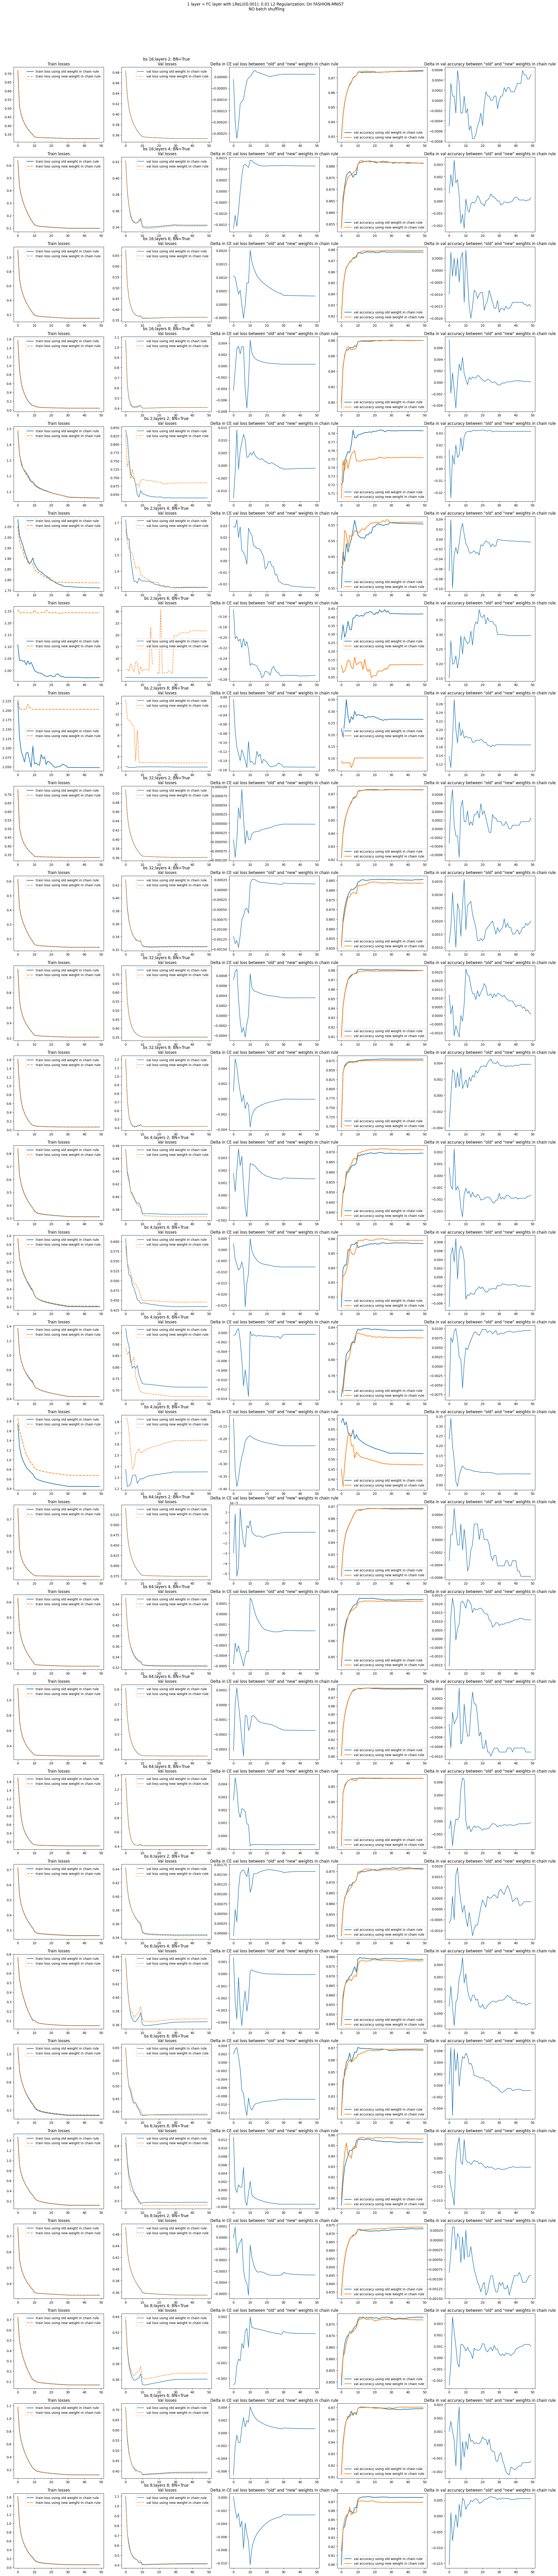

In [24]:
import os

pkls_fnames = [f for f in os.listdir('results/') if '.pkl' in f]
pkls_fnames = sorted(pkls_fnames)

f, ax = plt.subplots(len(pkls_fnames), 5, figsize=(29, 140))
f.suptitle('1 layer = FC layer with LReLU(0.001); 0.01 L2 Regularization; On FASHION-MNIST \n NO batch shuffling', x=0.5, y=0.9)

for i, pkl_f in enumerate(pkls_fnames):
    inpp = open(f'results/{pkl_f}', 'rb')
    inpp = pickle.load(inpp)

    loss_tr_old, loss_tr_new, acc_tr_old, acc_tr_new, loss_val_old, loss_val_new, acc_val_old, acc_val_new = inpp
    
    ax[i][0].plot(loss_tr_old, alpha=1, label='train loss using old weight in chain rule', linewidth=2)
    ax[i][0].plot(loss_tr_new, alpha=1, label='train loss using new weight in chain rule', linestyle='dashed', linewidth=2)
    ax[i][0].legend()    
    ax[i][0].set_title('Train losses')

    ax[i][1].plot(loss_val_old, alpha=1, label='val loss using old weight in chain rule')
    ax[i][1].plot(loss_val_new, alpha=1, label='val loss using new weight in chain rule', linestyle='dashed')
    ax[i][1].legend() 
    
    ax[i][2].plot(np.array(loss_tr_old) - np.array(loss_tr_new))
    ax[i][2].set_title('Delta in CE val loss between "old" and "new" weights in chain rule')

    ax[i][3].plot(acc_val_old, label='val accuracy using old weight in chain rule', linewidth=2)
    ax[i][3].plot(acc_val_new, label='val accuracy using new weight in chain rule', linewidth=2)
    ax[i][3].legend()

    ax[i][4].plot(np.array(acc_val_old) - np.array(acc_val_new))
    ax[i][4].set_title('Delta in val accuracy between "old" and "new" weights in chain rule')
    
    ax[i][1].set_title(pkl_f.strip('.pkl').replace('-', ' ') + '\n Val losses')

f.savefig('first_experience.png')